In [1301]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
import itertools

import statsmodels as sm
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import acf 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf 
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima_process import arma_generate_sample

from statsmodels.tsa.arima.model import ARIMA

import pmdarima as pm
from pmdarima import model_selection

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.seasonal import seasonal_decompose


from sklearn.preprocessing import OneHotEncoder

In [99]:
data = pd.read_csv('./data/zillow_data.csv')

In [404]:
df_weekly = pd.read_csv('./data/zillow_weekly_data.csv')

In [458]:
df_weekly

RegionID  SizeRank             RegionName RegionType StateName  \
0      102001         0          United States    country       NaN   
1      394913         1           New York, NY        msa        NY   
2      753899         2        Los Angeles, CA        msa        CA   
3      394463         3            Chicago, IL        msa        IL   
4      394514         4             Dallas, TX        msa        TX   
..        ...       ...                    ...        ...       ...   
187    394917       282              Niles, MI        msa        MI   
188    394685       289  Homosassa Springs, FL        msa        FL   
189    394442       321         Carbondale, IL        msa        IL   
190    394890       327       Mount Vernon, WA        msa        WA   
191    395098       335       Sierra Vista, AZ        msa        AZ   

     2008-02-02  2008-02-09  2008-02-16  2008-02-23  2008-03-01  ...  \
0      184169.0    180000.0    180000.0    177000.0    182500.0  ...   
1      392000.0    412500.0    410000.0    406850.0    389500.0  ...   
2      475000.0    500000.0    519000.0    520750.0    482000.0  ...   
3      239500.0    240000.0    240000.0    225000.0    240000.0  ...   
4      137550.0    124950.0    140080.0    136000.0    138000.0  ...   
..          ...         ...         ...         ...         ...  ...   
187         NaN         NaN         NaN         NaN         NaN  ...   
188         NaN         NaN         NaN         NaN         NaN  ...   
189         NaN         NaN         NaN         NaN         NaN  ...   
190         NaN         NaN         NaN         NaN         NaN  ...   
191         NaN         NaN         NaN         NaN         NaN  ...   

     2023-04-01  2023-04-08  2023-04-15  2023-04-22  2023-04-29  2023-05-06  \
0      348000.0    349900.0    349000.0    350000.0    350000.0    357000.0   
1      518750.0    540000.0    530000.0    550000.0    540000.0    561750.0   
2      857500.0    842250.0    850000.0    850000.0    850000.0    877500.0   
3      301250.0    296000.0    307000.0    304000.0    310500.0    310000.0   
4      375000.0    385000.0    379250.0    385000.0    390000.0    390000.0   
..          ...         ...         ...         ...         ...         ...   
187    258500.0    250000.0    182000.0    230000.0    195500.0    280000.0   
188    264950.0    286000.0    269750.0    266500.0    290000.0    260000.0   
189    134950.0    115000.0    114900.0    116900.0    164500.0    140000.0   
190         NaN         NaN         NaN         NaN         NaN         NaN   
191    220000.0    232000.0    248000.0    268500.0    265000.0    278500.0   

     2023-05-13  2023-05-20  2023-05-27  2023-06-03  
0      352000.0    360000.0    360000.0    370000.0  
1      565000.0    560000.0    568255.0    580000.0  
2      850000.0    870000.0    880000.0    895500.0  
3      312500.0    315000.0    320000.0    342000.0  
4      389000.0    405000.0    390000.0    405000.0  
..          ...         ...         ...         ...  
187    257500.0    289950.0    288000.0    339500.0  
188    264000.0    294000.0    293000.0    266150.0  
189    115000.0    132750.0    109000.0    132950.0  
190         NaN    460000.0    548000.0    530000.0  
191    295000.0    236000.0    270000.0    241950.0  

[192 rows x 806 columns]

In [462]:
df_weekly.columns

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       '2008-02-02', '2008-02-09', '2008-02-16', '2008-02-23', '2008-03-01',
       ...
       '2023-04-01', '2023-04-08', '2023-04-15', '2023-04-22', '2023-04-29',
       '2023-05-06', '2023-05-13', '2023-05-20', '2023-05-27', '2023-06-03'],
      dtype='object', length=806)

In [469]:
def melt_data_weekly(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [478]:
weekly_melt =  melt_data_weekly(df_weekly)
weekly_melt.set_index('time', inplace = True)
weekly_melt.index = pd.to_datetime(weekly_melt.index)
weekly_melt.rename(columns = {'value':'Price'}, inplace = True)

In [520]:
weekly_melt['StateName'].str.replace('NaN', 'USA', regex = True)

time
2008-02-02    NaN
2008-02-02     NY
2008-02-02     CA
2008-02-02     IL
2008-02-02     TX
             ... 
2023-06-03     MI
2023-06-03     FL
2023-06-03     IL
2023-06-03     WA
2023-06-03     AZ
Name: StateName, Length: 122086, dtype: object

In [543]:
weekly_melt[weekly_melt['RegionName'] == 'United States']['StateName'].astype(str)

time
2008-02-02    nan
2008-02-09    nan
2008-02-16    nan
2008-02-23    nan
2008-03-01    nan
             ... 
2023-05-06    nan
2023-05-13    nan
2023-05-20    nan
2023-05-27    nan
2023-06-03    nan
Name: StateName, Length: 801, dtype: object

In [545]:
weekly_melt['State'] = weekly_melt['StateName']

In [546]:
weekly_melt

RegionID  SizeRank             RegionName RegionType StateName  \
time                                                                         
2008-02-02    102001         0          United States    country       NaN   
2008-02-02    394913         1           New York, NY        msa        NY   
2008-02-02    753899         2        Los Angeles, CA        msa        CA   
2008-02-02    394463         3            Chicago, IL        msa        IL   
2008-02-02    394514         4             Dallas, TX        msa        TX   
...              ...       ...                    ...        ...       ...   
2023-06-03    394917       282              Niles, MI        msa        MI   
2023-06-03    394685       289  Homosassa Springs, FL        msa        FL   
2023-06-03    394442       321         Carbondale, IL        msa        IL   
2023-06-03    394890       327       Mount Vernon, WA        msa        WA   
2023-06-03    395098       335       Sierra Vista, AZ        msa        AZ   

               Price State  
time                        
2008-02-02  184169.0   NaN  
2008-02-02  392000.0    NY  
2008-02-02  475000.0    CA  
2008-02-02  239500.0    IL  
2008-02-02  137550.0    TX  
...              ...   ...  
2023-06-03  339500.0    MI  
2023-06-03  266150.0    FL  
2023-06-03  132950.0    IL  
2023-06-03  530000.0    WA  
2023-06-03  241950.0    AZ  

[122086 rows x 7 columns]

In [524]:
weekly_melt.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 122086 entries, 2008-02-02 to 2023-06-03
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   RegionID    122086 non-null  int64  
 1   SizeRank    122086 non-null  int64  
 2   RegionName  122086 non-null  object 
 3   RegionType  122086 non-null  object 
 4   StateName   121285 non-null  object 
 5   Price       122086 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 6.5+ MB


In [516]:
weekly_melt.apply(if weekly_melt['RegionName'] == 'United States'

time
2008-02-02     True
2008-02-02    False
2008-02-02    False
2008-02-02    False
2008-02-02    False
              ...  
2023-06-03    False
2023-06-03    False
2023-06-03    False
2023-06-03    False
2023-06-03    False
Name: RegionName, Length: 122086, dtype: bool

In [512]:
weekly_melt['StateName'].unique()[0]

float

<Axes: xlabel='time'>

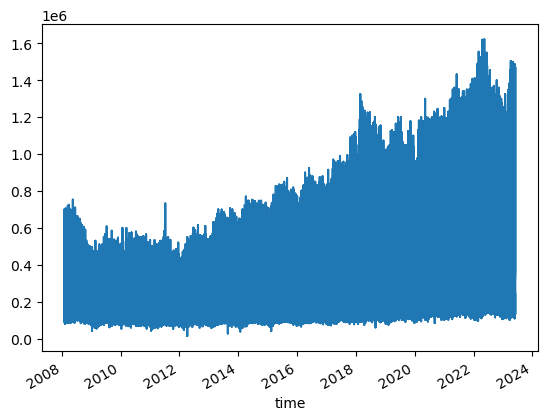

In [496]:
weekly_melt['Price'].plot()

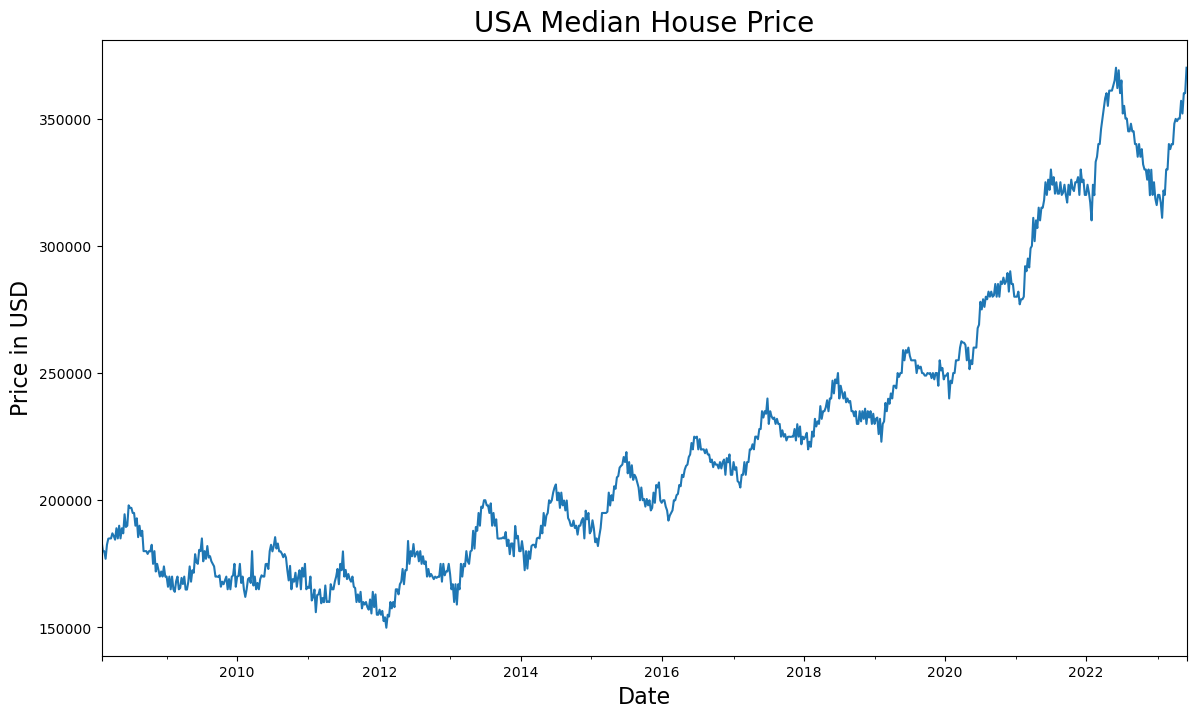

In [865]:
fig, ax = plt.subplots(figsize = (14,8))

weekly_melt[weekly_melt['RegionName'] == 'United States']['Price'].plot(ax = ax)

ax.set_title('USA Median House Price', fontsize = 20)

ax.set_xlabel('Date', fontsize = 16);
ax.set_ylabel('Price in USD', fontsize = 16)

plt.show();

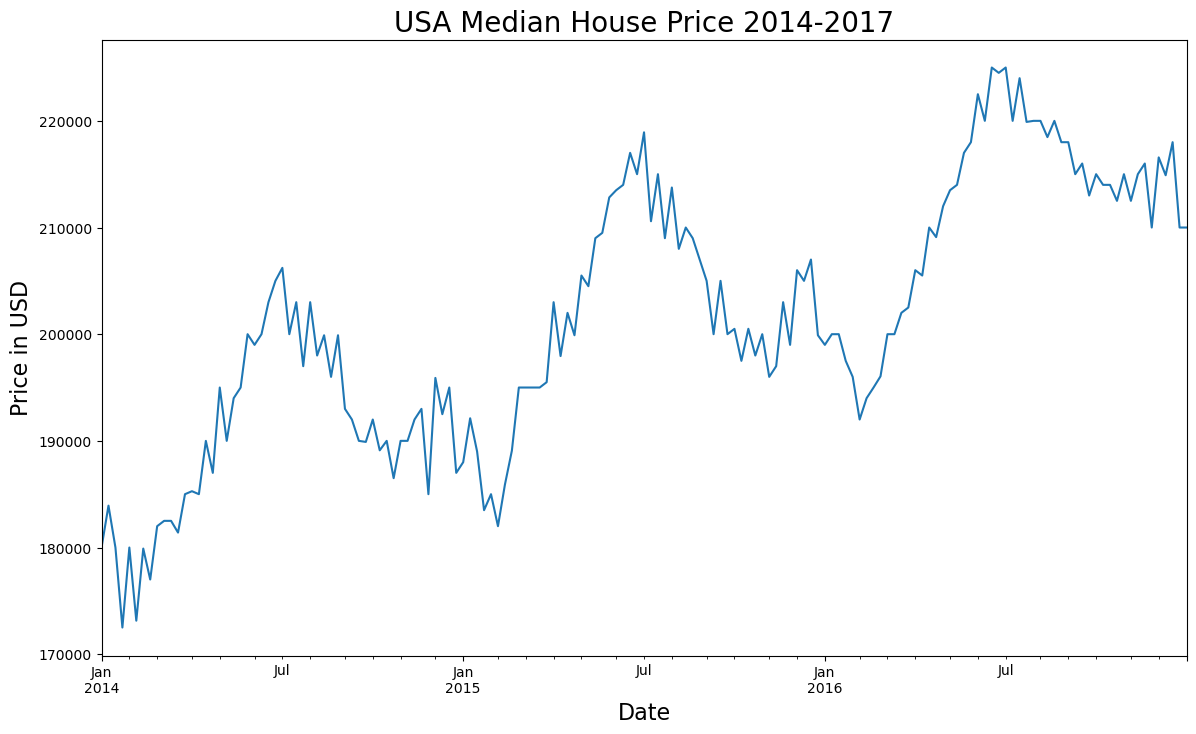

In [1355]:
fig, ax = plt.subplots(figsize = (14,8))

weekly_melt[weekly_melt['RegionName'] == 'United States']['2014':'2016']['Price'].plot(ax = ax)

ax.set_title('USA Median House Price 2014-2017', fontsize = 20)

ax.set_xlabel('Date', fontsize = 16);
ax.set_ylabel('Price in USD', fontsize = 16)

plt.show();

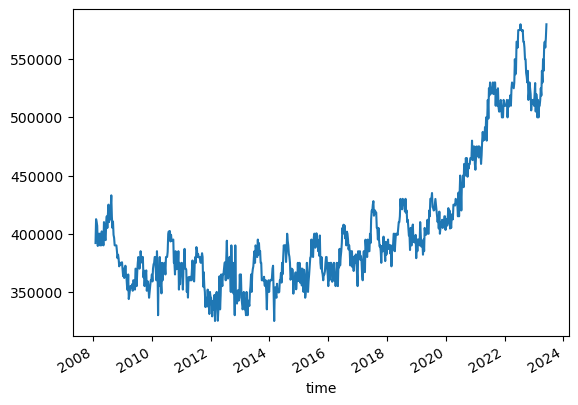

In [630]:
weekly_melt[weekly_melt['RegionName'] == 'New York, NY']['Price'].plot();

In [608]:
weekly_melt['StateName'].unique()

array([nan, 'NY', 'CA', 'IL', 'TX', 'VA', 'PA', 'FL', 'GA', 'MA', 'AZ',
       'MI', 'MN', 'CO', 'MD', 'MO', 'NC', 'OR', 'OH', 'NV', 'IN', 'TN',
       'RI', 'WI', 'OK', 'KY', 'UT', 'CT', 'AL', 'HI', 'NE', 'SC', 'NM',
       'ID', 'AR', 'MS', 'ME', 'LA', 'DE', 'WA', 'NJ'], dtype=object)

In [664]:
states = list(weekly_melt['StateName'].unique())

In [665]:
type(states)

list

In [666]:
onehot_enc = OneHotEncoder(sparse = True, handle_unknown = 'ignore')

In [667]:
ohe

OneHotEncoder()

In [668]:
ohe_df = onehot_enc.fit_transform(weekly_melt[['StateName']])

/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [669]:
ohe

OneHotEncoder()

In [670]:
nominal_df = pd.DataFrame(ohe_df.toarray(),columns = onehot_enc.get_feature_names_out())


In [671]:
nominal_df

StateName_AL  StateName_AR  StateName_AZ  StateName_CA  StateName_CO  \
0                0.0           0.0           0.0           0.0           0.0   
1                0.0           0.0           0.0           0.0           0.0   
2                0.0           0.0           0.0           1.0           0.0   
3                0.0           0.0           0.0           0.0           0.0   
4                0.0           0.0           0.0           0.0           0.0   
...              ...           ...           ...           ...           ...   
122081           0.0           0.0           0.0           0.0           0.0   
122082           0.0           0.0           0.0           0.0           0.0   
122083           0.0           0.0           0.0           0.0           0.0   
122084           0.0           0.0           0.0           0.0           0.0   
122085           0.0           0.0           1.0           0.0           0.0   

        StateName_CT  StateName_DE  StateName_FL  StateName_GA  StateName_HI  \
0                0.0           0.0           0.0           0.0           0.0   
1                0.0           0.0           0.0           0.0           0.0   
2                0.0           0.0           0.0           0.0           0.0   
3                0.0           0.0           0.0           0.0           0.0   
4                0.0           0.0           0.0           0.0           0.0   
...              ...           ...           ...           ...           ...   
122081           0.0           0.0           0.0           0.0           0.0   
122082           0.0           0.0           1.0           0.0           0.0   
122083           0.0           0.0           0.0           0.0           0.0   
122084           0.0           0.0           0.0           0.0           0.0   
122085           0.0           0.0           0.0           0.0           0.0   

        ...  StateName_PA  StateName_RI  StateName_SC  StateName_TN  \
0       ...           0.0           0.0           0.0           0.0   
1       ...           0.0           0.0           0.0           0.0   
2       ...           0.0           0.0           0.0           0.0   
3       ...           0.0           0.0           0.0           0.0   
4       ...           0.0           0.0           0.0           0.0   
...     ...           ...           ...           ...           ...   
122081  ...           0.0           0.0           0.0           0.0   
122082  ...           0.0           0.0           0.0           0.0   
122083  ...           0.0           0.0           0.0           0.0   
122084  ...           0.0           0.0           0.0           0.0   
122085  ...           0.0           0.0           0.0           0.0   

        StateName_TX  StateName_UT  StateName_VA  StateName_WA  StateName_WI  \
0                0.0           0.0           0.0           0.0           0.0   
1                0.0           0.0           0.0           0.0           0.0   
2                0.0           0.0           0.0           0.0           0.0   
3                0.0           0.0           0.0           0.0           0.0   
4                1.0           0.0           0.0           0.0           0.0   
...              ...           ...           ...           ...           ...   
122081           0.0           0.0           0.0           0.0           0.0   
122082           0.0           0.0           0.0           0.0           0.0   
122083           0.0           0.0           0.0           0.0           0.0   
122084           0.0           0.0           0.0           1.0           0.0   
122085           0.0           0.0           0.0           0.0           0.0   

        StateName_nan  
0                 1.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0  
...               ...  
122081            0.0  
122082            0.0  
122083            0.0  
122084            0.0  
122085  

In [672]:
weekly_melt.shape

(122086, 7)

In [673]:
nominal_df.shape

(122086, 41)

In [674]:
nominal_df.set_index(weekly_melt.index, inplace = True)

In [675]:
nominal_df.columns[-1]

'StateName_nan'

In [676]:
data_ohe = pd.concat([weekly_melt, nominal_df], axis = 1)

In [677]:
data_ohe.rename(columns = {'StateName_nan': 'StateName_USA'}, inplace = True)

In [678]:
data_ohe

RegionID  SizeRank             RegionName RegionType StateName  \
time                                                                         
2008-02-02    102001         0          United States    country       NaN   
2008-02-02    394913         1           New York, NY        msa        NY   
2008-02-02    753899         2        Los Angeles, CA        msa        CA   
2008-02-02    394463         3            Chicago, IL        msa        IL   
2008-02-02    394514         4             Dallas, TX        msa        TX   
...              ...       ...                    ...        ...       ...   
2023-06-03    394917       282              Niles, MI        msa        MI   
2023-06-03    394685       289  Homosassa Springs, FL        msa        FL   
2023-06-03    394442       321         Carbondale, IL        msa        IL   
2023-06-03    394890       327       Mount Vernon, WA        msa        WA   
2023-06-03    395098       335       Sierra Vista, AZ        msa        AZ   

               Price State  StateName_AL  StateName_AR  StateName_AZ  ...  \
time                                                                  ...   
2008-02-02  184169.0   NaN           0.0           0.0           0.0  ...   
2008-02-02  392000.0    NY           0.0           0.0           0.0  ...   
2008-02-02  475000.0    CA           0.0           0.0           0.0  ...   
2008-02-02  239500.0    IL           0.0           0.0           0.0  ...   
2008-02-02  137550.0    TX           0.0           0.0           0.0  ...   
...              ...   ...           ...           ...           ...  ...   
2023-06-03  339500.0    MI           0.0           0.0           0.0  ...   
2023-06-03  266150.0    FL           0.0           0.0           0.0  ...   
2023-06-03  132950.0    IL           0.0           0.0           0.0  ...   
2023-06-03  530000.0    WA           0.0           0.0           0.0  ...   
2023-06-03  241950.0    AZ           0.0           0.0           1.0  ...   

            StateName_PA  StateName_RI  StateName_SC  StateName_TN  \
time                                                                 
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-02           0.0           0.0           0.0           0.0   
...                  ...           ...           ...           ...   
2023-06-03           0.0           0.0           0.0           0.0   
2023-06-03           0.0           0.0           0.0           0.0   
2023-06-03           0.0           0.0           0.0           0.0   
2023-06-03           0.0           0.0           0.0           0.0   
2023-06-03           0.0           0.0           0.0           0.0   

            StateName_TX  StateName_UT  StateName_VA  StateName_WA  \
time                                                                 
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-02           1.0           0.0           0.0           0.0   
...                  ...           ...           ...           ...   
2023-06-03           0.0           0.0           0.0           0.0   
2023-06-03           0.0           0.0           0.0           0.0   
2023-06-03           0.0           0.0           0.0           0.0   
2023-06-03           0.0           0.0           0.0           1.0   
2023-06-03           0.0           0.0           0.0           0.0   

            StateName_WI  StateName_USA  
time                                     
2008-02-02           0.0            1.0  
2008-02-02           0.0            0.0  
2008-

In [681]:
data_ohe = data_ohe.drop(columns = ['StateName', 'State'])

In [682]:
data_ohe.columns

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'Price',
       'StateName_AL', 'StateName_AR', 'StateName_AZ', 'StateName_CA',
       'StateName_CO', 'StateName_CT', 'StateName_DE', 'StateName_FL',
       'StateName_GA', 'StateName_HI', 'StateName_ID', 'StateName_IL',
       'StateName_IN', 'StateName_KY', 'StateName_LA', 'StateName_MA',
       'StateName_MD', 'StateName_ME', 'StateName_MI', 'StateName_MN',
       'StateName_MO', 'StateName_MS', 'StateName_NC', 'StateName_NE',
       'StateName_NJ', 'StateName_NM', 'StateName_NV', 'StateName_NY',
       'StateName_OH', 'StateName_OK', 'StateName_OR', 'StateName_PA',
       'StateName_RI', 'StateName_SC', 'StateName_TN', 'StateName_TX',
       'StateName_UT', 'StateName_VA', 'StateName_WA', 'StateName_WI',
       'StateName_USA'],
      dtype='object')

In [684]:
data_ohe

RegionID  SizeRank             RegionName RegionType     Price  \
time                                                                         
2008-02-02    102001         0          United States    country  184169.0   
2008-02-02    394913         1           New York, NY        msa  392000.0   
2008-02-02    753899         2        Los Angeles, CA        msa  475000.0   
2008-02-02    394463         3            Chicago, IL        msa  239500.0   
2008-02-02    394514         4             Dallas, TX        msa  137550.0   
...              ...       ...                    ...        ...       ...   
2023-06-03    394917       282              Niles, MI        msa  339500.0   
2023-06-03    394685       289  Homosassa Springs, FL        msa  266150.0   
2023-06-03    394442       321         Carbondale, IL        msa  132950.0   
2023-06-03    394890       327       Mount Vernon, WA        msa  530000.0   
2023-06-03    395098       335       Sierra Vista, AZ        msa  241950.0   

            StateName_AL  StateName_AR  StateName_AZ  StateName_CA  \
time                                                                 
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-02           0.0           0.0           0.0           1.0   
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-02           0.0           0.0           0.0           0.0   
...                  ...           ...           ...           ...   
2023-06-03           0.0           0.0           0.0           0.0   
2023-06-03           0.0           0.0           0.0           0.0   
2023-06-03           0.0           0.0           0.0           0.0   
2023-06-03           0.0           0.0           0.0           0.0   
2023-06-03           0.0           0.0           1.0           0.0   

            StateName_CO  ...  StateName_PA  StateName_RI  StateName_SC  \
time                      ...                                             
2008-02-02           0.0  ...           0.0           0.0           0.0   
2008-02-02           0.0  ...           0.0           0.0           0.0   
2008-02-02           0.0  ...           0.0           0.0           0.0   
2008-02-02           0.0  ...           0.0           0.0           0.0   
2008-02-02           0.0  ...           0.0           0.0           0.0   
...                  ...  ...           ...           ...           ...   
2023-06-03           0.0  ...           0.0           0.0           0.0   
2023-06-03           0.0  ...           0.0           0.0           0.0   
2023-06-03           0.0  ...           0.0           0.0           0.0   
2023-06-03           0.0  ...           0.0           0.0           0.0   
2023-06-03           0.0  ...           0.0           0.0           0.0   

            StateName_TN  StateName_TX  StateName_UT  StateName_VA  \
time                                                                 
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-02           0.0           1.0           0.0           0.0   
...                  ...           ...           ...           ...   
2023-06-03           0.0           0.0           0.0           0.0   
2023-06-03           0.0           0.0           0.0           0.0   
2023-06-03           0.0           0.0           0.0           0.0   
2023-06-03           0.0           0.0           0.0           0.0   
2023-06-03           0.0           0.0           0.0           0.0   

            StateName_WA  StateName_WI  StateName_USA  
time                                                   
2008-02-02           0.0           0.0            1.0  
2008-02-02           0.0       

In [685]:
data_ohe.columns

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'Price',
       'StateName_AL', 'StateName_AR', 'StateName_AZ', 'StateName_CA',
       'StateName_CO', 'StateName_CT', 'StateName_DE', 'StateName_FL',
       'StateName_GA', 'StateName_HI', 'StateName_ID', 'StateName_IL',
       'StateName_IN', 'StateName_KY', 'StateName_LA', 'StateName_MA',
       'StateName_MD', 'StateName_ME', 'StateName_MI', 'StateName_MN',
       'StateName_MO', 'StateName_MS', 'StateName_NC', 'StateName_NE',
       'StateName_NJ', 'StateName_NM', 'StateName_NV', 'StateName_NY',
       'StateName_OH', 'StateName_OK', 'StateName_OR', 'StateName_PA',
       'StateName_RI', 'StateName_SC', 'StateName_TN', 'StateName_TX',
       'StateName_UT', 'StateName_VA', 'StateName_WA', 'StateName_WI',
       'StateName_USA'],
      dtype='object')

In [686]:
def date_features(df):
    """
    Data features for time series analysis
    """
    df = df.copy()
    df['year'] = df.index.year
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear

    return df

In [693]:
data_ohe.columns

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'Price',
       'StateName_AL', 'StateName_AR', 'StateName_AZ', 'StateName_CA',
       'StateName_CO', 'StateName_CT', 'StateName_DE', 'StateName_FL',
       'StateName_GA', 'StateName_HI', 'StateName_ID', 'StateName_IL',
       'StateName_IN', 'StateName_KY', 'StateName_LA', 'StateName_MA',
       'StateName_MD', 'StateName_ME', 'StateName_MI', 'StateName_MN',
       'StateName_MO', 'StateName_MS', 'StateName_NC', 'StateName_NE',
       'StateName_NJ', 'StateName_NM', 'StateName_NV', 'StateName_NY',
       'StateName_OH', 'StateName_OK', 'StateName_OR', 'StateName_PA',
       'StateName_RI', 'StateName_SC', 'StateName_TN', 'StateName_TX',
       'StateName_UT', 'StateName_VA', 'StateName_WA', 'StateName_WI',
       'StateName_USA'],
      dtype='object')

In [775]:
data_ohe

RegionID  SizeRank             RegionName RegionType     Price  \
time                                                                         
2008-02-02    102001         0          United States    country  184169.0   
2008-02-02    394913         1           New York, NY        msa  392000.0   
2008-02-02    753899         2        Los Angeles, CA        msa  475000.0   
2008-02-02    394463         3            Chicago, IL        msa  239500.0   
2008-02-02    394514         4             Dallas, TX        msa  137550.0   
...              ...       ...                    ...        ...       ...   
2023-06-03    394917       282              Niles, MI        msa  339500.0   
2023-06-03    394685       289  Homosassa Springs, FL        msa  266150.0   
2023-06-03    394442       321         Carbondale, IL        msa  132950.0   
2023-06-03    394890       327       Mount Vernon, WA        msa  530000.0   
2023-06-03    395098       335       Sierra Vista, AZ        msa  241950.0   

            StateName_AL  StateName_AR  StateName_AZ  StateName_CA  \
time                                                                 
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-02           0.0           0.0           0.0           1.0   
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-02           0.0           0.0           0.0           0.0   
...                  ...           ...           ...           ...   
2023-06-03           0.0           0.0           0.0           0.0   
2023-06-03           0.0           0.0           0.0           0.0   
2023-06-03           0.0           0.0           0.0           0.0   
2023-06-03           0.0           0.0           0.0           0.0   
2023-06-03           0.0           0.0           1.0           0.0   

            StateName_CO  ...  StateName_PA  StateName_RI  StateName_SC  \
time                      ...                                             
2008-02-02           0.0  ...           0.0           0.0           0.0   
2008-02-02           0.0  ...           0.0           0.0           0.0   
2008-02-02           0.0  ...           0.0           0.0           0.0   
2008-02-02           0.0  ...           0.0           0.0           0.0   
2008-02-02           0.0  ...           0.0           0.0           0.0   
...                  ...  ...           ...           ...           ...   
2023-06-03           0.0  ...           0.0           0.0           0.0   
2023-06-03           0.0  ...           0.0           0.0           0.0   
2023-06-03           0.0  ...           0.0           0.0           0.0   
2023-06-03           0.0  ...           0.0           0.0           0.0   
2023-06-03           0.0  ...           0.0           0.0           0.0   

            StateName_TN  StateName_TX  StateName_UT  StateName_VA  \
time                                                                 
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-02           0.0           1.0           0.0           0.0   
...                  ...           ...           ...           ...   
2023-06-03           0.0           0.0           0.0           0.0   
2023-06-03           0.0           0.0           0.0           0.0   
2023-06-03           0.0           0.0           0.0           0.0   
2023-06-03           0.0           0.0           0.0           0.0   
2023-06-03           0.0           0.0           0.0           0.0   

            StateName_WA  StateName_WI  StateName_USA  
time                                                   
2008-02-02           0.0           0.0            1.0  
2008-02-02           0.0       

In [688]:
train_data = data_ohe.loc[data_ohe.index < '2020-01-01']
test_data = data_ohe.loc[data_ohe.index >= '2020-01-01']

In [692]:
train_data = date_features(train_data)
test_data = date_features(test_data)

In [694]:
features =  ['year', 'quarter', 'month', 'dayofyear', 'StateName_AL', 'StateName_AR', 'StateName_AZ', 'StateName_CA',
       'StateName_CO', 'StateName_CT', 'StateName_DE', 'StateName_FL',
       'StateName_GA', 'StateName_HI', 'StateName_ID', 'StateName_IL',
       'StateName_IN', 'StateName_KY', 'StateName_LA', 'StateName_MA',
       'StateName_MD', 'StateName_ME', 'StateName_MI', 'StateName_MN',
       'StateName_MO', 'StateName_MS', 'StateName_NC', 'StateName_NE',
       'StateName_NJ', 'StateName_NM', 'StateName_NV', 'StateName_NY',
       'StateName_OH', 'StateName_OK', 'StateName_OR', 'StateName_PA',
       'StateName_RI', 'StateName_SC', 'StateName_TN', 'StateName_TX',
       'StateName_UT', 'StateName_VA', 'StateName_WA', 'StateName_WI',
       'StateName_USA']

target = ['Price']

In [707]:
train_data['Price']

time
2008-02-02    184169.0
2008-02-02    392000.0
2008-02-02    475000.0
2008-02-02    239500.0
2008-02-02    137550.0
                ...   
2019-12-28    399999.0
2019-12-28    194450.0
2019-12-28    215000.0
2019-12-28    125000.0
2019-12-28    159950.0
Name: Price, Length: 91638, dtype: float64

In [708]:
X_train = train_data[features]
y_train = train_data['Price']

X_test = test_data[features]
y_test = test_data['Price']

In [734]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True)

[0]	validation_0-rmse:165172.15649	validation_1-rmse:283695.00587
[1]	validation_0-rmse:126303.15814	validation_1-rmse:236953.52714
[2]	validation_0-rmse:101726.23683	validation_1-rmse:206044.64782
[3]	validation_0-rmse:86880.92488	validation_1-rmse:183383.30680


/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-rmse:78286.95027	validation_1-rmse:170651.29141
[5]	validation_0-rmse:73375.96364	validation_1-rmse:161474.84056
[6]	validation_0-rmse:70585.04879	validation_1-rmse:153528.72711
[7]	validation_0-rmse:68899.87485	validation_1-rmse:148788.23687
[8]	validation_0-rmse:67900.97468	validation_1-rmse:145679.65169
[9]	validation_0-rmse:67269.98882	validation_1-rmse:143718.99574
[10]	validation_0-rmse:66691.07930	validation_1-rmse:141739.77292
[11]	validation_0-rmse:66362.68857	validation_1-rmse:140729.96756
[12]	validation_0-rmse:66063.01442	validation_1-rmse:137886.02441
[13]	validation_0-rmse:65818.75473	validation_1-rmse:137173.91854
[14]	validation_0-rmse:65604.82483	validation_1-rmse:136564.50777
[15]	validation_0-rmse:65369.24730	validation_1-rmse:136072.79729
[16]	validation_0-rmse:65235.01301	validation_1-rmse:135687.27071
[17]	validation_0-rmse:65116.00657	validation_1-rmse:135372.79543
[18]	validation_0-rmse:64994.08281	validation_1-rmse:133990.69396
[19]	validation_

[128]	validation_0-rmse:63600.09606	validation_1-rmse:129354.91106
[129]	validation_0-rmse:63597.13057	validation_1-rmse:129359.01128
[130]	validation_0-rmse:63595.79470	validation_1-rmse:129353.35322
[131]	validation_0-rmse:63595.24107	validation_1-rmse:129353.84989
[132]	validation_0-rmse:63594.63892	validation_1-rmse:129354.54231
[133]	validation_0-rmse:63594.16838	validation_1-rmse:129355.77439
[134]	validation_0-rmse:63593.49117	validation_1-rmse:129351.97514
[135]	validation_0-rmse:63591.57000	validation_1-rmse:129356.57695
[136]	validation_0-rmse:63589.88890	validation_1-rmse:129355.39594
[137]	validation_0-rmse:63588.16854	validation_1-rmse:129363.98938
[138]	validation_0-rmse:63587.38863	validation_1-rmse:129362.72792
[139]	validation_0-rmse:63585.67671	validation_1-rmse:129356.32417
[140]	validation_0-rmse:63585.04629	validation_1-rmse:129358.87117
[141]	validation_0-rmse:63583.43629	validation_1-rmse:129343.81511
[142]	validation_0-rmse:63580.79380	validation_1-rmse:129334.4

[251]	validation_0-rmse:63498.47611	validation_1-rmse:129306.07631
[252]	validation_0-rmse:63497.71223	validation_1-rmse:129302.14777
[253]	validation_0-rmse:63497.17112	validation_1-rmse:129300.29781
[254]	validation_0-rmse:63496.80911	validation_1-rmse:129299.62277
[255]	validation_0-rmse:63496.44330	validation_1-rmse:129300.15616
[256]	validation_0-rmse:63495.91805	validation_1-rmse:129300.46346
[257]	validation_0-rmse:63495.11272	validation_1-rmse:129297.22672
[258]	validation_0-rmse:63494.77869	validation_1-rmse:129297.58411
[259]	validation_0-rmse:63493.63859	validation_1-rmse:129305.54211
[260]	validation_0-rmse:63492.65095	validation_1-rmse:129307.54581
[261]	validation_0-rmse:63491.92699	validation_1-rmse:129310.16719
[262]	validation_0-rmse:63491.42416	validation_1-rmse:129309.30639
[263]	validation_0-rmse:63490.76261	validation_1-rmse:129307.62833
[264]	validation_0-rmse:63490.27797	validation_1-rmse:129308.04855
[265]	validation_0-rmse:63489.85509	validation_1-rmse:129303.9

[374]	validation_0-rmse:63447.13109	validation_1-rmse:129310.33626
[375]	validation_0-rmse:63446.70598	validation_1-rmse:129311.63707


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [716]:
test_data['Predicted'] = reg.predict(X_test)

In [731]:
train_data['Predicted'] = reg.predict(X_train)

In [732]:
train_data

RegionID  SizeRank             RegionName RegionType     Price  \
time                                                                         
2008-02-02    102001         0          United States    country  184169.0   
2008-02-02    394913         1           New York, NY        msa  392000.0   
2008-02-02    753899         2        Los Angeles, CA        msa  475000.0   
2008-02-02    394463         3            Chicago, IL        msa  239500.0   
2008-02-02    394514         4             Dallas, TX        msa  137550.0   
...              ...       ...                    ...        ...       ...   
2019-12-28    394380       232               Bend, OR        msa  399999.0   
2019-12-28    395009       237        Punta Gorda, FL        msa  194450.0   
2019-12-28    394960       242        Panama City, FL        msa  215000.0   
2019-12-28    394553       263   East Stroudsburg, PA        msa  125000.0   
2019-12-28    394685       289  Homosassa Springs, FL        msa  159950.0   

            StateName_AL  StateName_AR  StateName_AZ  StateName_CA  \
time                                                                 
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-02           0.0           0.0           0.0           1.0   
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-02           0.0           0.0           0.0           0.0   
...                  ...           ...           ...           ...   
2019-12-28           0.0           0.0           0.0           0.0   
2019-12-28           0.0           0.0           0.0           0.0   
2019-12-28           0.0           0.0           0.0           0.0   
2019-12-28           0.0           0.0           0.0           0.0   
2019-12-28           0.0           0.0           0.0           0.0   

            StateName_CO  ...  StateName_UT  StateName_VA  StateName_WA  \
time                      ...                                             
2008-02-02           0.0  ...           0.0           0.0           0.0   
2008-02-02           0.0  ...           0.0           0.0           0.0   
2008-02-02           0.0  ...           0.0           0.0           0.0   
2008-02-02           0.0  ...           0.0           0.0           0.0   
2008-02-02           0.0  ...           0.0           0.0           0.0   
...                  ...  ...           ...           ...           ...   
2019-12-28           0.0  ...           0.0           0.0           0.0   
2019-12-28           0.0  ...           0.0           0.0           0.0   
2019-12-28           0.0  ...           0.0           0.0           0.0   
2019-12-28           0.0  ...           0.0           0.0           0.0   
2019-12-28           0.0  ...           0.0           0.0           0.0   

            StateName_WI  StateName_USA  year  quarter  month  dayofyear  \
time                                                                       
2008-02-02           0.0            1.0  2008        1      2         33   
2008-02-02           0.0            0.0  2008        1      2         33   
2008-02-02           0.0            0.0  2008        1      2         33   
2008-02-02           0.0            0.0  2008        1      2         33   
2008-02-02           0.0            0.0  2008        1      2         33   
...                  ...            ...   ...      ...    ...        ...   
2019-12-28           0.0            0.0  2019        4     12        362   
2019-12-28           0.0            0.0  2019        4     12        362   
2019-12-28           0.0            0.0  2019        4     12        362   
2019-12-28           0.0            0.0  2019        4     12        362   
2019-12-28           0.0            0.0  2019        4     12        362   

                Predicted  
time                       
2008-02-02  184223.218750  
2008-02-02  178154.921875  
2008-02-0

<Axes: xlabel='time'>

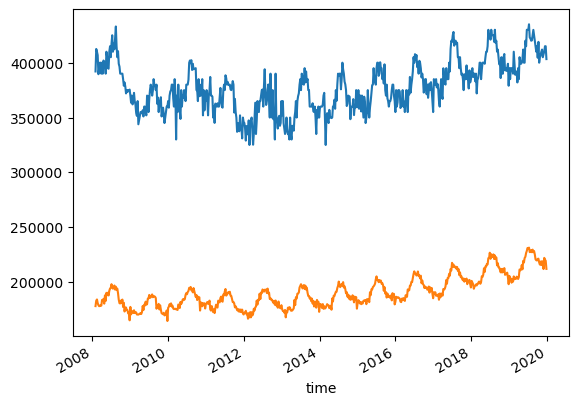

In [733]:
train_data[train_data['RegionName'] == 'New York, NY']['Price'].plot()
train_data[train_data['RegionName'] == 'New York, NY']['Predicted'].plot()

<Axes: xlabel='time'>

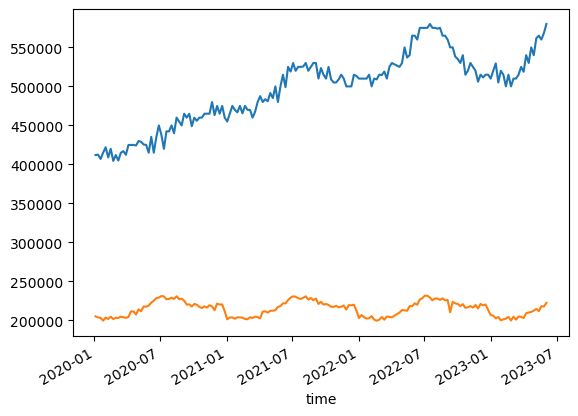

In [748]:
test_data[test_data['RegionName'] == 'New York, NY']['Price'].plot()
test_data[test_data['RegionName'] == 'New York, NY']['Predicted'].plot()

In [749]:
train_data_2 = data_ohe.loc[data_ohe.index < '2017-01-01']
test_data_2 = data_ohe.loc[(data_ohe.index >= '2017-01-01') & (data_ohe.index < '2020-01-01')]

In [750]:
train_data_2 = date_features(train_data_2)
test_data_2 = date_features(test_data_2)

In [751]:
features =  ['year', 'quarter', 'month', 'dayofyear', 'StateName_AL', 'StateName_AR', 'StateName_AZ', 'StateName_CA',
       'StateName_CO', 'StateName_CT', 'StateName_DE', 'StateName_FL',
       'StateName_GA', 'StateName_HI', 'StateName_ID', 'StateName_IL',
       'StateName_IN', 'StateName_KY', 'StateName_LA', 'StateName_MA',
       'StateName_MD', 'StateName_ME', 'StateName_MI', 'StateName_MN',
       'StateName_MO', 'StateName_MS', 'StateName_NC', 'StateName_NE',
       'StateName_NJ', 'StateName_NM', 'StateName_NV', 'StateName_NY',
       'StateName_OH', 'StateName_OK', 'StateName_OR', 'StateName_PA',
       'StateName_RI', 'StateName_SC', 'StateName_TN', 'StateName_TX',
       'StateName_UT', 'StateName_VA', 'StateName_WA', 'StateName_WI',
       'StateName_USA']

target = ['Price']

In [752]:
X_train_2 = train_data_2[features]
y_train_2 = train_data_2['Price']

X_test_2 = test_data_2[features]
y_test_2 = test_data_2['Price']

In [754]:
reg_2 = xgb.XGBRegressor(n_estimators=1000)
reg_2.fit(X_train_2, y_train_2,
        eval_set=[(X_train_2, y_train_2), (X_test_2, y_test_2)],
        early_stopping_rounds=100,
       verbose=True)

[0]	validation_0-rmse:150437.32913	validation_1-rmse:210962.94301
[1]	validation_0-rmse:114395.56448	validation_1-rmse:171625.02566
[2]	validation_0-rmse:91546.56877	validation_1-rmse:146041.13455
[3]	validation_0-rmse:77583.92024	validation_1-rmse:127047.69448
[4]	validation_0-rmse:69514.37340	validation_1-rmse:116501.73403
[5]	validation_0-rmse:64916.00311	validation_1-rmse:109169.23722
[6]	validation_0-rmse:62280.70694	validation_1-rmse:103486.30849


/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:60820.22173	validation_1-rmse:100748.77938
[8]	validation_0-rmse:59922.41903	validation_1-rmse:97347.11772
[9]	validation_0-rmse:59299.58636	validation_1-rmse:95841.63369
[10]	validation_0-rmse:58805.14346	validation_1-rmse:94669.63631
[11]	validation_0-rmse:58425.76403	validation_1-rmse:93591.64640
[12]	validation_0-rmse:58172.94275	validation_1-rmse:92843.01086
[13]	validation_0-rmse:57982.17875	validation_1-rmse:92572.65698
[14]	validation_0-rmse:57769.91350	validation_1-rmse:92011.65313
[15]	validation_0-rmse:57624.96193	validation_1-rmse:91706.85405
[16]	validation_0-rmse:57386.89218	validation_1-rmse:91057.88912
[17]	validation_0-rmse:57228.51072	validation_1-rmse:90845.57370
[18]	validation_0-rmse:57139.59455	validation_1-rmse:90735.22082
[19]	validation_0-rmse:57056.67933	validation_1-rmse:90605.15743
[20]	validation_0-rmse:56962.76331	validation_1-rmse:90427.77227
[21]	validation_0-rmse:56864.75407	validation_1-rmse:89861.32550
[22]	validation_0-rmse:5680

[133]	validation_0-rmse:55925.16565	validation_1-rmse:87805.62041
[134]	validation_0-rmse:55924.85291	validation_1-rmse:87805.75469
[135]	validation_0-rmse:55924.18299	validation_1-rmse:87801.73335
[136]	validation_0-rmse:55923.76144	validation_1-rmse:87803.23169
[137]	validation_0-rmse:55921.98120	validation_1-rmse:87799.67776
[138]	validation_0-rmse:55920.87229	validation_1-rmse:87798.14679
[139]	validation_0-rmse:55920.38489	validation_1-rmse:87797.37728
[140]	validation_0-rmse:55919.15724	validation_1-rmse:87804.45124
[141]	validation_0-rmse:55918.52686	validation_1-rmse:87801.67763
[142]	validation_0-rmse:55917.49928	validation_1-rmse:87806.88703
[143]	validation_0-rmse:55913.55983	validation_1-rmse:87802.11388
[144]	validation_0-rmse:55912.16380	validation_1-rmse:87804.87613
[145]	validation_0-rmse:55909.35856	validation_1-rmse:87800.41022
[146]	validation_0-rmse:55905.43032	validation_1-rmse:87804.74459
[147]	validation_0-rmse:55903.76208	validation_1-rmse:87803.51845
[148]	vali

[258]	validation_0-rmse:55808.45071	validation_1-rmse:87787.11758
[259]	validation_0-rmse:55807.86376	validation_1-rmse:87787.84203
[260]	validation_0-rmse:55807.46058	validation_1-rmse:87787.27196
[261]	validation_0-rmse:55806.67739	validation_1-rmse:87789.25564
[262]	validation_0-rmse:55805.99838	validation_1-rmse:87789.85914
[263]	validation_0-rmse:55805.31923	validation_1-rmse:87787.06769
[264]	validation_0-rmse:55805.21822	validation_1-rmse:87786.90254
[265]	validation_0-rmse:55804.84044	validation_1-rmse:87786.44426
[266]	validation_0-rmse:55804.09455	validation_1-rmse:87786.08439
[267]	validation_0-rmse:55803.61803	validation_1-rmse:87786.75747
[268]	validation_0-rmse:55803.05311	validation_1-rmse:87789.26704
[269]	validation_0-rmse:55802.29610	validation_1-rmse:87788.76733
[270]	validation_0-rmse:55801.74995	validation_1-rmse:87790.10073
[271]	validation_0-rmse:55801.35727	validation_1-rmse:87790.88088
[272]	validation_0-rmse:55801.06473	validation_1-rmse:87789.87939
[273]	vali

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [761]:
train_data_2['Predicted'] = reg_2.predict(X_train_2)

In [762]:
test_data_2['Predicted'] = reg_2.predict(X_test_2)

In [764]:
test_data_2

RegionID  SizeRank             RegionName RegionType     Price  \
time                                                                         
2017-01-07    102001         0          United States    country  215000.0   
2017-01-07    394913         1           New York, NY        msa  385000.0   
2017-01-07    753899         2        Los Angeles, CA        msa  560000.0   
2017-01-07    394463         3            Chicago, IL        msa  205000.0   
2017-01-07    394514         4             Dallas, TX        msa  228000.0   
...              ...       ...                    ...        ...       ...   
2019-12-28    394380       232               Bend, OR        msa  399999.0   
2019-12-28    395009       237        Punta Gorda, FL        msa  194450.0   
2019-12-28    394960       242        Panama City, FL        msa  215000.0   
2019-12-28    394553       263   East Stroudsburg, PA        msa  125000.0   
2019-12-28    394685       289  Homosassa Springs, FL        msa  159950.0   

            StateName_AL  StateName_AR  StateName_AZ  StateName_CA  \
time                                                                 
2017-01-07           0.0           0.0           0.0           0.0   
2017-01-07           0.0           0.0           0.0           0.0   
2017-01-07           0.0           0.0           0.0           1.0   
2017-01-07           0.0           0.0           0.0           0.0   
2017-01-07           0.0           0.0           0.0           0.0   
...                  ...           ...           ...           ...   
2019-12-28           0.0           0.0           0.0           0.0   
2019-12-28           0.0           0.0           0.0           0.0   
2019-12-28           0.0           0.0           0.0           0.0   
2019-12-28           0.0           0.0           0.0           0.0   
2019-12-28           0.0           0.0           0.0           0.0   

            StateName_CO  ...  StateName_UT  StateName_VA  StateName_WA  \
time                      ...                                             
2017-01-07           0.0  ...           0.0           0.0           0.0   
2017-01-07           0.0  ...           0.0           0.0           0.0   
2017-01-07           0.0  ...           0.0           0.0           0.0   
2017-01-07           0.0  ...           0.0           0.0           0.0   
2017-01-07           0.0  ...           0.0           0.0           0.0   
...                  ...  ...           ...           ...           ...   
2019-12-28           0.0  ...           0.0           0.0           0.0   
2019-12-28           0.0  ...           0.0           0.0           0.0   
2019-12-28           0.0  ...           0.0           0.0           0.0   
2019-12-28           0.0  ...           0.0           0.0           0.0   
2019-12-28           0.0  ...           0.0           0.0           0.0   

            StateName_WI  StateName_USA  year  quarter  month  dayofyear  \
time                                                                       
2017-01-07           0.0            1.0  2017        1      1          7   
2017-01-07           0.0            0.0  2017        1      1          7   
2017-01-07           0.0            0.0  2017        1      1          7   
2017-01-07           0.0            0.0  2017        1      1          7   
2017-01-07           0.0            0.0  2017        1      1          7   
...                  ...            ...   ...      ...    ...        ...   
2019-12-28           0.0            0.0  2019        4     12        362   
2019-12-28           0.0            0.0  2019        4     12        362   
2019-12-28           0.0            0.0  2019        4     12        362   
2019-12-28           0.0            0.0  2019        4     12        362   
2019-12-28           0.0            0.0  2019        4     12        362   

                Predicted  
time                       
2017-01-07  198846.031250  
2017-01-07  183716.109375  
2017-01-0

<Axes: xlabel='time'>

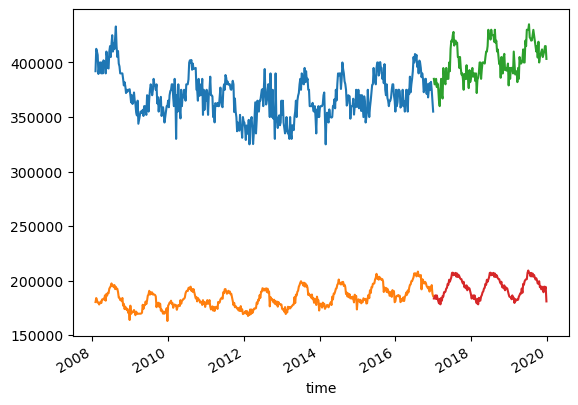

In [774]:
train_data_2[train_data_2['RegionName'] == 'New York, NY']['Price'].plot()
train_data_2[train_data_2['RegionName'] == 'New York, NY']['Predicted'].plot()

test_data_2[test_data_2['RegionName'] == 'New York, NY']['Price'].plot()
test_data_2[test_data_2['RegionName'] == 'New York, NY']['Predicted'].plot()



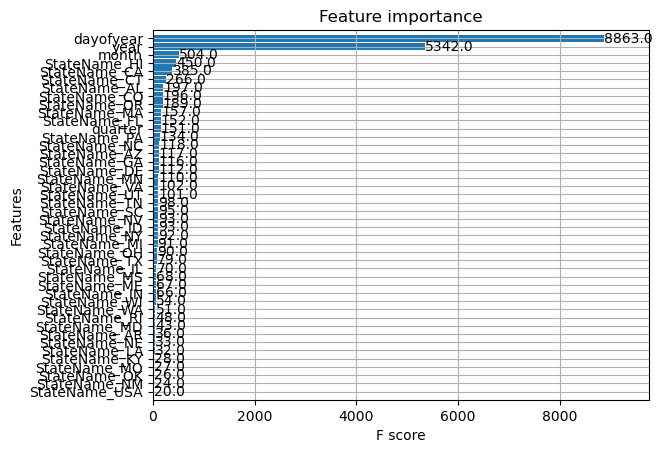

In [712]:
_ = plot_importance(reg, height=0.9)


In [ ]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)


In [808]:
nyc = data_ohe[data_ohe['RegionName'] == 'New York, NY']

nyc = date_features(nyc)

In [871]:
nyc_train = nyc.loc[nyc.index < '2017-01-01']
nyc_test = nyc.loc[(nyc.index >= '2017-01-01') & (nyc.index < '2020-01-01')]

In [872]:
nyc_train

RegionID  SizeRank    RegionName RegionType     Price  \
time                                                                
2008-02-02    394913         1  New York, NY        msa  392000.0   
2008-02-09    394913         1  New York, NY        msa  412500.0   
2008-02-16    394913         1  New York, NY        msa  410000.0   
2008-02-23    394913         1  New York, NY        msa  406850.0   
2008-03-01    394913         1  New York, NY        msa  389500.0   
...              ...       ...           ...        ...       ...   
2016-12-03    394913         1  New York, NY        msa  375000.0   
2016-12-10    394913         1  New York, NY        msa  382250.0   
2016-12-17    394913         1  New York, NY        msa  375000.0   
2016-12-24    394913         1  New York, NY        msa  365000.0   
2016-12-31    394913         1  New York, NY        msa  355000.0   

            StateName_AL  StateName_AR  StateName_AZ  StateName_CA  \
time                                                                 
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-09           0.0           0.0           0.0           0.0   
2008-02-16           0.0           0.0           0.0           0.0   
2008-02-23           0.0           0.0           0.0           0.0   
2008-03-01           0.0           0.0           0.0           0.0   
...                  ...           ...           ...           ...   
2016-12-03           0.0           0.0           0.0           0.0   
2016-12-10           0.0           0.0           0.0           0.0   
2016-12-17           0.0           0.0           0.0           0.0   
2016-12-24           0.0           0.0           0.0           0.0   
2016-12-31           0.0           0.0           0.0           0.0   

            StateName_CO  ...  StateName_TX  StateName_UT  StateName_VA  \
time                      ...                                             
2008-02-02           0.0  ...           0.0           0.0           0.0   
2008-02-09           0.0  ...           0.0           0.0           0.0   
2008-02-16           0.0  ...           0.0           0.0           0.0   
2008-02-23           0.0  ...           0.0           0.0           0.0   
2008-03-01           0.0  ...           0.0           0.0           0.0   
...                  ...  ...           ...           ...           ...   
2016-12-03           0.0  ...           0.0           0.0           0.0   
2016-12-10           0.0  ...           0.0           0.0           0.0   
2016-12-17           0.0  ...           0.0           0.0           0.0   
2016-12-24           0.0  ...           0.0           0.0           0.0   
2016-12-31           0.0  ...           0.0           0.0           0.0   

            StateName_WA  StateName_WI  StateName_USA  year  quarter  month  \
time                                                                          
2008-02-02           0.0           0.0            0.0  2008        1      2   
2008-02-09           0.0           0.0            0.0  2008        1      2   
2008-02-16           0.0           0.0            0.0  2008        1      2   
2008-02-23           0.0           0.0            0.0  2008        1      2   
2008-03-01           0.0           0.0            0.0  2008        1      3   
...                  ...           ...            ...   ...      ...    ...   
2016-12-03           0.0           0.0            0.0  2016        4     12   
2016-12-10           0.0           0.0            0.0  2016        4     12   
2016-12-17           0.0           0.0            0.0  2016        4     12   
2016-12-24           0.0           0.0            0.0  2016        4     12   
2016-12-31           0.0           0.0            0.0  2016        4     12   

            dayofyear  
time                   
2008-02-02         33  
2008-02-09         40  
2008-02-16         47  
2008-02-23         54  
2008-03-01         61  
...               ...  
2016-12

In [873]:
#features

In [874]:
X_train_nyc = nyc_train[features]
y_train_nyc = nyc_train['Price']

X_test_nyc = nyc_test[features]
y_test_nyc = nyc_test['Price']

In [875]:
reg_2 = xgb.XGBRegressor(n_estimators=1000, learning_rate = .05)
reg_2.fit(X_train_nyc, y_train_nyc,
        eval_set=[(X_train_nyc, y_train_nyc), (X_test_nyc, y_test_nyc)],
        early_stopping_rounds=100,
       verbose=True)

[0]	validation_0-rmse:351984.29744	validation_1-rmse:382664.86779
[1]	validation_0-rmse:334476.65877	validation_1-rmse:365146.43811
[2]	validation_0-rmse:317845.29258	validation_1-rmse:348503.56631
[3]	validation_0-rmse:302046.61779	validation_1-rmse:332692.62497
[4]	validation_0-rmse:287039.27427	validation_1-rmse:317672.19754
[5]	validation_0-rmse:272783.93558	validation_1-rmse:303402.89992
[6]	validation_0-rmse:259243.22154	validation_1-rmse:289847.28978
[7]	validation_0-rmse:246381.65584	validation_1-rmse:276969.82190
[8]	validation_0-rmse:234165.58487	validation_1-rmse:264736.77300
[9]	validation_0-rmse:222562.96457	validation_1-rmse:253116.02930
[10]	validation_0-rmse:211543.39923	validation_1-rmse:242077.09353
[11]	validation_0-rmse:201078.01077	validation_1-rmse:231591.02232
[12]	validation_0-rmse:191139.38289	validation_1-rmse:221630.29405
[13]	validation_0-rmse:181701.46205	validation_1-rmse:212168.75722
[14]	validation_0-rmse:172738.35841	validation_1-rmse:203346.75716
[15]	

[126]	validation_0-rmse:5416.57841	validation_1-rmse:25573.30120
[127]	validation_0-rmse:5373.95521	validation_1-rmse:25542.03640
[128]	validation_0-rmse:5343.04733	validation_1-rmse:25494.18238
[129]	validation_0-rmse:5312.48772	validation_1-rmse:25458.05764
[130]	validation_0-rmse:5272.11854	validation_1-rmse:25438.67017
[131]	validation_0-rmse:5244.95365	validation_1-rmse:25403.29631
[132]	validation_0-rmse:5217.85242	validation_1-rmse:25372.10510
[133]	validation_0-rmse:5202.45110	validation_1-rmse:25327.65721
[134]	validation_0-rmse:5175.44602	validation_1-rmse:25306.76701


/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[135]	validation_0-rmse:5149.26307	validation_1-rmse:25286.03898
[136]	validation_0-rmse:5105.59664	validation_1-rmse:25254.15462
[137]	validation_0-rmse:5087.06853	validation_1-rmse:25242.80159
[138]	validation_0-rmse:5047.18557	validation_1-rmse:25222.86506
[139]	validation_0-rmse:5029.99427	validation_1-rmse:25212.79917
[140]	validation_0-rmse:5001.16172	validation_1-rmse:25177.51749
[141]	validation_0-rmse:4988.65375	validation_1-rmse:25144.03263
[142]	validation_0-rmse:4972.23964	validation_1-rmse:25136.17234
[143]	validation_0-rmse:4959.92126	validation_1-rmse:25107.69948
[144]	validation_0-rmse:4938.43946	validation_1-rmse:25086.85994
[145]	validation_0-rmse:4916.00184	validation_1-rmse:25069.27329
[146]	validation_0-rmse:4900.96616	validation_1-rmse:25062.45767
[147]	validation_0-rmse:4881.29763	validation_1-rmse:25034.11904
[148]	validation_0-rmse:4861.43313	validation_1-rmse:25015.12398
[149]	validation_0-rmse:4850.67892	validation_1-rmse:25002.71256
[150]	validation_0-rmse:4

[262]	validation_0-rmse:3330.41882	validation_1-rmse:24835.25657
[263]	validation_0-rmse:3320.02807	validation_1-rmse:24834.38239
[264]	validation_0-rmse:3318.61139	validation_1-rmse:24832.59353
[265]	validation_0-rmse:3314.82321	validation_1-rmse:24837.02628
[266]	validation_0-rmse:3313.16065	validation_1-rmse:24835.45251
[267]	validation_0-rmse:3298.34466	validation_1-rmse:24839.70091
[268]	validation_0-rmse:3286.64132	validation_1-rmse:24832.84069
[269]	validation_0-rmse:3277.23092	validation_1-rmse:24833.15564
[270]	validation_0-rmse:3273.69988	validation_1-rmse:24836.35682
[271]	validation_0-rmse:3270.39447	validation_1-rmse:24839.46789
[272]	validation_0-rmse:3268.80906	validation_1-rmse:24837.84962
[273]	validation_0-rmse:3254.85878	validation_1-rmse:24836.21530
[274]	validation_0-rmse:3251.76681	validation_1-rmse:24838.04348
[275]	validation_0-rmse:3237.18354	validation_1-rmse:24842.46283
[276]	validation_0-rmse:3224.96801	validation_1-rmse:24835.08527
[277]	validation_0-rmse:3

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [876]:
nyc_train['Predicted'] = reg_2.predict(X_train_nyc)
nyc_test['Predicted'] = reg_2.predict(X_test_nyc)

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1256/2814559478.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_train['Predicted'] = reg_2.predict(X_train_nyc)
/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1256/2814559478.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_test['Predicted'] = reg_2.predict(X_test_nyc)


<Axes: xlabel='time'>

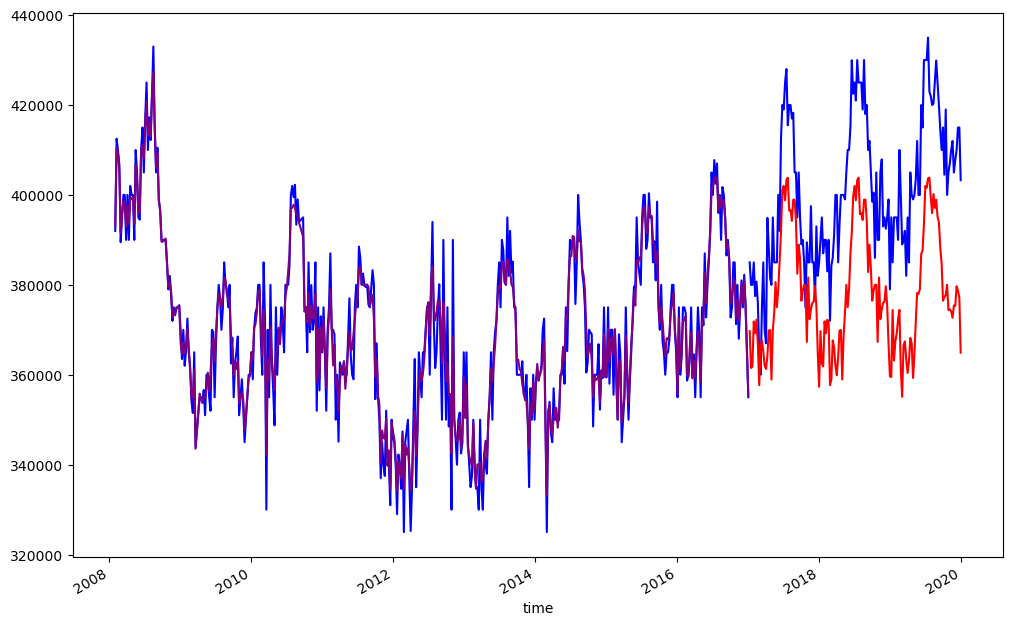

In [877]:
fig,ax = plt.subplots(figsize = (12,8))

nyc_train['Price'].plot(color = 'blue')
nyc_train['Predicted'].plot(color = 'purple')

nyc_test['Price'].plot(color = 'blue')
nyc_test['Predicted'].plot(color = 'red')



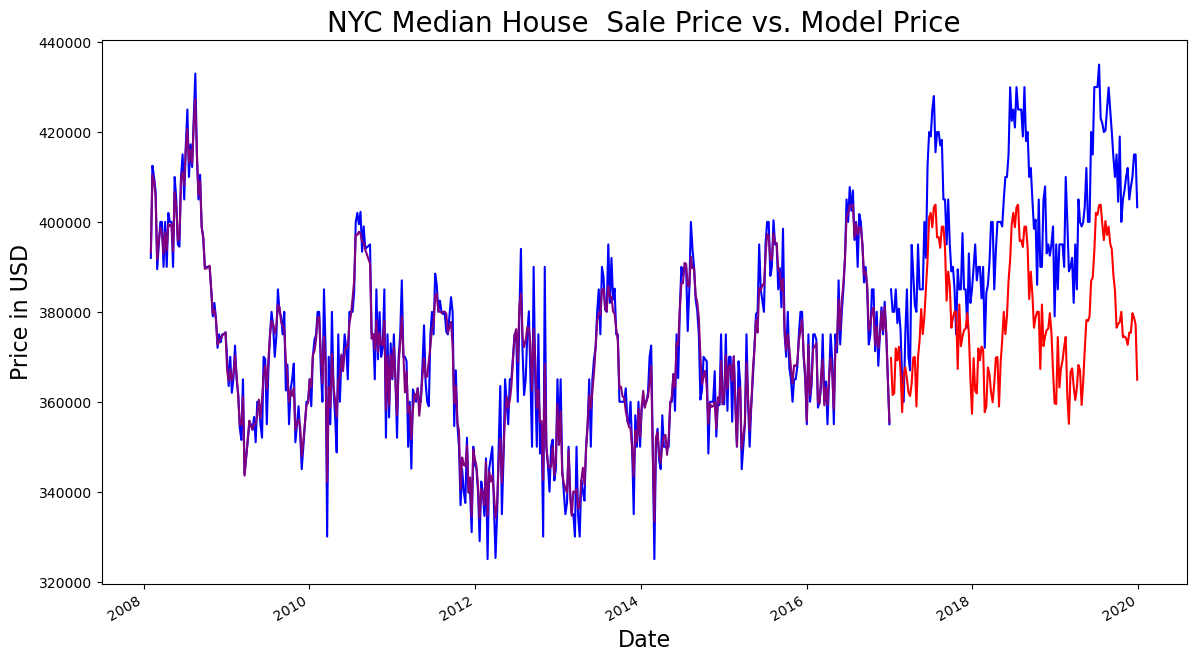

In [878]:
fig, ax = plt.subplots(figsize = (14,8))

nyc_train['Price'].plot(color = 'blue')
nyc_train['Predicted'].plot(color = 'purple')

nyc_test['Price'].plot(color = 'blue')
nyc_test['Predicted'].plot(color = 'red')


ax.set_title('NYC Median House  Sale Price vs. Model Price', fontsize = 20)

ax.set_xlabel('Date', fontsize = 16);
ax.set_ylabel('Price in USD', fontsize = 16)

plt.show();

In [808]:
nyc = data_ohe[data_ohe['RegionName'] == 'New York, NY']

nyc = date_features(nyc)

In [833]:
nyc_train = nyc.loc[nyc.index < '2020-01-01']
nyc_test = nyc.loc[(nyc.index >= '2020-01-01')]

In [834]:
nyc_train

RegionID  SizeRank    RegionName RegionType     Price  \
time                                                                
2008-02-02    394913         1  New York, NY        msa  392000.0   
2008-02-09    394913         1  New York, NY        msa  412500.0   
2008-02-16    394913         1  New York, NY        msa  410000.0   
2008-02-23    394913         1  New York, NY        msa  406850.0   
2008-03-01    394913         1  New York, NY        msa  389500.0   
...              ...       ...           ...        ...       ...   
2019-11-30    394913         1  New York, NY        msa  407750.0   
2019-12-07    394913         1  New York, NY        msa  410000.0   
2019-12-14    394913         1  New York, NY        msa  415000.0   
2019-12-21    394913         1  New York, NY        msa  415000.0   
2019-12-28    394913         1  New York, NY        msa  403275.0   

            StateName_AL  StateName_AR  StateName_AZ  StateName_CA  \
time                                                                 
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-09           0.0           0.0           0.0           0.0   
2008-02-16           0.0           0.0           0.0           0.0   
2008-02-23           0.0           0.0           0.0           0.0   
2008-03-01           0.0           0.0           0.0           0.0   
...                  ...           ...           ...           ...   
2019-11-30           0.0           0.0           0.0           0.0   
2019-12-07           0.0           0.0           0.0           0.0   
2019-12-14           0.0           0.0           0.0           0.0   
2019-12-21           0.0           0.0           0.0           0.0   
2019-12-28           0.0           0.0           0.0           0.0   

            StateName_CO  ...  StateName_TX  StateName_UT  StateName_VA  \
time                      ...                                             
2008-02-02           0.0  ...           0.0           0.0           0.0   
2008-02-09           0.0  ...           0.0           0.0           0.0   
2008-02-16           0.0  ...           0.0           0.0           0.0   
2008-02-23           0.0  ...           0.0           0.0           0.0   
2008-03-01           0.0  ...           0.0           0.0           0.0   
...                  ...  ...           ...           ...           ...   
2019-11-30           0.0  ...           0.0           0.0           0.0   
2019-12-07           0.0  ...           0.0           0.0           0.0   
2019-12-14           0.0  ...           0.0           0.0           0.0   
2019-12-21           0.0  ...           0.0           0.0           0.0   
2019-12-28           0.0  ...           0.0           0.0           0.0   

            StateName_WA  StateName_WI  StateName_USA  year  quarter  month  \
time                                                                          
2008-02-02           0.0           0.0            0.0  2008        1      2   
2008-02-09           0.0           0.0            0.0  2008        1      2   
2008-02-16           0.0           0.0            0.0  2008        1      2   
2008-02-23           0.0           0.0            0.0  2008        1      2   
2008-03-01           0.0           0.0            0.0  2008        1      3   
...                  ...           ...            ...   ...      ...    ...   
2019-11-30           0.0           0.0            0.0  2019        4     11   
2019-12-07           0.0           0.0            0.0  2019        4     12   
2019-12-14           0.0           0.0            0.0  2019        4     12   
2019-12-21           0.0           0.0            0.0  2019        4     12   
2019-12-28           0.0           0.0            0.0  2019        4     12   

            dayofyear  
time                   
2008-02-02         33  
2008-02-09         40  
2008-02-16         47  
2008-02-23         54  
2008-03-01         61  
...               ...  
2019-11

In [836]:
X_train_nyc = nyc_train[features]
y_train_nyc = nyc_train['Price']

X_test_nyc = nyc_test[features]
y_test_nyc = nyc_test['Price']

In [837]:
reg_2 = xgb.XGBRegressor(n_estimators=1000, learning_rate = .05)
reg_2.fit(X_train_nyc, y_train_nyc,
        eval_set=[(X_train_nyc, y_train_nyc), (X_test_nyc, y_test_nyc)],
        early_stopping_rounds=100,
       verbose=True)

[0]	validation_0-rmse:359601.93100	validation_1-rmse:479449.09033
[1]	validation_0-rmse:341725.20261	validation_1-rmse:461620.51373
[2]	validation_0-rmse:324744.73928	validation_1-rmse:444688.33240
[3]	validation_0-rmse:308616.01766	validation_1-rmse:428607.88222
[4]	validation_0-rmse:293294.11165	validation_1-rmse:412271.65221
[5]	validation_0-rmse:278738.65736	validation_1-rmse:396754.58265
[6]	validation_0-rmse:264911.61123	validation_1-rmse:382016.14626
[7]	validation_0-rmse:251776.83292	validation_1-rmse:368017.67439
[8]	validation_0-rmse:239300.00752	validation_1-rmse:354722.55304
[9]	validation_0-rmse:227448.51643	validation_1-rmse:342095.85150
[10]	validation_0-rmse:216191.38527	validation_1-rmse:330104.46130
[11]	validation_0-rmse:205499.19726	validation_1-rmse:318716.84311
[12]	validation_0-rmse:195343.99475	validation_1-rmse:307903.00213
[13]	validation_0-rmse:185697.80970	validation_1-rmse:297760.58027
[14]	validation_0-rmse:176536.23697	validation_1-rmse:288003.89602
[15]	

[125]	validation_0-rmse:5588.42819	validation_1-rmse:101249.29390
[126]	validation_0-rmse:5569.60949	validation_1-rmse:101229.15026
[127]	validation_0-rmse:5541.44801	validation_1-rmse:101196.99959
[128]	validation_0-rmse:5508.76561	validation_1-rmse:101166.12180
[129]	validation_0-rmse:5476.22699	validation_1-rmse:101135.92806
[130]	validation_0-rmse:5460.48980	validation_1-rmse:101119.94565
[131]	validation_0-rmse:5426.03278	validation_1-rmse:101089.90135
[132]	validation_0-rmse:5398.72626	validation_1-rmse:101064.09195
[133]	validation_0-rmse:5372.71830	validation_1-rmse:101039.39769


/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[134]	validation_0-rmse:5358.60999	validation_1-rmse:100997.78434
[135]	validation_0-rmse:5328.47809	validation_1-rmse:100967.62101
[136]	validation_0-rmse:5306.72683	validation_1-rmse:100946.08797
[137]	validation_0-rmse:5284.60796	validation_1-rmse:100926.33748
[138]	validation_0-rmse:5256.93963	validation_1-rmse:100897.76739
[139]	validation_0-rmse:5232.52172	validation_1-rmse:100872.90072
[140]	validation_0-rmse:5210.37329	validation_1-rmse:100853.80752
[141]	validation_0-rmse:5185.89752	validation_1-rmse:100830.85373
[142]	validation_0-rmse:5163.75763	validation_1-rmse:100810.54008
[143]	validation_0-rmse:5142.69165	validation_1-rmse:100781.59210
[144]	validation_0-rmse:5123.42562	validation_1-rmse:100771.48852
[145]	validation_0-rmse:5112.18649	validation_1-rmse:100755.17137
[146]	validation_0-rmse:5090.56918	validation_1-rmse:100735.51146
[147]	validation_0-rmse:5071.51381	validation_1-rmse:100710.98718
[148]	validation_0-rmse:5047.23332	validation_1-rmse:100690.66370
[149]	vali

[259]	validation_0-rmse:3799.20256	validation_1-rmse:100245.60654
[260]	validation_0-rmse:3790.20044	validation_1-rmse:100247.84114
[261]	validation_0-rmse:3775.75024	validation_1-rmse:100249.13669
[262]	validation_0-rmse:3761.10939	validation_1-rmse:100252.40725
[263]	validation_0-rmse:3752.41444	validation_1-rmse:100253.12208
[264]	validation_0-rmse:3742.70164	validation_1-rmse:100249.04953
[265]	validation_0-rmse:3736.89397	validation_1-rmse:100245.45401
[266]	validation_0-rmse:3724.32657	validation_1-rmse:100239.98938
[267]	validation_0-rmse:3710.43558	validation_1-rmse:100241.64343
[268]	validation_0-rmse:3702.15248	validation_1-rmse:100244.37706
[269]	validation_0-rmse:3693.28098	validation_1-rmse:100243.38204
[270]	validation_0-rmse:3690.81183	validation_1-rmse:100244.57612
[271]	validation_0-rmse:3685.42341	validation_1-rmse:100241.93676
[272]	validation_0-rmse:3671.70359	validation_1-rmse:100243.18476
[273]	validation_0-rmse:3663.94570	validation_1-rmse:100244.74246
[274]	vali

[384]	validation_0-rmse:2897.09933	validation_1-rmse:100153.29125
[385]	validation_0-rmse:2892.41672	validation_1-rmse:100152.88963
[386]	validation_0-rmse:2885.54318	validation_1-rmse:100155.43614
[387]	validation_0-rmse:2880.14877	validation_1-rmse:100151.28207
[388]	validation_0-rmse:2875.49344	validation_1-rmse:100151.38376
[389]	validation_0-rmse:2870.77480	validation_1-rmse:100149.78440
[390]	validation_0-rmse:2866.49494	validation_1-rmse:100148.56542
[391]	validation_0-rmse:2861.08126	validation_1-rmse:100147.98947
[392]	validation_0-rmse:2858.67839	validation_1-rmse:100147.51373
[393]	validation_0-rmse:2855.88299	validation_1-rmse:100146.20090
[394]	validation_0-rmse:2851.61373	validation_1-rmse:100145.80084
[395]	validation_0-rmse:2850.11935	validation_1-rmse:100145.73892
[396]	validation_0-rmse:2847.68973	validation_1-rmse:100143.74366
[397]	validation_0-rmse:2846.00462	validation_1-rmse:100144.56001
[398]	validation_0-rmse:2840.20722	validation_1-rmse:100145.77178
[399]	vali

[509]	validation_0-rmse:2379.33566	validation_1-rmse:100067.24772
[510]	validation_0-rmse:2376.33097	validation_1-rmse:100066.84859
[511]	validation_0-rmse:2373.09305	validation_1-rmse:100068.77531
[512]	validation_0-rmse:2368.59811	validation_1-rmse:100067.89688
[513]	validation_0-rmse:2362.94018	validation_1-rmse:100066.18135
[514]	validation_0-rmse:2362.12049	validation_1-rmse:100066.66816
[515]	validation_0-rmse:2358.88493	validation_1-rmse:100063.68634
[516]	validation_0-rmse:2356.21310	validation_1-rmse:100065.19256
[517]	validation_0-rmse:2355.43618	validation_1-rmse:100065.65883
[518]	validation_0-rmse:2349.17198	validation_1-rmse:100068.72796
[519]	validation_0-rmse:2343.82999	validation_1-rmse:100066.14986
[520]	validation_0-rmse:2340.43963	validation_1-rmse:100066.50312
[521]	validation_0-rmse:2334.41061	validation_1-rmse:100065.86577
[522]	validation_0-rmse:2331.57804	validation_1-rmse:100065.93826
[523]	validation_0-rmse:2327.88524	validation_1-rmse:100065.47500
[524]	vali

[634]	validation_0-rmse:1961.26195	validation_1-rmse:100015.63701
[635]	validation_0-rmse:1955.91198	validation_1-rmse:100016.47870
[636]	validation_0-rmse:1954.44504	validation_1-rmse:100013.69962
[637]	validation_0-rmse:1950.40895	validation_1-rmse:100011.24761
[638]	validation_0-rmse:1948.55727	validation_1-rmse:100011.28260
[639]	validation_0-rmse:1943.47267	validation_1-rmse:100012.35348
[640]	validation_0-rmse:1941.50386	validation_1-rmse:100011.70369
[641]	validation_0-rmse:1940.00307	validation_1-rmse:100008.96788
[642]	validation_0-rmse:1935.60424	validation_1-rmse:100010.95689
[643]	validation_0-rmse:1930.80710	validation_1-rmse:100011.99545
[644]	validation_0-rmse:1925.47791	validation_1-rmse:100013.10628
[645]	validation_0-rmse:1920.44818	validation_1-rmse:100014.41646
[646]	validation_0-rmse:1918.57240	validation_1-rmse:100015.15469
[647]	validation_0-rmse:1914.68519	validation_1-rmse:100013.81911
[648]	validation_0-rmse:1912.89985	validation_1-rmse:100014.44112
[649]	vali

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [838]:
nyc_train['Predicted'] = reg_2.predict(X_train_nyc)
nyc_test['Predicted'] = reg_2.predict(X_test_nyc)

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1256/2814559478.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_train['Predicted'] = reg_2.predict(X_train_nyc)
/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1256/2814559478.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_test['Predicted'] = reg_2.predict(X_test_nyc)


<Axes: xlabel='time'>

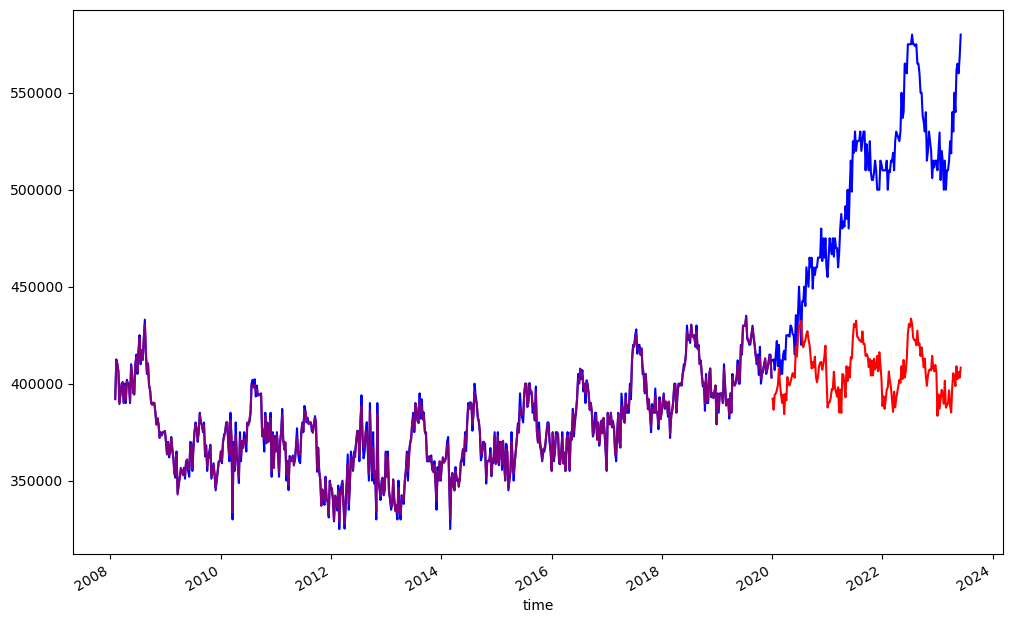

In [839]:
fig,ax = plt.subplots(figsize = (12,8))

nyc_train['Price'].plot(color = 'blue')
nyc_train['Predicted'].plot(color = 'purple')

nyc_test['Price'].plot(color = 'blue')
nyc_test['Predicted'].plot(color = 'red')

Top Metro Areas

In [781]:
top_5 = list(data_ohe.iloc[1:6, :]['RegionName'])

In [787]:
nyc_data = data_ohe[data_ohe['RegionName'] == top_5[0]]

In [789]:
la_data = data_ohe[data_ohe['RegionName'] == top_5[1]]

In [843]:
df_weekly['ROI'] = ((df_weekly['2023-06-03'] - df_weekly['2008-02-02'])/df_weekly['2008-02-02'])*100

In [1348]:
df_csv = df_weekly.sort_values('ROI', ascending = False).head(20)

In [1349]:
df_csv

RegionID  SizeRank        RegionName RegionType StateName  2008-02-02  \
35     394902        37     Nashville, TN        msa        TN    142000.0   
4      394514         4        Dallas, TX        msa        TX    137550.0   
18     394530        19        Denver, CO        msa        CO    217250.0   
95     394997       105      Portland, ME        msa        ME    202750.0   
107    394746       120       Killeen, TX        msa        TX    100000.0   
73     394399        79    Boise City, ID        msa        ID    188000.0   
57     394653        61    Greenville, SC        msa        SC    126288.0   
28     394355        29        Austin, TX        msa        TX    189950.0   
32     394705        34  Indianapolis, IN        msa        IN    113001.0   
80     394931        87         Ogden, UT        msa        UT    185750.0   
60     394753        65     Knoxville, TN        msa        TN    138000.0   
22     394458        23     Charlotte, NC        msa        NC    156000.0   
93     394460       102   Chattanooga, TN        msa        TN    116000.0   
145    394747       167     Kingsport, TN        msa        TN     92000.0   
105    395116       118   Springfield, MO        msa        MO    109900.0   
98     394590       108  Fayetteville, AR        msa        AR    139000.0   
5      394692         5       Houston, TX        msa        TX    136200.0   
87     394549        95        Durham, NC        msa        NC    178500.0   
40     395012        43       Raleigh, NC        msa        NC    172250.0   
144    394579       165    Evansville, IN        msa        IN     90000.0   

     2008-02-09  2008-02-16  2008-02-23  2008-03-01  ...  2023-04-08  \
35     155000.0    144000.0    146000.0    150136.0  ...    393950.0   
4      124950.0    140080.0    136000.0    138000.0  ...    385000.0   
18     215000.0    220000.0    225000.0    230000.0  ...    581750.0   
95     203750.0    225000.0    205000.0    224750.0  ...    517500.0   
107     99000.0     95500.0     99500.0    113450.0  ...    260000.0   
73     187000.0    176000.0    184000.0    180000.0  ...    450000.0   
57     109500.0    121000.0    125500.0    131500.0  ...    294500.0   
28     182500.0    181850.0    170475.0    180500.0  ...    487821.0   
32     119000.0    111950.0    102750.0    120500.0  ...    265000.0   
80     175450.0    174950.0    183850.0    183000.0  ...    447000.0   
60     121900.0    123500.0    129500.0    147800.0  ...    315000.0   
22     145000.0    145000.0    159000.0    152500.0  ...    360000.0   
93     110000.0    131750.0    134900.0    134750.0  ...    249950.0   
145     78125.0     99500.0    112518.0    105000.0  ...    180000.0   
105    114000.0    124500.0    125900.0    119900.0  ...    235000.0   
98     145500.0    155000.0    158650.0    155000.0  ...    292000.0   
5      136500.0    143000.0    142750.0    148000.0  ...    320000.0   
87     174500.0    148000.0    164000.0    175000.0  ...    380000.0   
40     161500.0    187500.0    177500.0    178000.0  ...    385000.0   
144    120000.0    111750.0     93300.0    102000.0  ...    205500.0   

     2023-04-15  2023-04-22  2023-04-29  2023-05-06  2023-05-13  2023-05-20  \
35     412495.0    398750.0    423000.0    409900.0    440000.0    400000.0   
4      379250.0    385000.0    390000.0    390000.0    389000.0    405000.0   
18     580000.0    596000.0    581000.0    575000.0    610000.0    595000.0   
95     482000.0    482500.0    474950.0    438750.0    447500.0    475000.0   
107    246500.0    270000.0    247500.0    264500.0    259500.0    260000.0   
73     446000.0    484000.0    449900.0    451000.0    469900.0    483000.0   
57     289900.0    267250.0    300000.0    303500.0    305345.0    305950.0   
28     470500.0    495000.0    472000.0    464250.0    482000.0    477000.0   
32     250000.0    270000.0    260000.0    284000.0    262750.0    278250.0   
80     441500.0    461750.0    435000.0    440000.0    434000.0

In [1353]:
df_csv.to_csv('to_20')

In [853]:
data_ohe

RegionID  SizeRank             RegionName RegionType     Price  \
time                                                                         
2008-02-02    102001         0          United States    country  184169.0   
2008-02-02    394913         1           New York, NY        msa  392000.0   
2008-02-02    753899         2        Los Angeles, CA        msa  475000.0   
2008-02-02    394463         3            Chicago, IL        msa  239500.0   
2008-02-02    394514         4             Dallas, TX        msa  137550.0   
...              ...       ...                    ...        ...       ...   
2023-06-03    394917       282              Niles, MI        msa  339500.0   
2023-06-03    394685       289  Homosassa Springs, FL        msa  266150.0   
2023-06-03    394442       321         Carbondale, IL        msa  132950.0   
2023-06-03    394890       327       Mount Vernon, WA        msa  530000.0   
2023-06-03    395098       335       Sierra Vista, AZ        msa  241950.0   

            StateName_AL  StateName_AR  StateName_AZ  StateName_CA  \
time                                                                 
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-02           0.0           0.0           0.0           1.0   
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-02           0.0           0.0           0.0           0.0   
...                  ...           ...           ...           ...   
2023-06-03           0.0           0.0           0.0           0.0   
2023-06-03           0.0           0.0           0.0           0.0   
2023-06-03           0.0           0.0           0.0           0.0   
2023-06-03           0.0           0.0           0.0           0.0   
2023-06-03           0.0           0.0           1.0           0.0   

            StateName_CO  ...  StateName_PA  StateName_RI  StateName_SC  \
time                      ...                                             
2008-02-02           0.0  ...           0.0           0.0           0.0   
2008-02-02           0.0  ...           0.0           0.0           0.0   
2008-02-02           0.0  ...           0.0           0.0           0.0   
2008-02-02           0.0  ...           0.0           0.0           0.0   
2008-02-02           0.0  ...           0.0           0.0           0.0   
...                  ...  ...           ...           ...           ...   
2023-06-03           0.0  ...           0.0           0.0           0.0   
2023-06-03           0.0  ...           0.0           0.0           0.0   
2023-06-03           0.0  ...           0.0           0.0           0.0   
2023-06-03           0.0  ...           0.0           0.0           0.0   
2023-06-03           0.0  ...           0.0           0.0           0.0   

            StateName_TN  StateName_TX  StateName_UT  StateName_VA  \
time                                                                 
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-02           0.0           1.0           0.0           0.0   
...                  ...           ...           ...           ...   
2023-06-03           0.0           0.0           0.0           0.0   
2023-06-03           0.0           0.0           0.0           0.0   
2023-06-03           0.0           0.0           0.0           0.0   
2023-06-03           0.0           0.0           0.0           0.0   
2023-06-03           0.0           0.0           0.0           0.0   

            StateName_WA  StateName_WI  StateName_USA  
time                                                   
2008-02-02           0.0           0.0            1.0  
2008-02-02           0.0       

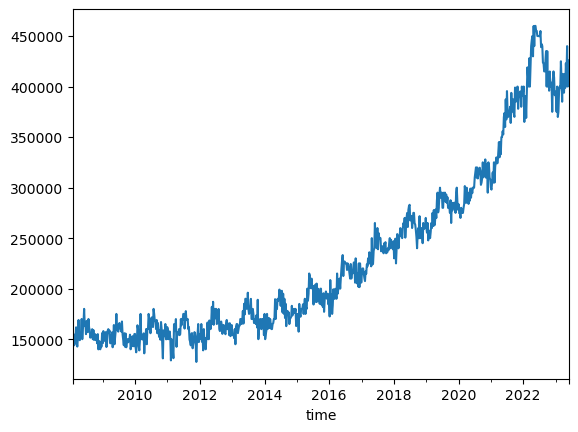

In [1404]:
nash = data_ohe[data_ohe['RegionName'] == 'Nashville, TN']['Price'].plot()

In [1143]:
nash = data_ohe[data_ohe['RegionName'] == 'Nashville, TN']

In [1144]:
nash

RegionID  SizeRank     RegionName RegionType     Price  \
time                                                                 
2008-02-02    394902        37  Nashville, TN        msa  142000.0   
2008-02-09    394902        37  Nashville, TN        msa  155000.0   
2008-02-16    394902        37  Nashville, TN        msa  144000.0   
2008-02-23    394902        37  Nashville, TN        msa  146000.0   
2008-03-01    394902        37  Nashville, TN        msa  150136.0   
...              ...       ...            ...        ...       ...   
2023-05-06    394902        37  Nashville, TN        msa  409900.0   
2023-05-13    394902        37  Nashville, TN        msa  440000.0   
2023-05-20    394902        37  Nashville, TN        msa  400000.0   
2023-05-27    394902        37  Nashville, TN        msa  425000.0   
2023-06-03    394902        37  Nashville, TN        msa  425750.0   

            StateName_AL  StateName_AR  StateName_AZ  StateName_CA  \
time                                                                 
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-09           0.0           0.0           0.0           0.0   
2008-02-16           0.0           0.0           0.0           0.0   
2008-02-23           0.0           0.0           0.0           0.0   
2008-03-01           0.0           0.0           0.0           0.0   
...                  ...           ...           ...           ...   
2023-05-06           0.0           0.0           0.0           0.0   
2023-05-13           0.0           0.0           0.0           0.0   
2023-05-20           0.0           0.0           0.0           0.0   
2023-05-27           0.0           0.0           0.0           0.0   
2023-06-03           0.0           0.0           0.0           0.0   

            StateName_CO  ...  StateName_PA  StateName_RI  StateName_SC  \
time                      ...                                             
2008-02-02           0.0  ...           0.0           0.0           0.0   
2008-02-09           0.0  ...           0.0           0.0           0.0   
2008-02-16           0.0  ...           0.0           0.0           0.0   
2008-02-23           0.0  ...           0.0           0.0           0.0   
2008-03-01           0.0  ...           0.0           0.0           0.0   
...                  ...  ...           ...           ...           ...   
2023-05-06           0.0  ...           0.0           0.0           0.0   
2023-05-13           0.0  ...           0.0           0.0           0.0   
2023-05-20           0.0  ...           0.0           0.0           0.0   
2023-05-27           0.0  ...           0.0           0.0           0.0   
2023-06-03           0.0  ...           0.0           0.0           0.0   

            StateName_TN  StateName_TX  StateName_UT  StateName_VA  \
time                                                                 
2008-02-02           1.0           0.0           0.0           0.0   
2008-02-09           1.0           0.0           0.0           0.0   
2008-02-16           1.0           0.0           0.0           0.0   
2008-02-23           1.0           0.0           0.0           0.0   
2008-03-01           1.0           0.0           0.0           0.0   
...                  ...           ...           ...           ...   
2023-05-06           1.0           0.0           0.0           0.0   
2023-05-13           1.0           0.0           0.0           0.0   
2023-05-20           1.0           0.0           0.0           0.0   
2023-05-27           1.0           0.0           0.0           0.0   
2023-06-03           1.0           0.0           0.0           0.0   

            StateName_WA  StateName_WI  StateName_USA  
time                                                   
2008-02-02           0.0           0.0            0.0  
2008-02-09           0.0           0.0            0.0  
2008-02-16           0.0           0.0            0.0  
2008-02-23           0.

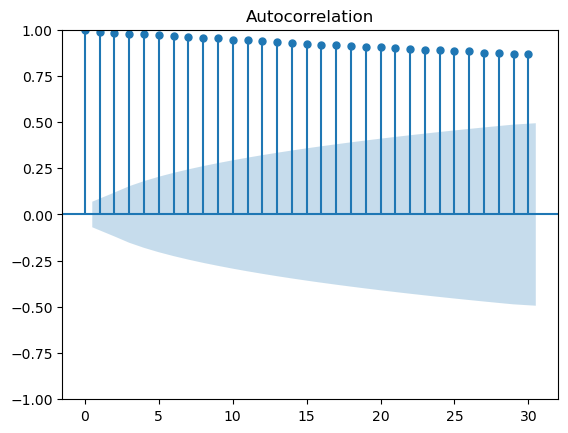

In [885]:
plot_acf(nash["Price"])
plt.show()

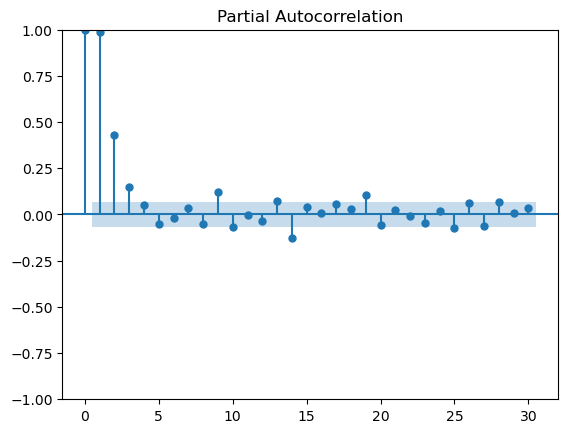

In [887]:
plot_pacf(nash["Price"])
plt.show()

## Diff

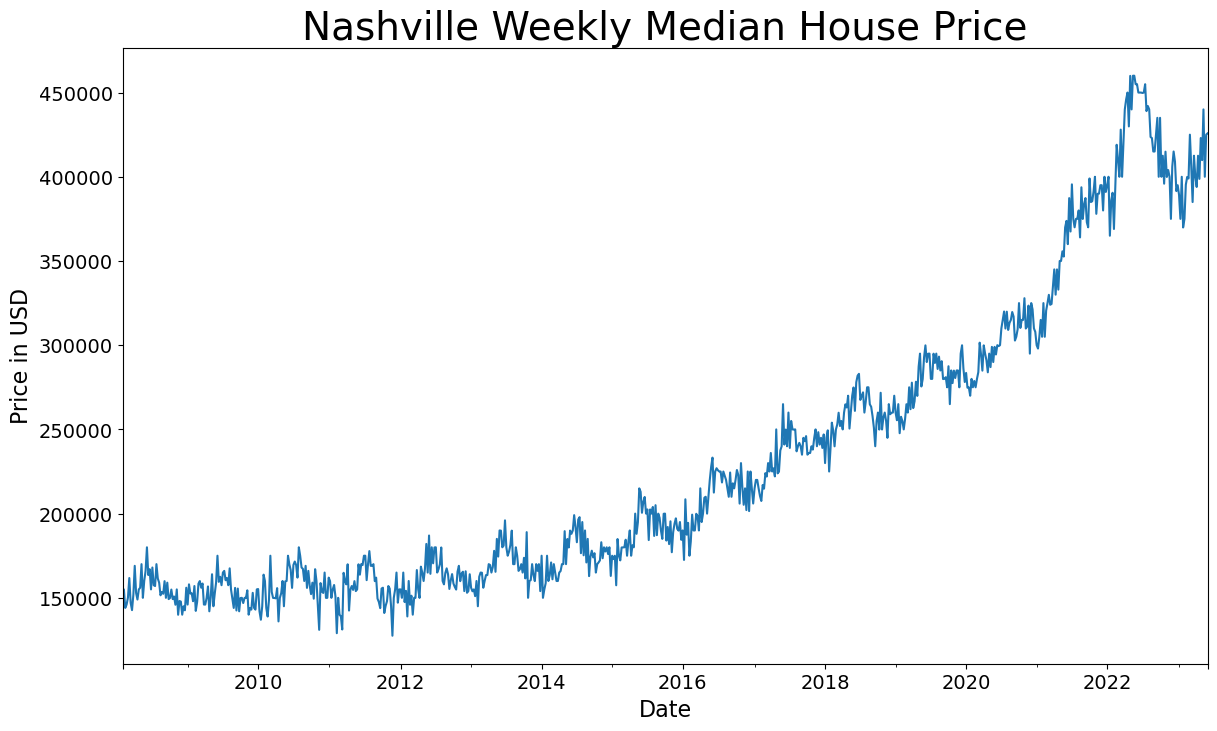

In [1341]:
fig, ax = plt.subplots(figsize = (14,8))

nash['Price'].plot(ax = ax)

ax.set_title('Nashville Weekly Median House Price', fontsize = 28)

ax.set_xlabel('Date', fontsize = 16);
ax.set_ylabel('Price in USD', fontsize = 16)
ax.tick_params(labelsize = 14)

plt.show();

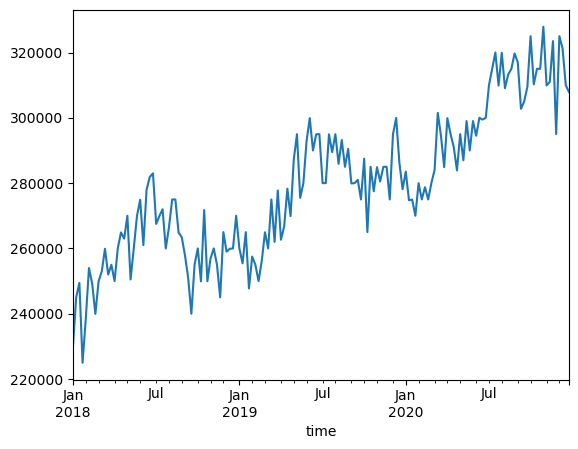

In [1124]:
nash['2018':'2020']['Price'].plot();

In [1243]:
nash_diff = nash['Price'].diff()

In [1231]:
X_diff = nash['Price'].diff(periods=6)

In [1234]:
nash['Price'].diff(periods=6)

time
2008-02-02        NaN
2008-02-09        NaN
2008-02-16        NaN
2008-02-23        NaN
2008-03-01        NaN
               ...   
2023-05-06    -2600.0
2023-05-13    40000.0
2023-05-20     6050.0
2023-05-27    12505.0
2023-06-03    27000.0
Name: Price, Length: 801, dtype: float64

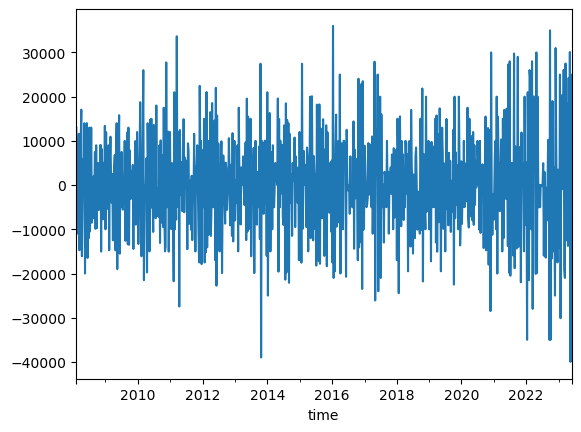

In [1244]:
nash_diff.plot();

In [1245]:
nash_diff

time
2008-02-02        NaN
2008-02-09    13000.0
2008-02-16   -11000.0
2008-02-23     2000.0
2008-03-01     4136.0
               ...   
2023-05-06   -13100.0
2023-05-13    30100.0
2023-05-20   -40000.0
2023-05-27    25000.0
2023-06-03      750.0
Name: Price, Length: 801, dtype: float64

In [1246]:
adfuller(nash_diff.dropna())

(-7.23337914203369,
 1.9680097463060046e-10,
 12,
 787,
 {'1%': -3.438686413400388,
  '5%': -2.8652194721349424,
  '10%': -2.5687293001910008},
 16451.062599135894)

In [1247]:
train_nash = X_diff[:'2018-12-31']
test_nash = X_diff['2019':]

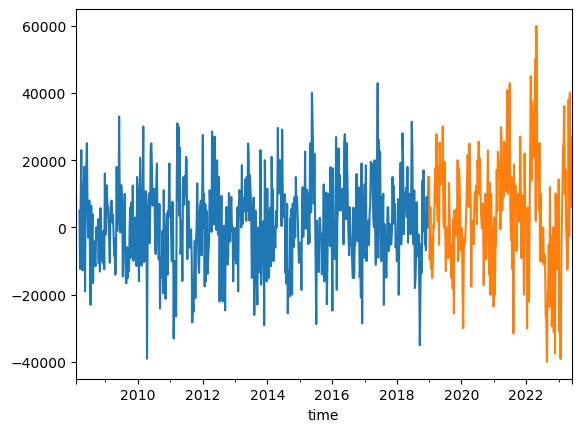

In [1248]:
train_nash.plot()
test_nash.plot();

In [1249]:
test_nash.shape[0] + train_nash.shape[0]

801

In [1271]:
model = ARIMA(train_nash, order = (1, 0, 1))
nash_model = model.fit()

/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)


In [1279]:
nash_model.forecast(300)

2019-01-05    3829.815310
2019-01-12    3281.658711
2019-01-19    2846.480821
2019-01-26    2500.995979
2019-02-02    2226.717854
                 ...     
2024-08-31    1170.237592
2024-09-07    1170.237592
2024-09-14    1170.237592
2024-09-21    1170.237592
2024-09-28    1170.237592
Freq: W-SAT, Name: predicted_mean, Length: 300, dtype: float64

In [1291]:
pred = nash_model.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)


SyntaxError: invalid syntax (976007424.py, line 1)

In [1283]:
pred_ci = pred.conf_int() 

In [1289]:
pred_ci

lower Price   upper Price
2019-01-05 -19988.716799  27648.347419

TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[float64]'>)

<Figure size 1500x800 with 0 Axes>

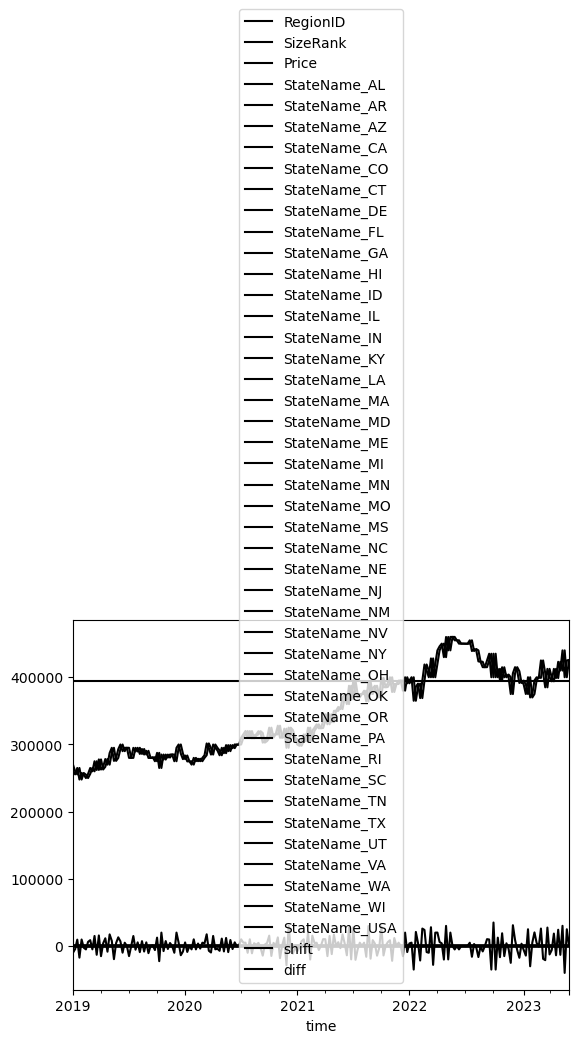

In [1288]:
plt.figure(figsize = (15,8))
ax = nash['2019':].plot(label='observed',color='black')
pred.predicted_mean.plot(ax=ax, label='Forecast', color='red',alpha=0.8)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=0.5)

ax.set_title('Dynamic Forecast from 2015-2018')
ax.set_xlabel('Date')
ax.set_ylabel('Amount')
plt.legend()

plt.show()


In [1272]:
train_nash.shape

(570,)

In [1273]:
prediction = nash_model.predict(0, 800)

<Axes: >

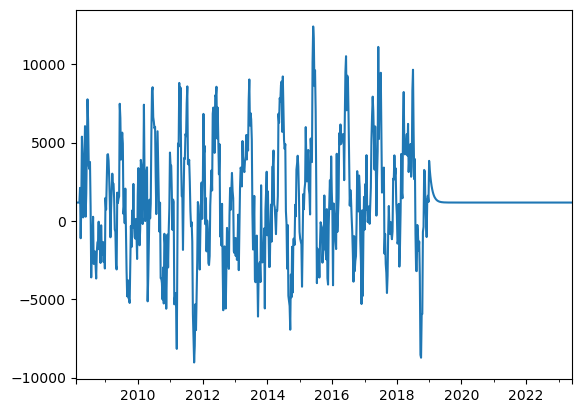

In [1274]:
prediction.plot()

<Axes: xlabel='time'>

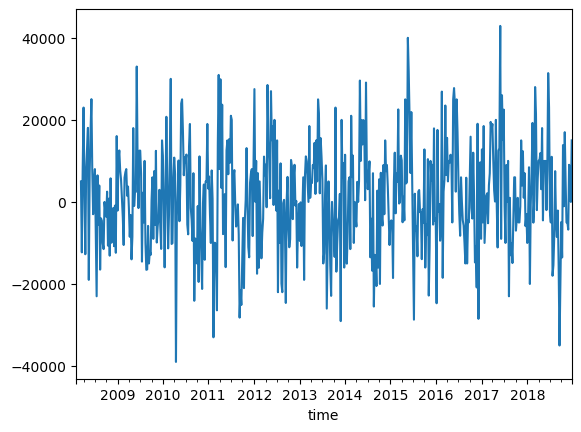

In [1254]:
train_nash.plot()

In [1131]:
df = pd.DataFrame({'A': np.random.randint(0, 10, 10)})
df['B'] = df['A'].diff()

x, x_diff = df['A'].iloc[0], df['B'].iloc[1:]
df['C'] = np.r_[x, x_diff].cumsum().astype(int)

In [1134]:
nash

RegionID  SizeRank     RegionName RegionType     Price  \
time                                                                 
2008-02-02    394902        37  Nashville, TN        msa  142000.0   
2008-02-09    394902        37  Nashville, TN        msa  155000.0   
2008-02-16    394902        37  Nashville, TN        msa  144000.0   
2008-02-23    394902        37  Nashville, TN        msa  146000.0   
2008-03-01    394902        37  Nashville, TN        msa  150136.0   
...              ...       ...            ...        ...       ...   
2023-05-06    394902        37  Nashville, TN        msa  409900.0   
2023-05-13    394902        37  Nashville, TN        msa  440000.0   
2023-05-20    394902        37  Nashville, TN        msa  400000.0   
2023-05-27    394902        37  Nashville, TN        msa  425000.0   
2023-06-03    394902        37  Nashville, TN        msa  425750.0   

            StateName_AL  StateName_AR  StateName_AZ  StateName_CA  \
time                                                                 
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-09           0.0           0.0           0.0           0.0   
2008-02-16           0.0           0.0           0.0           0.0   
2008-02-23           0.0           0.0           0.0           0.0   
2008-03-01           0.0           0.0           0.0           0.0   
...                  ...           ...           ...           ...   
2023-05-06           0.0           0.0           0.0           0.0   
2023-05-13           0.0           0.0           0.0           0.0   
2023-05-20           0.0           0.0           0.0           0.0   
2023-05-27           0.0           0.0           0.0           0.0   
2023-06-03           0.0           0.0           0.0           0.0   

            StateName_CO  ...  StateName_PA  StateName_RI  StateName_SC  \
time                      ...                                             
2008-02-02           0.0  ...           0.0           0.0           0.0   
2008-02-09           0.0  ...           0.0           0.0           0.0   
2008-02-16           0.0  ...           0.0           0.0           0.0   
2008-02-23           0.0  ...           0.0           0.0           0.0   
2008-03-01           0.0  ...           0.0           0.0           0.0   
...                  ...  ...           ...           ...           ...   
2023-05-06           0.0  ...           0.0           0.0           0.0   
2023-05-13           0.0  ...           0.0           0.0           0.0   
2023-05-20           0.0  ...           0.0           0.0           0.0   
2023-05-27           0.0  ...           0.0           0.0           0.0   
2023-06-03           0.0  ...           0.0           0.0           0.0   

            StateName_TN  StateName_TX  StateName_UT  StateName_VA  \
time                                                                 
2008-02-02           1.0           0.0           0.0           0.0   
2008-02-09           1.0           0.0           0.0           0.0   
2008-02-16           1.0           0.0           0.0           0.0   
2008-02-23           1.0           0.0           0.0           0.0   
2008-03-01           1.0           0.0           0.0           0.0   
...                  ...           ...           ...           ...   
2023-05-06           1.0           0.0           0.0           0.0   
2023-05-13           1.0           0.0           0.0           0.0   
2023-05-20           1.0           0.0           0.0           0.0   
2023-05-27           1.0           0.0           0.0           0.0   
2023-06-03           1.0           0.0           0.0           0.0   

            StateName_WA  StateName_WI  StateName_USA  
time                                                   
2008-02-02           0.0           0.0            0.0  
2008-02-09           0.0           0.0            0.0  
2008-02-16           0.0           0.0            0.0  
2008-02-23           0.

In [1150]:
nash_price = nash['Price']

In [1160]:
nash['shift'] = nash['Price'].shift()

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1256/2660383552.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nash['shift'] = nash['Price'].shift()


In [1162]:
nash['diff'] =  nash['Price'] - nash['shift']

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1256/291058997.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nash['diff'] =  nash['Price'] - nash['shift']


<Axes: xlabel='time'>

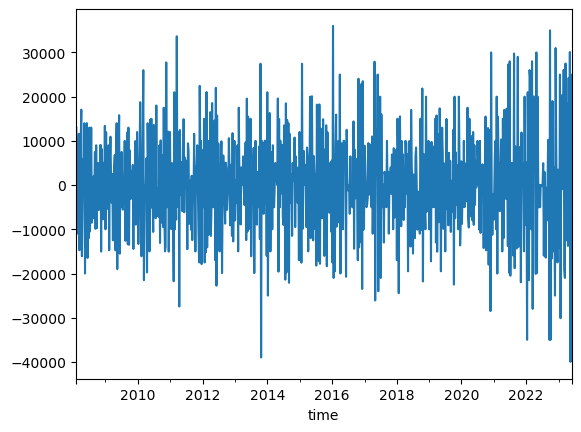

In [1255]:
nash['diff'] .plot()

In [1261]:
nash_price = pd.DataFrame(nash['Price'])

In [1262]:
nash_price['diff'] = nash['Price'].diff()

In [1263]:
nash_price

Price     diff
time                         
2008-02-02  142000.0      NaN
2008-02-09  155000.0  13000.0
2008-02-16  144000.0 -11000.0
2008-02-23  146000.0   2000.0
2008-03-01  150136.0   4136.0
...              ...      ...
2023-05-06  409900.0 -13100.0
2023-05-13  440000.0  30100.0
2023-05-20  400000.0 -40000.0
2023-05-27  425000.0  25000.0
2023-06-03  425750.0    750.0

[801 rows x 2 columns]

In [1264]:
x, x_diff = nash_price['Price'].iloc[0], nash_price['diff'].iloc[1:]
nash_price['C'] = np.r_[x, x_diff].cumsum().astype(int)

In [1265]:
nash_price

Price     diff       C
time                                 
2008-02-02  142000.0      NaN  142000
2008-02-09  155000.0  13000.0  155000
2008-02-16  144000.0 -11000.0  144000
2008-02-23  146000.0   2000.0  146000
2008-03-01  150136.0   4136.0  150136
...              ...      ...     ...
2023-05-06  409900.0 -13100.0  409900
2023-05-13  440000.0  30100.0  440000
2023-05-20  400000.0 -40000.0  400000
2023-05-27  425000.0  25000.0  425000
2023-06-03  425750.0    750.0  425750

[801 rows x 3 columns]

In [1172]:
model_diff = ARIMA(nash['diff'], order = (1, 0, 1))
model_fit_diff = model_diff.fit()

yhat = model_fit_diff.forecast()[0]

/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)


In [1190]:
model_fit_diff.resid

time
2008-02-02             NaN
2008-02-09    12645.312508
2008-02-16    -4378.609188
2008-02-23    -3011.327562
2008-03-01     2698.194689
                  ...     
2023-05-06     1372.530672
2023-05-13    27279.306923
2023-05-20   -19823.250683
2023-05-27     5340.026413
2023-06-03     8819.426915
Length: 801, dtype: float64

                               SARIMAX Results                                
Dep. Variable:                   diff   No. Observations:                  801
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -8468.364
Date:                Thu, 13 Jul 2023   AIC                          16944.727
Time:                        22:47:04   BIC                          16963.471
Sample:                    02-02-2008   HQIC                         16951.927
                         - 06-03-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        354.6875    137.719      2.575      0.010      84.764     624.611
ar.L1         -0.2340      0.046     -5.046      0.000      -0.325      -0.143
ma.L1         -0.4975      0.040    -12.351      0.0

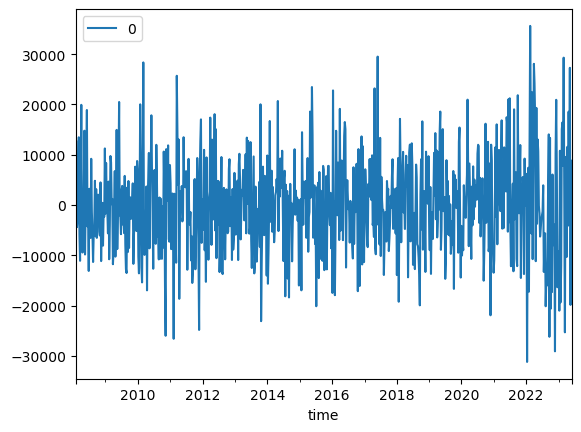

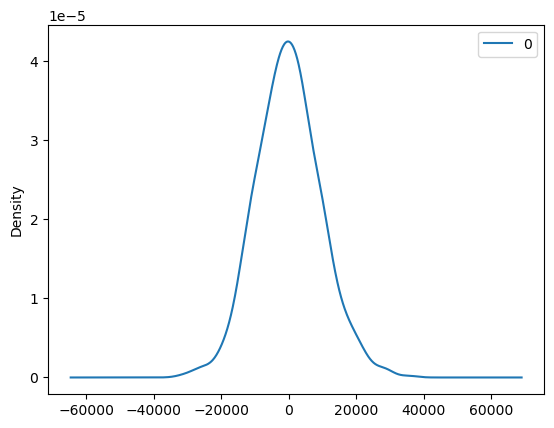

                  0
count    800.000000
mean     -16.312792
std     9577.666228
min   -31154.987973
25%    -6251.943537
50%     -122.779884
75%     5960.082402
max    35605.591250


In [1193]:
# summary of fit model
print(model_fit_diff.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit_diff.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [1195]:
nash['Price'][:'2019']

time
2008-02-02    142000.0
2008-02-09    155000.0
2008-02-16    144000.0
2008-02-23    146000.0
2008-03-01    150136.0
                ...   
2019-11-30    275000.0
2019-12-07    295000.0
2019-12-14    299950.0
2019-12-21    286290.0
2019-12-28    278152.0
Name: Price, Length: 622, dtype: float64

In [1199]:
len(test)

231

In [1202]:
train

time
2008-02-02    142000.0
2008-02-09    155000.0
2008-02-16    144000.0
2008-02-23    146000.0
2008-03-01    150136.0
                ...   
2018-12-01    265000.0
2018-12-08    259000.0
2018-12-15    259900.0
2018-12-22    260000.0
2018-12-29    270000.0
Name: Price, Length: 570, dtype: float64

In [1295]:
train = nash['Price'][:'2018-12-31']
test = nash['Price']['2019':]

In [1297]:
auto_model = pm.auto_arima(train, start_p=0, start_q=0,
                     test='adf',
                     max_p=5, max_q=5,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False, verbose = True)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=15460.559, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=15053.248, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=11990.641, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=11983.512, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=12045.077, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=11992.836, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=11980.940, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=14958.987, Time=0.03 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=11980.092, Time=0.08 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=14934.477, Time=0.03 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=11981.995, Time=0.16 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=11970.833, Time=0.14 sec
 ARIMA(0,0,4)(0,0,0)[0]        

In [1298]:
auto_model.order


(3, 0, 5)

In [1299]:
auto_model.seasonal_order


(0, 0, 0, 0)

/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03987D+01    |proj g|=  2.55067D-01

At iterate    5    f=  1.03769D+01    |proj g|=  9.56650D-02

At iterate   10    f=  1.03687D+01    |proj g|=  8.06024D-03

At iterate   15    f=  1.03682D+01    |proj g|=  1.35377D-02

At iterate   20    f=  1.03678D+01    |proj g|=  3.78190D-02

At iterate   25    f=  1.03663D+01    |proj g|=  2.39180D-02

At iterate   30    f=  1.03655D+01    |proj g|=  7.71038D-02

At iterate   35    f=  1.03655D+01    |proj g|=  1.93718D-01

At iterate   40    f=  1.03653D+01    |proj g|=  2.38834D-01

At iterate   45    f=  1.03652D+01    |proj g|=  5.64615D-03


/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.03652D+01    |proj g|=  3.98952D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     64      1     0     0   3.990D-03   1.037D+01
  F =   10.365229409312168     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1277      0.262      4.301      0.000       0.614       1.642
ar.L2         -0.1875      0.304     -0.617      0.537      -0.783       0.408
ar.L3          0.0607      0.247      0.246  

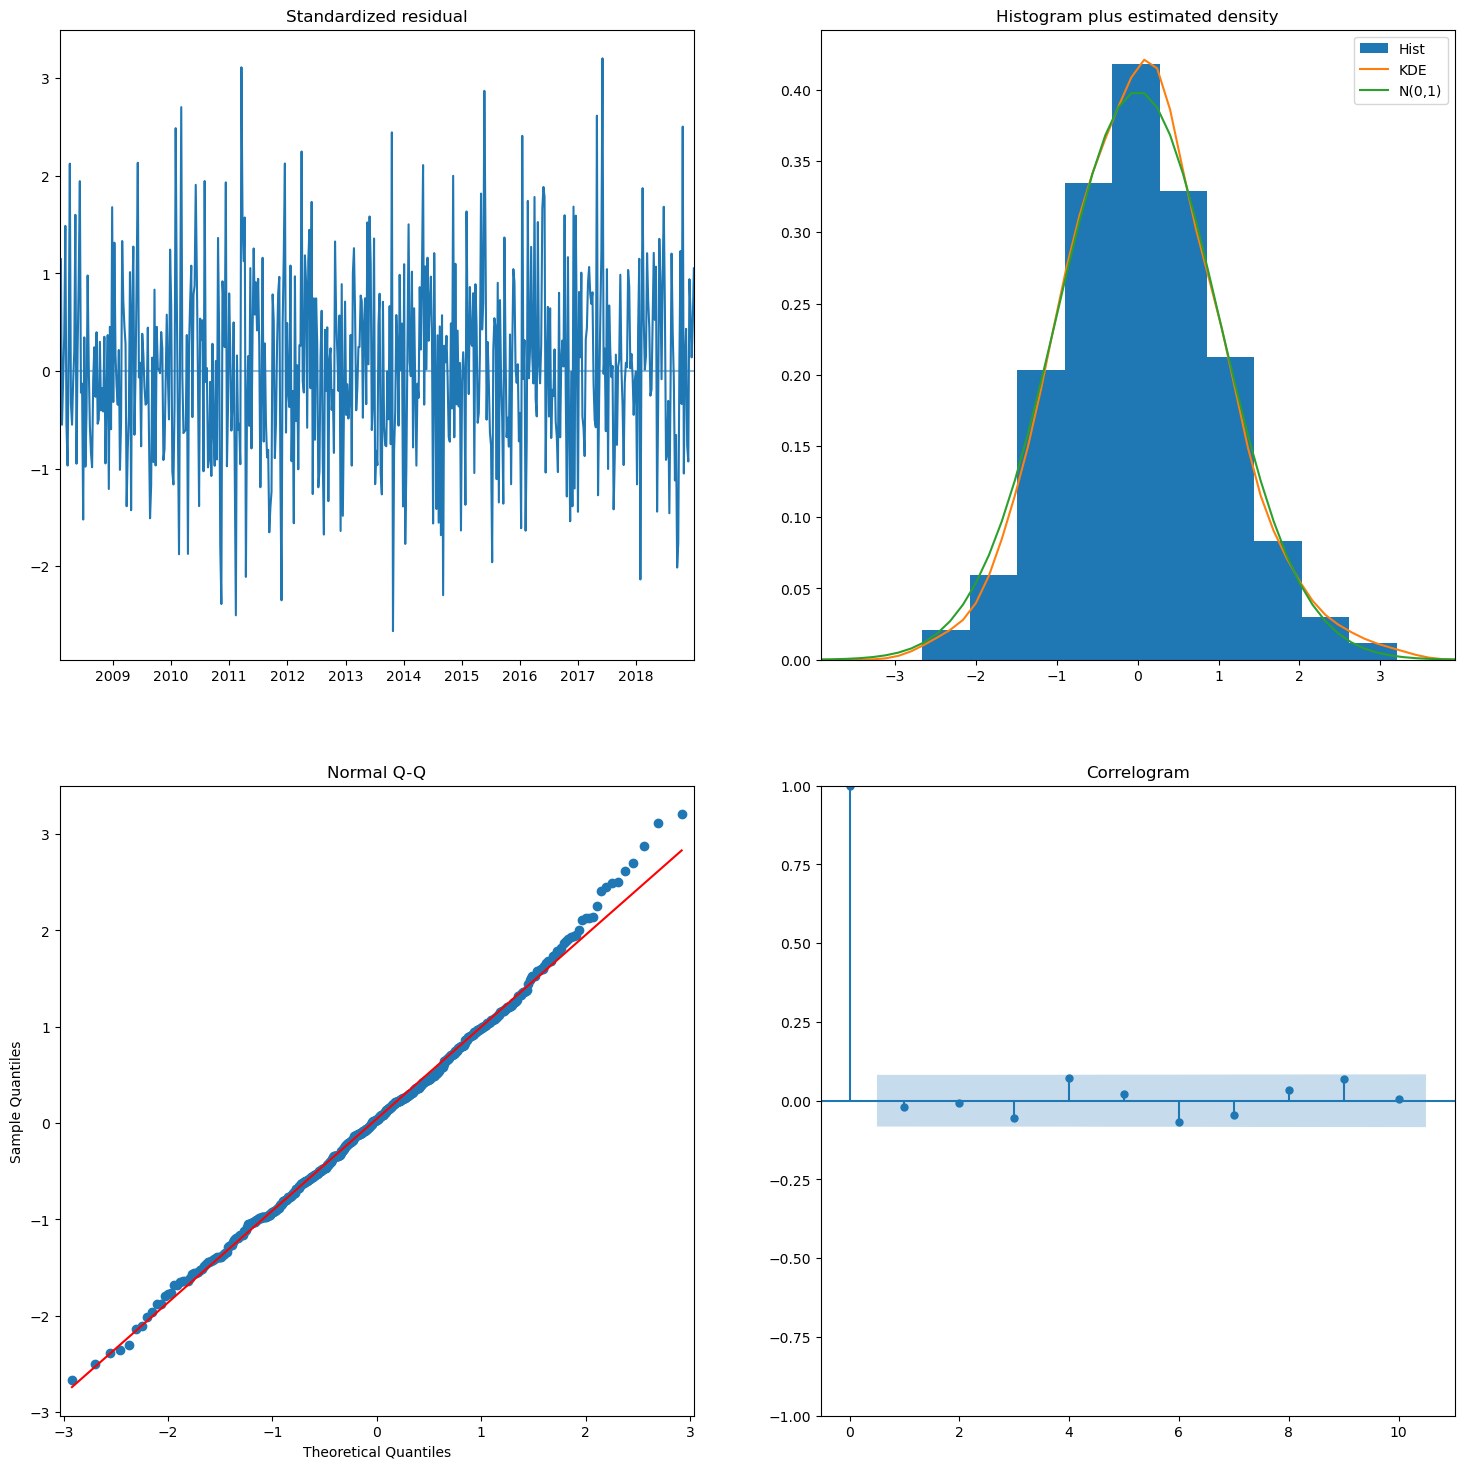

In [1306]:
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(train, 
                                        order=(3, 0, 5), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()


In [1325]:
forecast = output.get_forecast(231)
future_prediction = forecast.conf_int()
future_prediction['value'] = forecast.predicted_mean
future_prediction.columns = ['lower','upper','prediction'] 
future_prediction

lower          upper     prediction
2019-01-05  247013.788247  280624.230628  263819.009437
2019-01-12  247239.931480  281916.540038  264578.235759
2019-01-19  246543.013210  283280.528045  264911.770628
2019-01-26  247341.506490  285547.380873  266444.443681
2019-02-02  244632.524160  286699.792952  265666.158556
...                   ...            ...            ...
2023-05-06  222075.029651  442117.402765  332096.216208
2023-05-13  222113.995509  442748.269174  332431.132342
2023-05-20  222153.496126  443379.276345  332766.386235
2023-05-27  222193.529067  444010.427392  333101.978230
2023-06-03  222234.091930  444641.725402  333437.908666

[231 rows x 3 columns]

In [1309]:
# Get predictions and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2019-01-01'), end=pd.to_datetime('2023-06-03'), dynamic=False)
pred_conf = pred.conf_int()
pred_conf


lower Price    upper Price
2019-01-05  247013.788247  280624.230628
2019-01-12  247239.931480  281916.540038
2019-01-19  246543.013210  283280.528045
2019-01-26  247341.506490  285547.380873
2019-02-02  244632.524160  286699.792952
...                   ...            ...
2023-05-06  222075.029651  442117.402765
2023-05-13  222113.995509  442748.269174
2023-05-20  222153.496126  443379.276345
2023-05-27  222193.529067  444010.427392
2023-06-03  222234.091930  444641.725402

[231 rows x 2 columns]

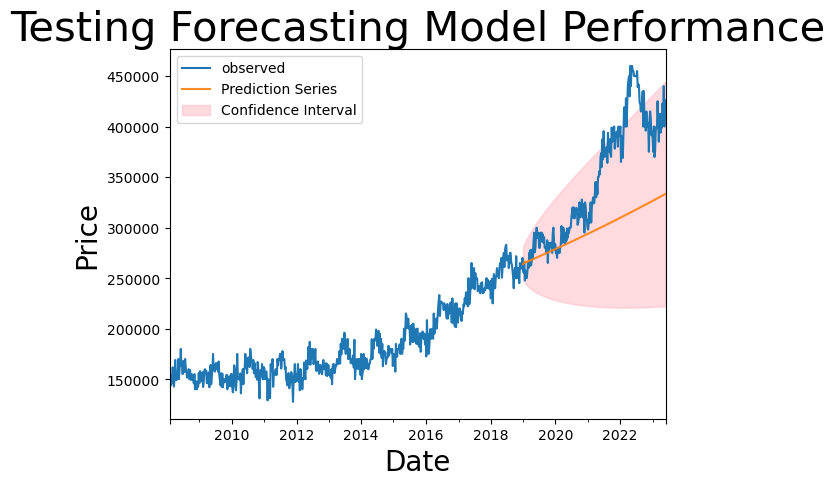

In [1312]:
# Plot real vs predicted values along with confidence interval

# Plot observed values
ax = nash['Price'].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='Prediction Series', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='lightpink', alpha=0.5,label = 'Confidence Interval')

# Set axes labels
ax.set_xlabel('Date',fontsize=20)
ax.set_ylabel('Price',fontsize=20)
ax.set_title('Testing Forecasting Model Performance',fontsize=30)
plt.legend()

plt.show()

NameError: name 'future_prediction' is not defined

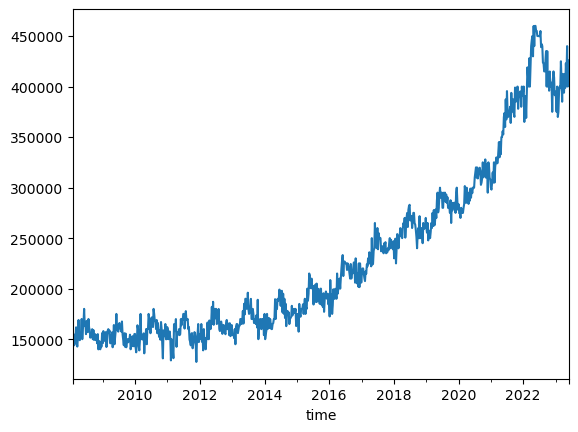

In [1314]:
#Plotting our Forecast

fig, ax = plt.subplots()
nash['Price'].plot(ax=ax,label='Real Values')


future_prediction['prediction'].plot(ax=ax,label='predicted value',ls='--')

ax.fill_between(x= future_prediction.index, y1= future_prediction['lower'], 
                y2= future_prediction['upper'],color='lightpink',
                label='Confidence Interval')
ax.legend() 
plt.ylabel("Average Price")
plt.title('Average Home Price - 33126 - With Forcasted Value & Confidence Intervals')
plt.show()

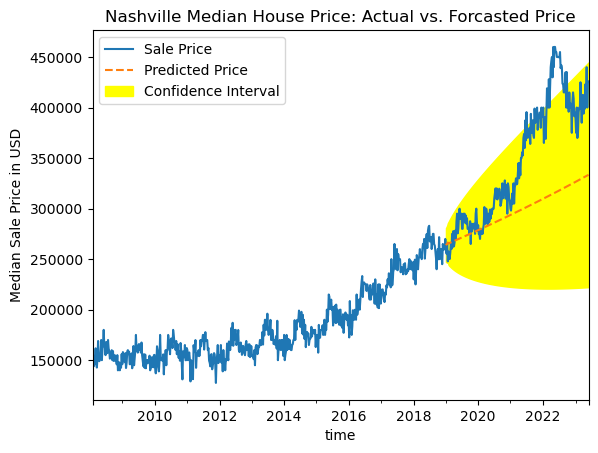

In [1332]:
#Plotting our Forecast

fig, ax = plt.subplots()
nash['Price'].plot(ax=ax,label='Sale Price')


future_prediction['prediction'].plot(ax=ax,label='Predicted Price',ls='--')

ax.fill_between(x= future_prediction.index, y1= future_prediction['lower'], 
                y2= future_prediction['upper'],color='yellow',
                label='Confidence Interval')
ax.legend() 
plt.ylabel("Median Sale Price in USD")
plt.title('Nashville Median House Price: Actual vs. Forcasted Price')
plt.show()

In [1371]:
nash

RegionID  SizeRank     RegionName RegionType     Price  \
time                                                                 
2008-02-02    394902        37  Nashville, TN        msa  142000.0   
2008-02-09    394902        37  Nashville, TN        msa  155000.0   
2008-02-16    394902        37  Nashville, TN        msa  144000.0   
2008-02-23    394902        37  Nashville, TN        msa  146000.0   
2008-03-01    394902        37  Nashville, TN        msa  150136.0   
...              ...       ...            ...        ...       ...   
2023-05-06    394902        37  Nashville, TN        msa  409900.0   
2023-05-13    394902        37  Nashville, TN        msa  440000.0   
2023-05-20    394902        37  Nashville, TN        msa  400000.0   
2023-05-27    394902        37  Nashville, TN        msa  425000.0   
2023-06-03    394902        37  Nashville, TN        msa  425750.0   

            StateName_AL  StateName_AR  StateName_AZ  StateName_CA  \
time                                                                 
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-09           0.0           0.0           0.0           0.0   
2008-02-16           0.0           0.0           0.0           0.0   
2008-02-23           0.0           0.0           0.0           0.0   
2008-03-01           0.0           0.0           0.0           0.0   
...                  ...           ...           ...           ...   
2023-05-06           0.0           0.0           0.0           0.0   
2023-05-13           0.0           0.0           0.0           0.0   
2023-05-20           0.0           0.0           0.0           0.0   
2023-05-27           0.0           0.0           0.0           0.0   
2023-06-03           0.0           0.0           0.0           0.0   

            StateName_CO  ...  StateName_SC  StateName_TN  StateName_TX  \
time                      ...                                             
2008-02-02           0.0  ...           0.0           1.0           0.0   
2008-02-09           0.0  ...           0.0           1.0           0.0   
2008-02-16           0.0  ...           0.0           1.0           0.0   
2008-02-23           0.0  ...           0.0           1.0           0.0   
2008-03-01           0.0  ...           0.0           1.0           0.0   
...                  ...  ...           ...           ...           ...   
2023-05-06           0.0  ...           0.0           1.0           0.0   
2023-05-13           0.0  ...           0.0           1.0           0.0   
2023-05-20           0.0  ...           0.0           1.0           0.0   
2023-05-27           0.0  ...           0.0           1.0           0.0   
2023-06-03           0.0  ...           0.0           1.0           0.0   

            StateName_UT  StateName_VA  StateName_WA  StateName_WI  \
time                                                                 
2008-02-02           0.0           0.0           0.0           0.0   
2008-02-09           0.0           0.0           0.0           0.0   
2008-02-16           0.0           0.0           0.0           0.0   
2008-02-23           0.0           0.0           0.0           0.0   
2008-03-01           0.0           0.0           0.0           0.0   
...                  ...           ...           ...           ...   
2023-05-06           0.0           0.0           0.0           0.0   
2023-05-13           0.0           0.0           0.0           0.0   
2023-05-20           0.0           0.0           0.0           0.0   
2023-05-27           0.0           0.0           0.0           0.0   
2023-06-03           0.0           0.0           0.0           0.0   

            StateName_USA     shift     diff  
time                                          
2008-02-02            0.0       NaN      NaN  
2008-02-09            0.0  142000.0  13000.0  
2008-02-16            0.0  155000.0 -11000.0  
2008-02-23            0.0  144000.0   2000.0  
2008-03-01           

In [1384]:
def date_features(df):
    """
    Data features for time series analysis
    """
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear

    return df

In [1403]:
date_features(nyc)

KeyError: 'time'

In [1400]:
date_features(nash)

KeyError: 'time'

In [1394]:
nash_price[['Price']]

Price
time                
2008-02-02  142000.0
2008-02-09  155000.0
2008-02-16  144000.0
2008-02-23  146000.0
2008-03-01  150136.0
...              ...
2023-05-06  409900.0
2023-05-13  440000.0
2023-05-20  400000.0
2023-05-27  425000.0
2023-06-03  425750.0

[801 rows x 1 columns]

In [1383]:
nash_price.rename( index ={'time': 'date'})

IndexError: too many indices for array

In [1377]:
nash_price = nash[['Price']]

In [1385]:
nash_price = date_features(nash_price)

KeyError: 'time'

In [1361]:
xgb_train = nash['Price'][:'2018-12-31'])
xgb_test =  nash['Price']['2019':])

In [1396]:
pd.DataFrame(xgb_train.index)

time
0   2008-02-02
1   2008-02-09
2   2008-02-16
3   2008-02-23
4   2008-03-01
..         ...
565 2018-12-01
566 2018-12-08
567 2018-12-15
568 2018-12-22
569 2018-12-29

[570 rows x 1 columns]

In [1398]:
X_train = xgb_train.index
y_train = xgb_train['Price']

X_test = xgb_test.index
y_test = xgb_test['Price']

XGB Regressor

In [1399]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:time: datetime64[ns]

In [1200]:
history = [x for x in train]


In [1201]:
history

[142000.0,
 155000.0,
 144000.0,
 146000.0,
 150136.0,
 161750.0,
 147000.0,
 142700.0,
 151950.0,
 169000.0,
 152900.0,
 149000.0,
 154950.0,
 156000.0,
 170000.0,
 150000.0,
 160000.0,
 166000.0,
 180000.0,
 163525.0,
 167000.0,
 155000.0,
 168000.0,
 157500.0,
 157000.0,
 170000.0,
 161500.0,
 159000.0,
 151500.0,
 153500.0,
 152400.0,
 159900.0,
 150000.0,
 159000.0,
 149250.0,
 149900.0,
 154900.0,
 149250.0,
 150792.0,
 145900.0,
 155000.0,
 139950.0,
 148108.0,
 147750.0,
 140000.0,
 145000.0,
 142600.0,
 156000.0,
 146000.0,
 158000.0,
 152550.0,
 152700.0,
 148000.0,
 157000.0,
 142250.0,
 147500.0,
 158450.0,
 159950.0,
 156000.0,
 158500.0,
 146000.0,
 146000.0,
 149950.0,
 156750.0,
 142000.0,
 150000.0,
 164000.0,
 145000.0,
 152500.0,
 159200.0,
 175000.0,
 159500.0,
 162500.0,
 157500.0,
 165000.0,
 166000.0,
 160450.0,
 161750.0,
 157500.0,
 167500.0,
 154900.0,
 149450.0,
 144000.0,
 155900.0,
 142500.0,
 155500.0,
 142000.0,
 149900.0,
 150000.0,
 146900.0,
 150000.0,

In [1203]:
    output = model_fit.forecast()
    yhat = output[0]


In [1204]:
yhat

417590.14470881864

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1256/1237778717.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime
/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


predicted=262287.658095, expected=260000.000000
predicted=261354.067895, expected=255450.000000
predicted=259186.812481, expected=265000.000000
predicted=261017.977288, expected=247750.000000
predicted=256340.968496, expected=257500.000000
predicted=256588.992041, expected=255000.000000
predicted=255892.665311, expected=250000.000000
predicted=253726.806051, expected=256200.000000
predicted=254417.481397, expected=264950.000000
predicted=258267.322686, expected=260000.000000
predicted=258440.125784, expected=275000.000000
predicted=263944.904263, expected=262000.000000
predicted=263134.519618, expected=277750.000000
predicted=268000.137942, expected=262675.000000
predicted=266030.963778, expected=266750.000000
predicted=266135.525328, expected=278300.000000
predicted=270156.055916, expected=269900.000000
predicted=269924.477666, expected=287250.000000
predicted=275744.722175, expected=295000.000000
predicted=282347.518072, expected=275500.000000
predicted=279814.279762, expected=279950

predicted=438524.867123, expected=429900.000000
predicted=435101.497921, expected=459900.000000
predicted=444589.830652, expected=440000.000000
predicted=442750.382730, expected=460000.000000
predicted=449339.308867, expected=460000.000000
predicted=453426.607598, expected=454950.000000
predicted=453961.784174, expected=455000.000000
predicted=454304.035687, expected=450000.000000
predicted=452580.766701, expected=450000.000000
predicted=451524.504019, expected=450000.000000
predicted=450876.007228, expected=449750.000000
predicted=450381.298995, expected=450000.000000
predicted=450174.261684, expected=454950.000000
predicted=451958.894179, expected=439000.000000
predicted=446896.159004, expected=442000.000000
predicted=444941.696415, expected=440000.000000
predicted=442966.043838, expected=423600.000000
predicted=435366.837489, expected=423000.000000
predicted=430432.712279, expected=415000.000000
predicted=424235.643138, expected=415000.000000
predicted=420468.907929, expected=425250

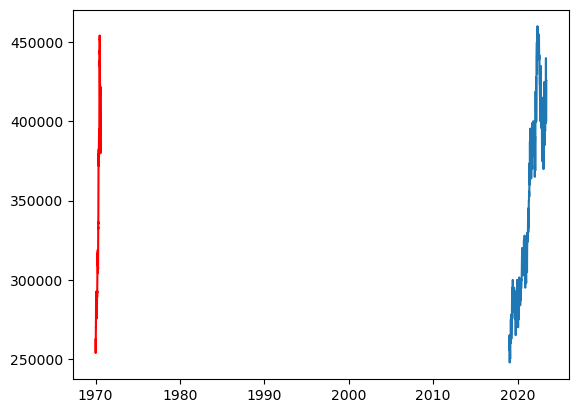

In [1197]:
# evaluate an ARIMA model using a walk-forward validation
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
# load dataset

# split into train and test sets

train, test = nash['Price'][:'2018-12-31'], nash['Price']['2019':]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(1,0,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [1188]:
model_fit_diff

In [1173]:
yhat

-4125.0842767613585

In [1151]:
nash_price_diff = nash_price.diff()

In [1135]:
nash_diff

time
2008-02-02        NaN
2008-02-09    13000.0
2008-02-16   -11000.0
2008-02-23     2000.0
2008-03-01     4136.0
               ...   
2023-05-06   -13100.0
2023-05-13    30100.0
2023-05-20   -40000.0
2023-05-27    25000.0
2023-06-03      750.0
Name: Price, Length: 801, dtype: float64

In [1185]:
x

time
2008-02-09    155000.0
2008-02-16    144000.0
2008-02-23    146000.0
2008-03-01    150136.0
2008-03-08    161750.0
                ...   
2023-05-06    409900.0
2023-05-13    440000.0
2023-05-20    400000.0
2023-05-27    425000.0
2023-06-03    425750.0
Name: Price, Length: 800, dtype: float64

In [1186]:
x_diff

time
2008-02-16   -11000.0
2008-02-23     2000.0
2008-03-01     4136.0
2008-03-08    11614.0
2008-03-15   -14750.0
               ...   
2023-05-06   -13100.0
2023-05-13    30100.0
2023-05-20   -40000.0
2023-05-27    25000.0
2023-06-03      750.0
Name: Price, Length: 799, dtype: float64

In [1184]:
np.r_[x[0], x_diff].cumsum()


array([155000., 144000., 146000., 150136., 161750., 147000., 142700.,
       151950., 169000., 152900., 149000., 154950., 156000., 170000.,
       150000., 160000., 166000., 180000., 163525., 167000., 155000.,
       168000., 157500., 157000., 170000., 161500., 159000., 151500.,
       153500., 152400., 159900., 150000., 159000., 149250., 149900.,
       154900., 149250., 150792., 145900., 155000., 139950., 148108.,
       147750., 140000., 145000., 142600., 156000., 146000., 158000.,
       152550., 152700., 148000., 157000., 142250., 147500., 158450.,
       159950., 156000., 158500., 146000., 146000., 149950., 156750.,
       142000., 150000., 164000., 145000., 152500., 159200., 175000.,
       159500., 162500., 157500., 165000., 166000., 160450., 161750.,
       157500., 167500., 154900., 149450., 144000., 155900., 142500.,
       155500., 142000., 149900., 150000., 146900., 150000., 149900.,
       154450., 140000., 144000., 143000., 152950., 144000., 143000.,
       155000., 1552

In [1146]:
nash['Price'][1:]

time
2008-02-09    155000.0
2008-02-16    144000.0
2008-02-23    146000.0
2008-03-01    150136.0
2008-03-08    161750.0
                ...   
2023-05-06    409900.0
2023-05-13    440000.0
2023-05-20    400000.0
2023-05-27    425000.0
2023-06-03    425750.0
Name: Price, Length: 800, dtype: float64

In [1139]:
nash_diff.iloc[:]

time
2008-02-09    13000.0
2008-02-16   -11000.0
2008-02-23     2000.0
2008-03-01     4136.0
2008-03-08    11614.0
               ...   
2023-05-06   -13100.0
2023-05-13    30100.0
2023-05-20   -40000.0
2023-05-27    25000.0
2023-06-03      750.0
Name: Price, Length: 800, dtype: float64

In [1187]:
x, x_diff  = nash['Price'][1:], nash_diff.iloc[1:]
df['C'] = np.r_[x, x_diff].cumsum().astype(int)

ValueError: Length of values (1599) does not match length of index (10)

In [1269]:
predictions = nash_model.predict(start=len(train_nash), end=len(nash_diff)-1)

In [1270]:
predictions

2019-01-05    3829.815310
2019-01-12    3281.658711
2019-01-19    2846.480821
2019-01-26    2500.995979
2019-02-02    2226.717854
                 ...     
2023-05-06    1170.237592
2023-05-13    1170.237592
2023-05-20    1170.237592
2023-05-27    1170.237592
2023-06-03    1170.237592
Freq: W-SAT, Name: predicted_mean, Length: 231, dtype: float64

In [1119]:
X_diff_inv = pm.utils.diff_inv(train_nash, lag=1)[1:]


In [1072]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  570
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -5972.338
Date:                Thu, 13 Jul 2023   AIC                          11952.677
Time:                        17:40:08   BIC                          11970.059
Sample:                    02-02-2008   HQIC                         11959.459
                         - 12-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        224.9560    131.921      1.705      0.088     -33.605     483.517
ar.L1         -0.1726      0.063     -2.729      0.006      -0.297      -0.049
ma.L1         -0.5797      0.051    -11.313      0.000      -0.680      -0.479
sigma2       7.64e+07      0.000   1.86e+11      0.000    7.64e+07    7.64e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.52
Prob(Q):                              0.93   Prob(JB):                         0.10
Heteroskedasticity (H):               1.06   Skew:                             0.16
Prob(H) (two-sided):                  0.67   Kurtosis:                         3.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.88e+27. Standard errors may be unstable.
"""

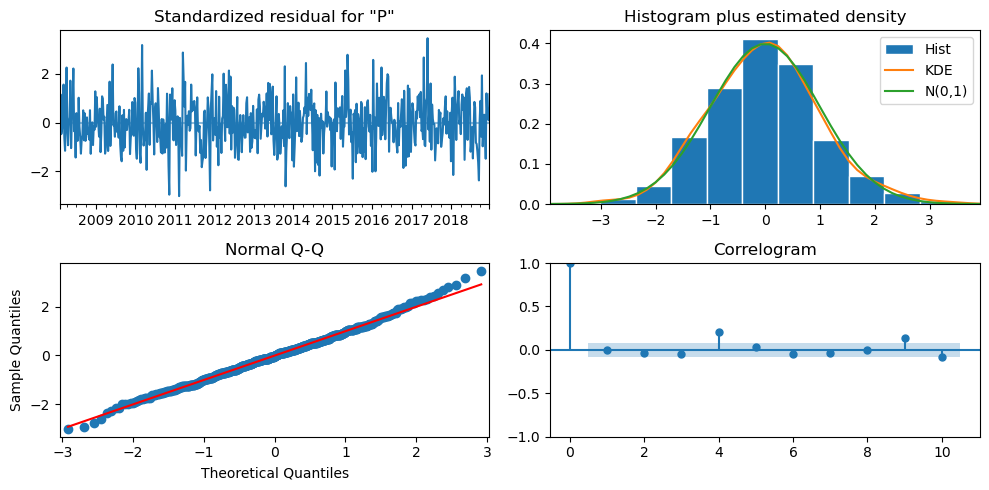

In [1073]:
results.plot_diagnostics(figsize = (10,5))
plt.tight_layout()
plt.show()

In [1074]:
modl = pm.auto_arima(train_nash, start_p=1, start_q=4,
                     max_p=4, max_q=4, d= 0, trace=True, stepwise=True, suppress_warnings=True,
                     error_action='ignore')

Performing stepwise search to minimize aic
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=11937.278, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=12209.478, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=12022.703, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=11965.021, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12207.716, Time=0.02 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=11944.284, Time=0.07 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=11954.664, Time=0.10 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=11938.130, Time=0.09 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=11954.891, Time=0.05 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=11954.474, Time=0.09 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=11936.705, Time=0.06 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=11942.115, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=11954.431, Time=0.08 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=11937.856, Time=0.07 sec
 ARIMA(0,0,3)(0,0,0

In [1051]:
n_train = train_nash.shape[0]


In [1054]:
n_train = train_nash.shape[0]


sample = results.predict(2, n_train)

#get first 5 values in-sample
sample[0:6]

2008-02-16    -6662.788644
2008-02-23     4748.876034
2008-03-01      -94.373111
2008-03-08     -295.122884
2008-03-15   -10184.690629
2008-03-22     5210.171380
Freq: W-SAT, Name: predicted_mean, dtype: float64

In [1090]:
train_df = pd.DataFrame(train_nash.dropna())

In [1091]:
train_df

Price
time               
2008-02-09  13000.0
2008-02-16 -11000.0
2008-02-23   2000.0
2008-03-01   4136.0
2008-03-08  11614.0
...             ...
2018-12-01  20000.0
2018-12-08  -6000.0
2018-12-15    900.0
2018-12-22    100.0
2018-12-29  10000.0

[569 rows x 1 columns]

In [1102]:
train_df['reverse_diff'] = train_df['Price'].shift(1) + train_df['Price']


In [1103]:
train_df.dropna(inplace = True)

<Axes: xlabel='time'>

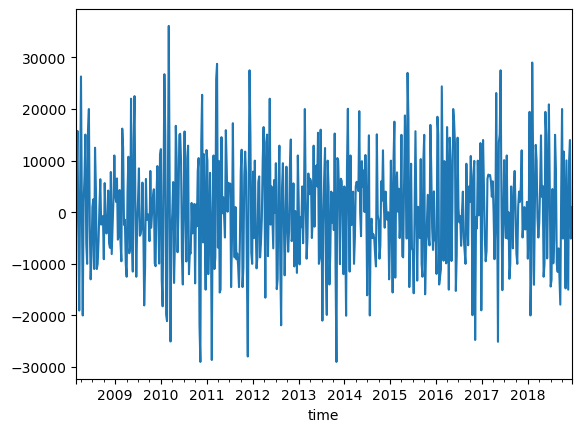

In [1106]:
train_df['reverse_diff'].plot()

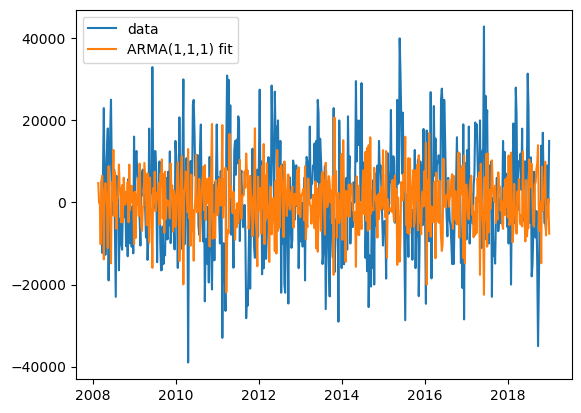

In [1266]:
fig, ax = plt.subplots()
ax.plot(train_nash, label = 'data')
ax.plot(sample[0::].shift(-1), 
        label = 'ARMA(1,1,1) fit')
ax.legend()

In [1267]:
results.forecast(800).head(40)

2019-01-05   -7407.204204
2019-01-12    1542.250280
2019-01-19      -2.406077
2019-01-26     264.198247
2019-02-02     218.182921
2019-02-09     226.125066
2019-02-16     224.754269
2019-02-23     224.990866
2019-03-02     224.950030
2019-03-09     224.957078
2019-03-16     224.955861
2019-03-23     224.956071
2019-03-30     224.956035
2019-04-06     224.956041
2019-04-13     224.956040
2019-04-20     224.956041
2019-04-27     224.956040
2019-05-04     224.956040
2019-05-11     224.956040
2019-05-18     224.956040
2019-05-25     224.956040
2019-06-01     224.956040
2019-06-08     224.956040
2019-06-15     224.956040
2019-06-22     224.956040
2019-06-29     224.956040
2019-07-06     224.956040
2019-07-13     224.956040
2019-07-20     224.956040
2019-07-27     224.956040
2019-08-03     224.956040
2019-08-10     224.956040
2019-08-17     224.956040
2019-08-24     224.956040
2019-08-31     224.956040
2019-09-07     224.956040
2019-09-14     224.956040
2019-09-21     224.956040
2019-09-28  

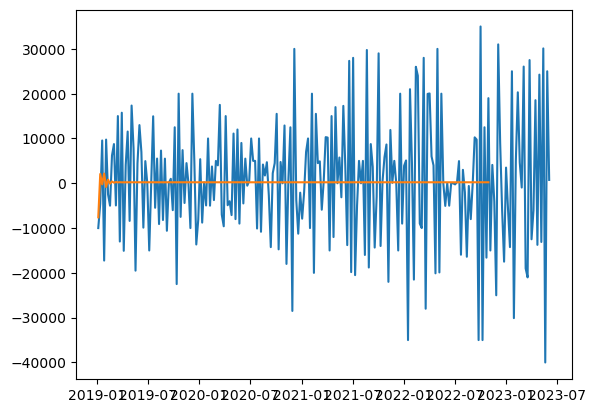

In [1067]:
plt.plot(test_nash)
plt.plot(results.forecast(200))

# Step 2: Data Preprocessing

In [448]:
top_row = data.iloc[:1]

In [449]:
label_cols = list(data.columns.values[:7])

In [450]:
df_melted = pd.melt(data, id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank'], value_vars=['1996-04', '1996-05', '1996-06', '1996-07', '1996-08',
       '1996-09', '1996-10', '1996-11', '1996-12', '1997-01', '1997-02',
       '1997-03', '1997-04', '1997-05', '1997-06', '1997-07', '1997-08',
       '1997-09', '1997-10', '1997-11', '1997-12', '1998-01', '1998-02',
       '1998-03', '1998-04', '1998-05', '1998-06', '1998-07', '1998-08',
       '1998-09', '1998-10', '1998-11', '1998-12', '1999-01', '1999-02',
       '1999-03', '1999-04', '1999-05', '1999-06', '1999-07', '1999-08',
       '1999-09', '1999-10', '1999-11', '1999-12', '2000-01', '2000-02',
       '2000-03', '2000-04', '2000-05', '2000-06', '2000-07', '2000-08',
       '2000-09', '2000-10', '2000-11', '2000-12', '2001-01', '2001-02',
       '2001-03', '2001-04', '2001-05', '2001-06', '2001-07', '2001-08',
       '2001-09', '2001-10', '2001-11', '2001-12', '2002-01', '2002-02',
       '2002-03', '2002-04', '2002-05', '2002-06', '2002-07', '2002-08',
       '2002-09', '2002-10', '2002-11', '2002-12', '2003-01', '2003-02',
       '2003-03', '2003-04', '2003-05', '2003-06', '2003-07', '2003-08',
       '2003-09', '2003-10', '2003-11', '2003-12', '2004-01', '2004-02',
       '2004-03', '2004-04', '2004-05', '2004-06', '2004-07', '2004-08',
       '2004-09', '2004-10', '2004-11', '2004-12', '2005-01', '2005-02',
       '2005-03', '2005-04', '2005-05', '2005-06', '2005-07', '2005-08',
       '2005-09', '2005-10', '2005-11', '2005-12', '2006-01', '2006-02',
       '2006-03', '2006-04', '2006-05', '2006-06', '2006-07', '2006-08',
       '2006-09', '2006-10', '2006-11', '2006-12', '2007-01', '2007-02',
       '2007-03', '2007-04', '2007-05', '2007-06', '2007-07', '2007-08',
       '2007-09', '2007-10', '2007-11', '2007-12', '2008-01', '2008-02',
       '2008-03', '2008-04', '2008-05', '2008-06', '2008-07', '2008-08',
       '2008-09', '2008-10', '2008-11', '2008-12', '2009-01', '2009-02',
       '2009-03', '2009-04', '2009-05', '2009-06', '2009-07', '2009-08',
       '2009-09', '2009-10', '2009-11', '2009-12', '2010-01', '2010-02',
       '2010-03', '2010-04', '2010-05', '2010-06', '2010-07', '2010-08',
       '2010-09', '2010-10', '2010-11', '2010-12', '2011-01', '2011-02',
       '2011-03', '2011-04', '2011-05', '2011-06', '2011-07', '2011-08',
       '2011-09', '2011-10', '2011-11', '2011-12', '2012-01', '2012-02',
       '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08',
       '2012-09', '2012-10', '2012-11', '2012-12', '2013-01', '2013-02',
       '2013-03', '2013-04', '2013-05', '2013-06', '2013-07', '2013-08',
       '2013-09', '2013-10', '2013-11', '2013-12', '2014-01', '2014-02',
       '2014-03', '2014-04', '2014-05', '2014-06', '2014-07', '2014-08',
       '2014-09', '2014-10', '2014-11', '2014-12', '2015-01', '2015-02',
       '2015-03', '2015-04', '2015-05', '2015-06', '2015-07', '2015-08',
       '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02',
       '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08',
       '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02',
       '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08',
       '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02',
       '2018-03', '2018-04'], var_name='Date', value_name='Price')

In [455]:
df_melted

RegionID  RegionName                 City State              Metro  \
0           84654       60657              Chicago    IL            Chicago   
1           90668       75070             McKinney    TX  Dallas-Fort Worth   
2           91982       77494                 Katy    TX            Houston   
3           84616       60614              Chicago    IL            Chicago   
4           93144       79936              El Paso    TX            El Paso   
...           ...         ...                  ...   ...                ...   
3901590     58333        1338             Ashfield    MA    Greenfield Town   
3901591     59107        3293            Woodstock    NH          Claremont   
3901592     75672       40404                Berea    KY           Richmond   
3901593     93733       81225  Mount Crested Butte    CO                NaN   
3901594     95851       89155             Mesquite    NV          Las Vegas   

        CountyName  SizeRank     Date     Price  
0             Cook         1  1996-04  334200.0  
1           Collin         2  1996-04  235700.0  
2           Harris         3  1996-04  210400.0  
3             Cook         4  1996-04  498100.0  
4          El Paso         5  1996-04   77300.0  
...            ...       ...      ...       ...  
3901590   Franklin     14719  2018-04  209300.0  
3901591    Grafton     14720  2018-04  225800.0  
3901592    Madison     14721  2018-04  133400.0  
3901593   Gunnison     14722  2018-04  664400.0  
3901594      Clark     14723  2018-04  357200.0  

[3901595 rows x 9 columns]

In [451]:
df_melted[df_melted['CountyName'] == 'Cook']

RegionID  RegionName        City State    Metro CountyName  SizeRank  \
0           84654       60657     Chicago    IL  Chicago       Cook         1   
3           84616       60614     Chicago    IL  Chicago       Cook         4   
7           84640       60640     Chicago    IL  Chicago       Cook         8   
16          84646       60647     Chicago    IL  Chicago       Cook        17   
19          84620       60618     Chicago    IL  Chicago       Cook        20   
...           ...         ...         ...   ...      ...        ...       ...   
3898107     84412       60163    Berkeley    IL  Chicago       Cook     11236   
3898460     84446       60203    Evanston    IL  Chicago       Cook     11589   
3899588     84414       60165  Stone Park    IL  Chicago       Cook     12717   
3900031     84527       60476    Thornton    IL  Chicago       Cook     13160   
3900524     84306       60043  Kenilworth    IL  Chicago       Cook     13653   

            Date      Price  
0        1996-04   334200.0  
3        1996-04   498100.0  
7        1996-04   216500.0  
16       1996-04   122700.0  
19       1996-04   142600.0  
...          ...        ...  
3898107  2018-04   180100.0  
3898460  2018-04   402000.0  
3899588  2018-04   156000.0  
3900031  2018-04   102400.0  
3900524  2018-04  1358300.0  

[37100 rows x 9 columns]

In [105]:
df_melted

RegionID  RegionName                 City State              Metro  \
0           84654       60657              Chicago    IL            Chicago   
1           90668       75070             McKinney    TX  Dallas-Fort Worth   
2           91982       77494                 Katy    TX            Houston   
3           84616       60614              Chicago    IL            Chicago   
4           93144       79936              El Paso    TX            El Paso   
...           ...         ...                  ...   ...                ...   
3901590     58333        1338             Ashfield    MA    Greenfield Town   
3901591     59107        3293            Woodstock    NH          Claremont   
3901592     75672       40404                Berea    KY           Richmond   
3901593     93733       81225  Mount Crested Butte    CO                NaN   
3901594     95851       89155             Mesquite    NV          Las Vegas   

        CountyName  SizeRank     Date     Price  
0             Cook         1  1996-04  334200.0  
1           Collin         2  1996-04  235700.0  
2           Harris         3  1996-04  210400.0  
3             Cook         4  1996-04  498100.0  
4          El Paso         5  1996-04   77300.0  
...            ...       ...      ...       ...  
3901590   Franklin     14719  2018-04  209300.0  
3901591    Grafton     14720  2018-04  225800.0  
3901592    Madison     14721  2018-04  133400.0  
3901593   Gunnison     14722  2018-04  664400.0  
3901594      Clark     14723  2018-04  357200.0  

[3901595 rows x 9 columns]

In [106]:
df_mean = df_melted.groupby(['Date']).mean()

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1256/705390131.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_mean = df_melted.groupby(['Date']).mean()


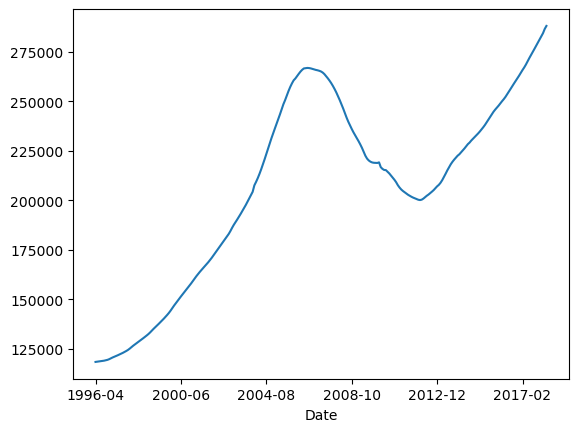

In [107]:
df_mean["Price"].plot();

In [108]:
from statsmodels.graphics.tsaplots import plot_acf

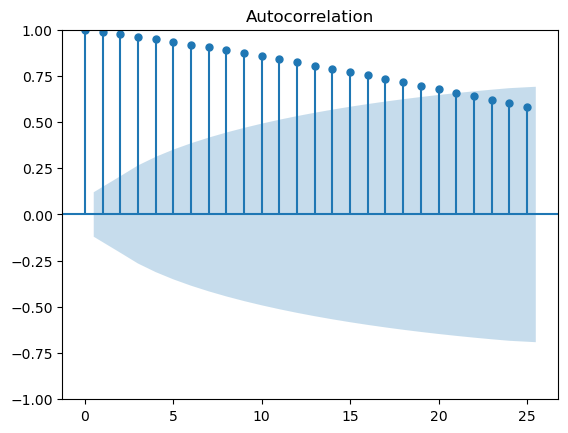

In [109]:
plot_acf(df_mean["Price"])
plt.show()

In [110]:
from statsmodels.tsa.stattools import pacf 
from statsmodels.graphics.tsaplots import plot_pacf

/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


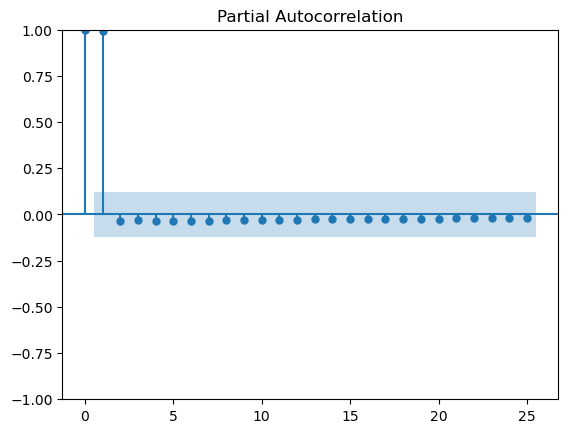

In [111]:
plot_pacf(df_mean["Price"])
plt.show()

In [112]:
df_mean_diff = df_mean['Price'].diff()

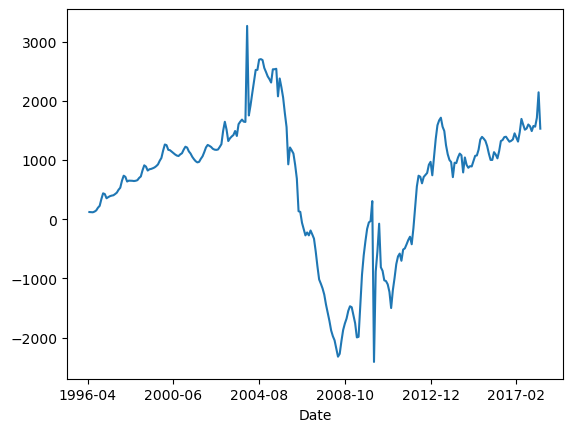

In [113]:
df_mean_diff.plot();

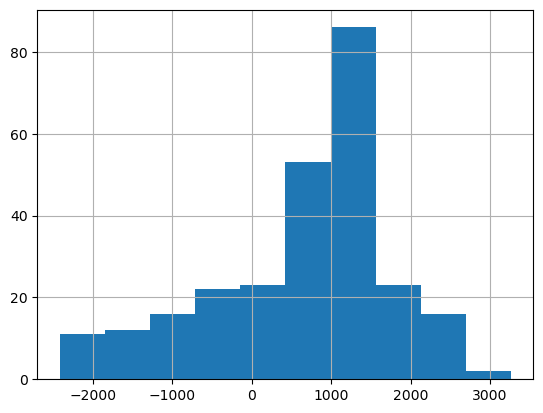

In [114]:
df_mean_diff.hist()
plt.show()

In [115]:
df_melted['Date'] = pd.to_datetime(df_melted['Date'])

In [116]:
df_melted.set_index('Date', inplace = True)

In [117]:
df_melted.sort_values(by=['SizeRank'])

RegionID  RegionName      City State      Metro CountyName  \
Date                                                                     
1996-04-01     84654       60657   Chicago    IL    Chicago       Cook   
2008-11-01     84654       60657   Chicago    IL    Chicago       Cook   
2009-12-01     84654       60657   Chicago    IL    Chicago       Cook   
2004-09-01     84654       60657   Chicago    IL    Chicago       Cook   
2005-10-01     84654       60657   Chicago    IL    Chicago       Cook   
...              ...         ...       ...   ...        ...        ...   
2008-07-01     95851       89155  Mesquite    NV  Las Vegas      Clark   
2005-12-01     95851       89155  Mesquite    NV  Las Vegas      Clark   
2015-03-01     95851       89155  Mesquite    NV  Las Vegas      Clark   
2012-06-01     95851       89155  Mesquite    NV  Las Vegas      Clark   
2018-04-01     95851       89155  Mesquite    NV  Las Vegas      Clark   

            SizeRank     Price  
Date                            
1996-04-01         1  334200.0  
2008-11-01         1  824800.0  
2009-12-01         1  774600.0  
2004-09-01         1  798200.0  
2005-10-01         1  870700.0  
...              ...       ...  
2008-07-01     14723  316000.0  
2005-12-01     14723  443800.0  
2015-03-01     14723  289100.0  
2012-06-01     14723  202200.0  
2018-04-01     14723  357200.0  

[3901595 rows x 8 columns]

In [118]:
df_melted.loc

In [119]:
df_chicago = df_melted[df_melted['City'] == 'Chicago']

In [120]:
df_chicago.sort_values(by=['RegionName', 'Date'])

RegionID  RegionName     City State    Metro CountyName  SizeRank  \
Date                                                                            
1996-04-01     84607       60605  Chicago    IL  Chicago       Cook      1361   
1996-05-01     84607       60605  Chicago    IL  Chicago       Cook      1361   
1996-06-01     84607       60605  Chicago    IL  Chicago       Cook      1361   
1996-07-01     84607       60605  Chicago    IL  Chicago       Cook      1361   
1996-08-01     84607       60605  Chicago    IL  Chicago       Cook      1361   
...              ...         ...      ...   ...      ...        ...       ...   
2017-12-01     84656       60660  Chicago    IL  Chicago       Cook       348   
2018-01-01     84656       60660  Chicago    IL  Chicago       Cook       348   
2018-02-01     84656       60660  Chicago    IL  Chicago       Cook       348   
2018-03-01     84656       60660  Chicago    IL  Chicago       Cook       348   
2018-04-01     84656       60660  Chicago    IL  Chicago       Cook       348   

               Price  
Date                  
1996-04-01  293500.0  
1996-05-01  293000.0  
1996-06-01  292500.0  
1996-07-01  291700.0  
1996-08-01  290900.0  
...              ...  
2017-12-01  517700.0  
2018-01-01  521500.0  
2018-02-01  524100.0  
2018-03-01  526300.0  
2018-04-01  526300.0  

[10865 rows x 8 columns]

In [121]:
df_chicago

RegionID  RegionName     City State    Metro CountyName  SizeRank  \
Date                                                                            
1996-04-01     84654       60657  Chicago    IL  Chicago       Cook         1   
1996-04-01     84616       60614  Chicago    IL  Chicago       Cook         4   
1996-04-01     84640       60640  Chicago    IL  Chicago       Cook         8   
1996-04-01     84646       60647  Chicago    IL  Chicago       Cook        17   
1996-04-01     84620       60618  Chicago    IL  Chicago       Cook        20   
...              ...         ...      ...   ...      ...        ...       ...   
2018-04-01     84653       60656  Chicago    IL  Chicago       Cook      3157   
2018-04-01     84652       60655  Chicago    IL  Chicago       Cook      3961   
2018-04-01     84645       60646  Chicago    IL  Chicago       Cook      4041   
2018-04-01    399713       60642  Chicago    IL  Chicago       Cook      4363   
2018-04-01     84634       60633  Chicago    IL  Chicago       Cook      7864   

               Price  
Date                  
1996-04-01  334200.0  
1996-04-01  498100.0  
1996-04-01  216500.0  
1996-04-01  122700.0  
1996-04-01  142600.0  
...              ...  
2018-04-01  304000.0  
2018-04-01  232600.0  
2018-04-01  401300.0  
2018-04-01  604400.0  
2018-04-01  113000.0  

[10865 rows x 8 columns]

In [122]:
chi_mean = df_chicago.groupby(['City', 'Date']).mean()

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1256/2759028472.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  chi_mean = df_chicago.groupby(['City', 'Date']).mean()


In [123]:
chi_mean.reset_index(inplace = True)

In [124]:
chi_mean.set_index('Date', inplace = True)

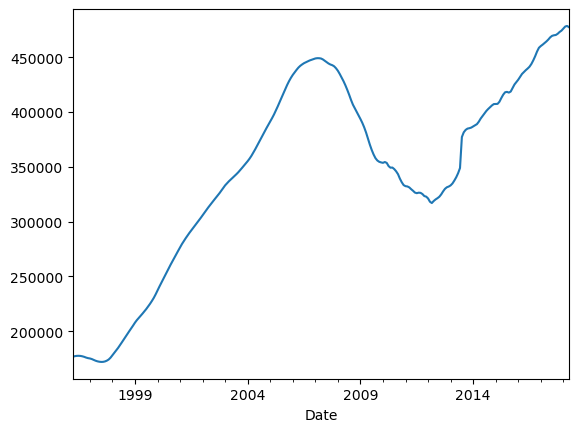

In [125]:
chi_mean['Price'].plot();

In [126]:
chi_mean_first_difference = chi_mean['Price'].diff()

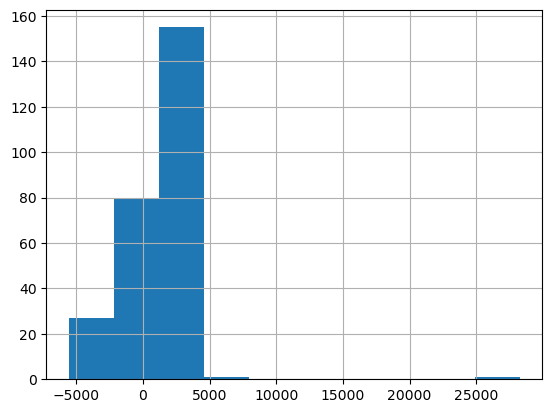

In [127]:
chi_mean_first_difference.hist()
plt.show()

In [128]:
sorted(chi_mean.index)

[Timestamp('1996-04-01 00:00:00'),
 Timestamp('1996-05-01 00:00:00'),
 Timestamp('1996-06-01 00:00:00'),
 Timestamp('1996-07-01 00:00:00'),
 Timestamp('1996-08-01 00:00:00'),
 Timestamp('1996-09-01 00:00:00'),
 Timestamp('1996-10-01 00:00:00'),
 Timestamp('1996-11-01 00:00:00'),
 Timestamp('1996-12-01 00:00:00'),
 Timestamp('1997-01-01 00:00:00'),
 Timestamp('1997-02-01 00:00:00'),
 Timestamp('1997-03-01 00:00:00'),
 Timestamp('1997-04-01 00:00:00'),
 Timestamp('1997-05-01 00:00:00'),
 Timestamp('1997-06-01 00:00:00'),
 Timestamp('1997-07-01 00:00:00'),
 Timestamp('1997-08-01 00:00:00'),
 Timestamp('1997-09-01 00:00:00'),
 Timestamp('1997-10-01 00:00:00'),
 Timestamp('1997-11-01 00:00:00'),
 Timestamp('1997-12-01 00:00:00'),
 Timestamp('1998-01-01 00:00:00'),
 Timestamp('1998-02-01 00:00:00'),
 Timestamp('1998-03-01 00:00:00'),
 Timestamp('1998-04-01 00:00:00'),
 Timestamp('1998-05-01 00:00:00'),
 Timestamp('1998-06-01 00:00:00'),
 Timestamp('1998-07-01 00:00:00'),
 Timestamp('1998-08-

<Axes: xlabel='Date'>

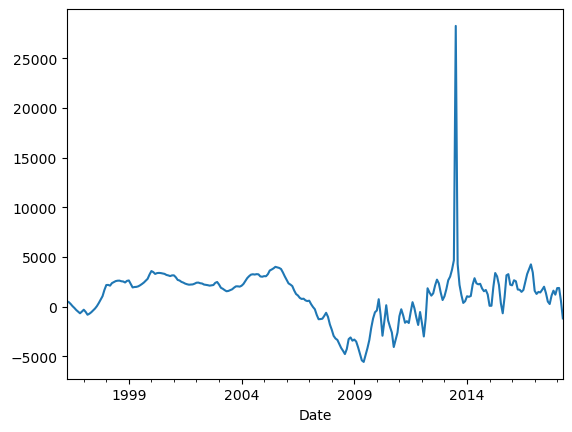

In [129]:
chi_mean_first_difference.plot()

In [130]:
chi_mean

City      RegionID    RegionName     SizeRank          Price
Date                                                                       
1996-04-01  Chicago  92317.829268  60633.097561  1266.536585  176757.500000
1996-05-01  Chicago  92317.829268  60633.097561  1266.536585  177220.000000
1996-06-01  Chicago  92317.829268  60633.097561  1266.536585  177500.000000
1996-07-01  Chicago  92317.829268  60633.097561  1266.536585  177560.000000
1996-08-01  Chicago  92317.829268  60633.097561  1266.536585  177435.000000
...             ...           ...           ...          ...            ...
2017-12-01  Chicago  92317.829268  60633.097561  1266.536585  474153.658537
2018-01-01  Chicago  92317.829268  60633.097561  1266.536585  476026.829268
2018-02-01  Chicago  92317.829268  60633.097561  1266.536585  477909.756098
2018-03-01  Chicago  92317.829268  60633.097561  1266.536585  478475.609756
2018-04-01  Chicago  92317.829268  60633.097561  1266.536585  477292.682927

[265 rows x 5 columns]

In [131]:
chi_mean_price = chi_mean(columns =['Date', 'Price'])

TypeError: 'DataFrame' object is not callable

In [132]:
chi_mean_price

NameError: name 'chi_mean_price' is not defined

In [133]:
chicago = df_chicago.groupby('City').mean()

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1256/3104339859.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  chicago = df_chicago.groupby('City').mean()


In [134]:
chicago['Price']

City
Chicago    345709.823607
Name: Price, dtype: float64

In [135]:
chi_town_zip = df_melted[df_melted['RegionName'] == 60657]

In [136]:
chi_town_zip.set_index('Date', inplace = True)

KeyError: "None of ['Date'] are in the columns"

In [137]:
color_pal

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

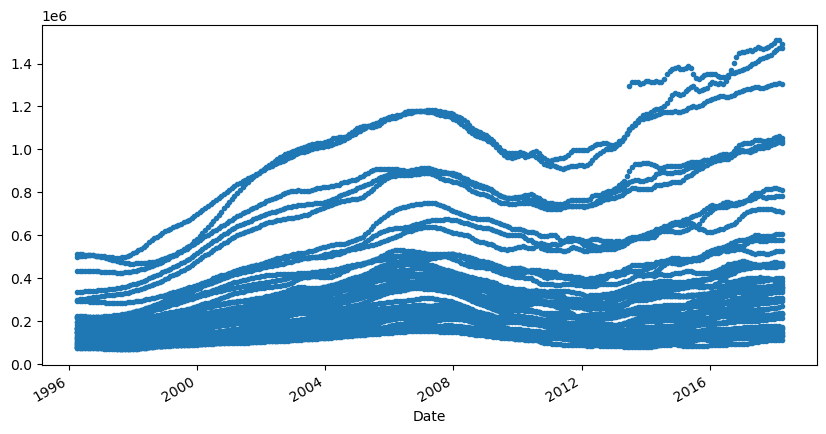

In [138]:
fix, ax = plt.subplots(figsize = (10,5))

#chi_town_zip['Price'].plot(style = '.', color = color_pal[1], title = 'Chicago Zip Pricing')

df_chicago['Price'].plot(style = '.');

In [139]:
df_melted.sort_index()

RegionID  RegionName                 City State  \
Date                                                          
1996-04-01     84654       60657              Chicago    IL   
1996-04-01     90668       75070             McKinney    TX   
1996-04-01     91982       77494                 Katy    TX   
1996-04-01     84616       60614              Chicago    IL   
1996-04-01     93144       79936              El Paso    TX   
...              ...         ...                  ...   ...   
2018-04-01     58333        1338             Ashfield    MA   
2018-04-01     59107        3293            Woodstock    NH   
2018-04-01     75672       40404                Berea    KY   
2018-04-01     93733       81225  Mount Crested Butte    CO   
2018-04-01     95851       89155             Mesquite    NV   

                        Metro CountyName  SizeRank     Price  
Date                                                          
1996-04-01            Chicago       Cook         1  334200.0  
1996-04-01  Dallas-Fort Worth     Collin         2  235700.0  
1996-04-01            Houston     Harris         3  210400.0  
1996-04-01            Chicago       Cook         4  498100.0  
1996-04-01            El Paso    El Paso         5   77300.0  
...                       ...        ...       ...       ...  
2018-04-01    Greenfield Town   Franklin     14719  209300.0  
2018-04-01          Claremont    Grafton     14720  225800.0  
2018-04-01           Richmond    Madison     14721  133400.0  
2018-04-01                NaN   Gunnison     14722  664400.0  
2018-04-01          Las Vegas      Clark     14723  357200.0  

[3901595 rows x 8 columns]

# Step 3: EDA and Visualization

ConversionError: Failed to convert value(s) to axis units: array(['Chicago', 'McKinney', 'Katy', ..., 'Berea', 'Mount Crested Butte',
       'Mesquite'], dtype=object)

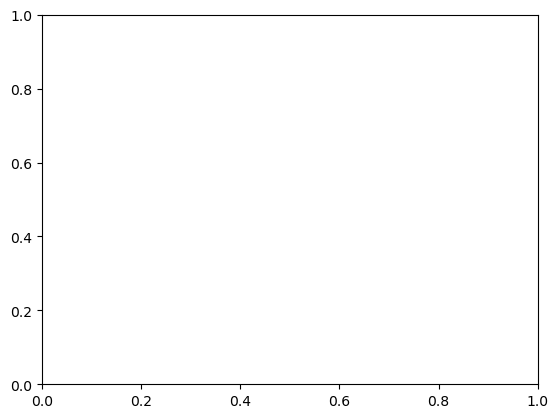

In [146]:
plt.plot(data)

# Step 4: Reshape from Wide to Long Format

In [907]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [908]:
usa_mean = melt_data(data)

In [909]:
type(usa_mean)

pandas.core.frame.DataFrame

In [910]:
usa_mean.rename(columns={"value": "Price"}, inplace = True)

In [911]:
usa_mean

Price
time                     
1996-04-01  118299.123063
1996-05-01  118419.044139
1996-06-01  118537.423268
1996-07-01  118653.069278
1996-08-01  118780.254312
...                   ...
2017-12-01  281095.320247
2018-01-01  282657.060382
2018-02-01  284368.688447
2018-03-01  286511.376757
2018-04-01  288039.944305

[265 rows x 1 columns]

In [912]:
df_melted.index

RangeIndex(start=0, stop=3901595, step=1)

In [913]:
df_usa_mean = df_melted.groupby('Date').mean()['Price']

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1256/1427932459.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_usa_mean = df_melted.groupby('Date').mean()['Price']


In [914]:
type(df_usa_mean)

pandas.core.series.Series

In [915]:
usa_mean.index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='time', length=265, freq=None)

In [916]:
df_usa_mean

Date
1996-04    118299.123063
1996-05    118419.044139
1996-06    118537.423268
1996-07    118653.069278
1996-08    118780.254312
               ...      
2017-12    281095.320247
2018-01    282657.060382
2018-02    284368.688447
2018-03    286511.376757
2018-04    288039.944305
Name: Price, Length: 265, dtype: float64

In [917]:
rolling_mean

NameError: name 'rolling_mean' is not defined

In [918]:
rolling_mean = usa_mean.rolling(window = 6).mean()
rolling_std = usa_mean.rolling(window = 6).std()

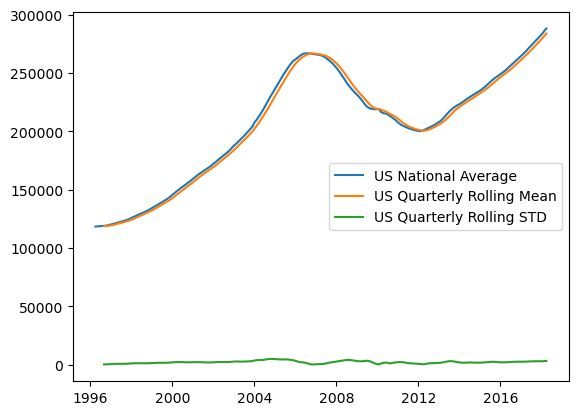

In [919]:
plt.plot(usa_mean, label = 'US National Average')
plt.plot(rolling_mean, label = 'US Quarterly Rolling Mean')
plt.plot(rolling_std, label = 'US Quarterly Rolling STD');

plt.legend();

In [920]:
from statsmodels.tsa.stattools import adfuller


In [921]:
adfuller(usa_mean)

(-1.8851445183777926,
 0.3390815439412539,
 2,
 262,
 {'1%': -3.455558114028747,
  '5%': -2.872635586277424,
  '10%': -2.572682677000175},
 3505.613476823798)

In [922]:
df_usa_mean_diff = usa_mean.diff()

In [923]:
diff_rolling_mean = df_usa_mean_diff.rolling(window = 6).mean()
dif_rolling_std = df_usa_mean_diff.rolling(window = 6).std()

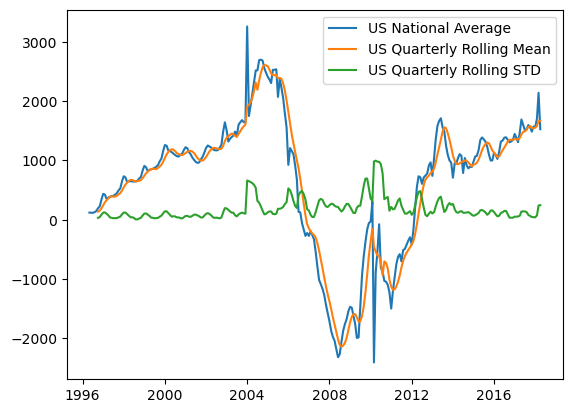

In [924]:
plt.plot(df_usa_mean_diff, label = 'US National Average')
plt.plot(diff_rolling_mean, label = 'US Quarterly Rolling Mean')
plt.plot(dif_rolling_std, label = 'US Quarterly Rolling STD');

plt.legend();

/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


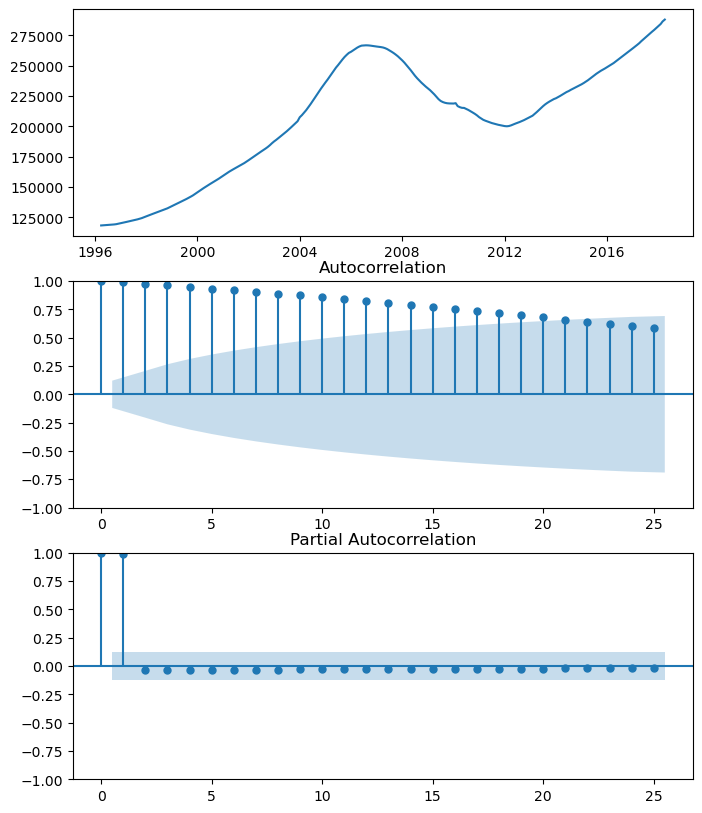

In [925]:
fig, ax = plt.subplots(3,1, figsize = (8,10))

ax[0].plot(usa_mean)
plot_acf(usa_mean, ax = ax[1])
plot_pacf(usa_mean, ax = ax[2])
plt.show()

In [926]:
df_usa_mean_diff = usa_mean.diff()

/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


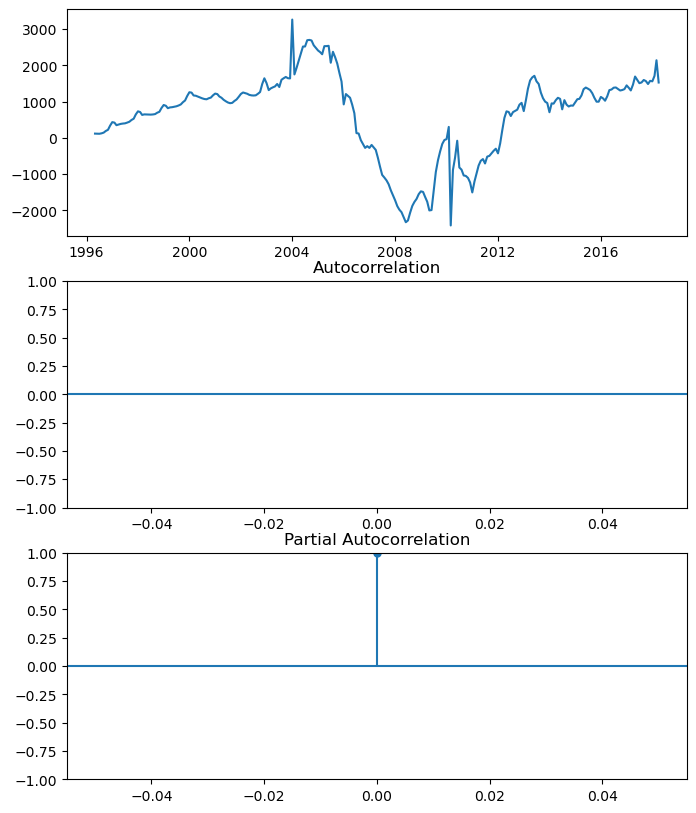

In [927]:
fig, ax = plt.subplots(3,1, figsize = (8,10))

ax[0].plot(df_usa_mean_diff)
plot_acf(df_usa_mean_diff, ax = ax[1])
plot_pacf(df_usa_mean_diff, ax = ax[2])
plt.show()

In [928]:
usa_mean

Price
time                     
1996-04-01  118299.123063
1996-05-01  118419.044139
1996-06-01  118537.423268
1996-07-01  118653.069278
1996-08-01  118780.254312
...                   ...
2017-12-01  281095.320247
2018-01-01  282657.060382
2018-02-01  284368.688447
2018-03-01  286511.376757
2018-04-01  288039.944305

[265 rows x 1 columns]

<Axes: xlabel='time'>

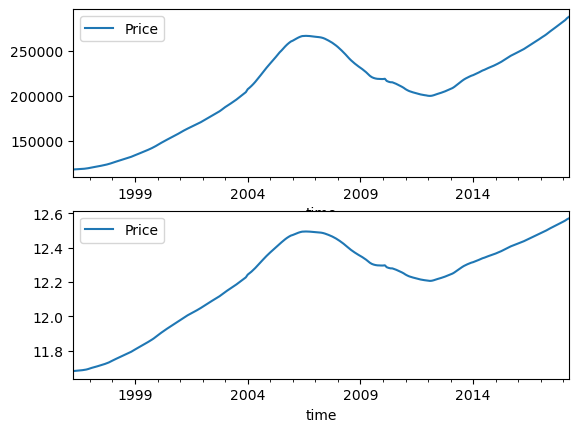

In [929]:
logged_data = np.log(usa_mean)

fix, ax = plt.subplots(2,1)
usa_mean.plot(ax = ax[0], label = 'US Mean Price')
logged_data.plot(ax = ax[1], label = 'US Log of Mean Price')



In [930]:
result_us = seasonal_decompose(usa_mean, model='multiplicative') # assume multiplicative model

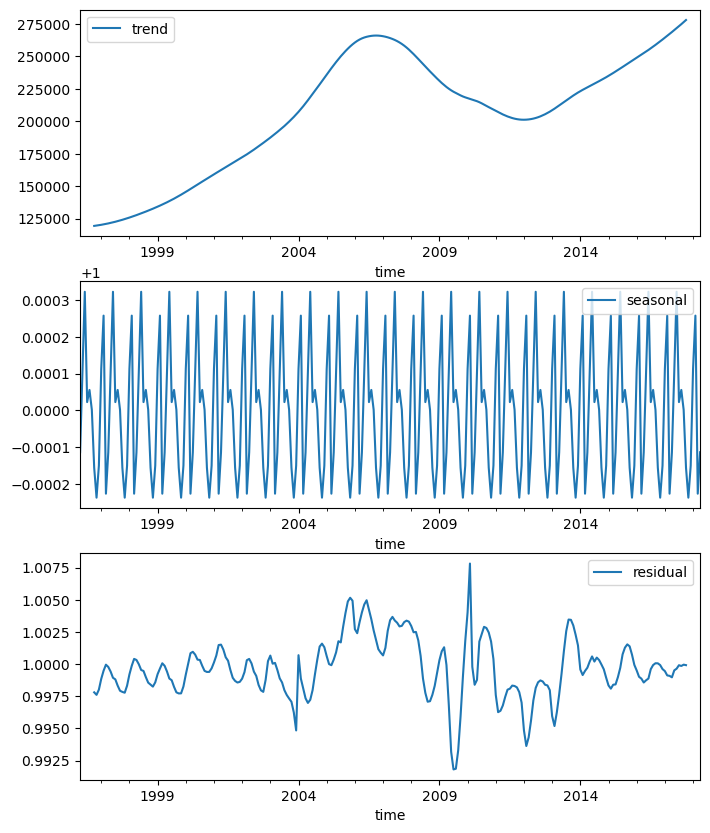

In [931]:
fig, ax = plt.subplots(3,1, figsize = (8,10))
result_us.trend.plot(ax = ax[0], label = 'trend')
ax[0].legend()
result_us.seasonal.plot(ax = ax[1], label = 'seasonal')
ax[1].legend()
result_us.resid.plot(ax = ax[2], label = 'residual')
ax[2].legend();

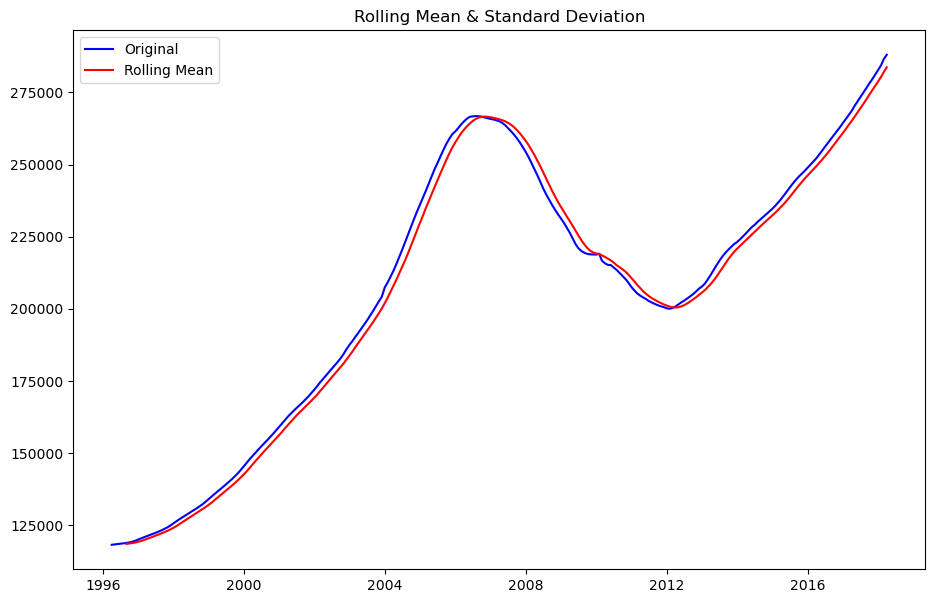

In [932]:
roll_mean = usa_mean.rolling(window=6).mean()
fig = plt.figure(figsize=(11,7))
plt.plot(usa_mean, color='blue',label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [933]:
data_minus_roll_mean = usa_mean - roll_mean
data_minus_roll_mean.head(15)

Price
time                  
1996-04-01         NaN
1996-05-01         NaN
1996-06-01         NaN
1996-07-01         NaN
1996-08-01         NaN
1996-09-01  324.788074
1996-10-01  380.880347
1996-11-01  451.327585
1996-12-01  599.783202
1997-01-01  791.264737
1997-02-01  920.242619
1997-03-01  944.442414
1997-04-01  958.050765
1997-05-01  960.682793
1997-06-01  963.221037

In [934]:
data_minus_roll_mean.dropna(inplace=True)

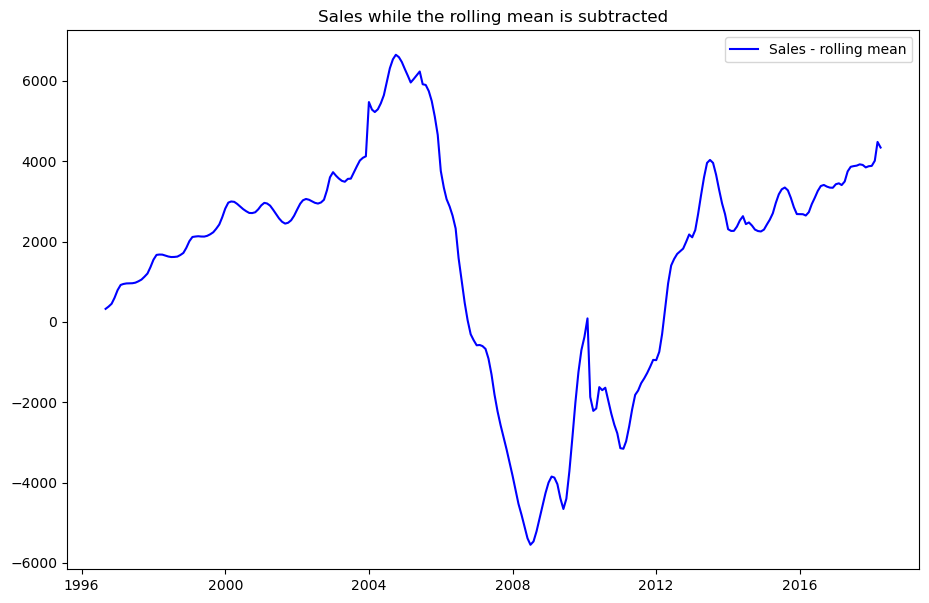

In [935]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_roll_mean, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Sales while the rolling mean is subtracted')
plt.show(block=False)

Exponentially Weighted Moving Average
[here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.ewm.html).

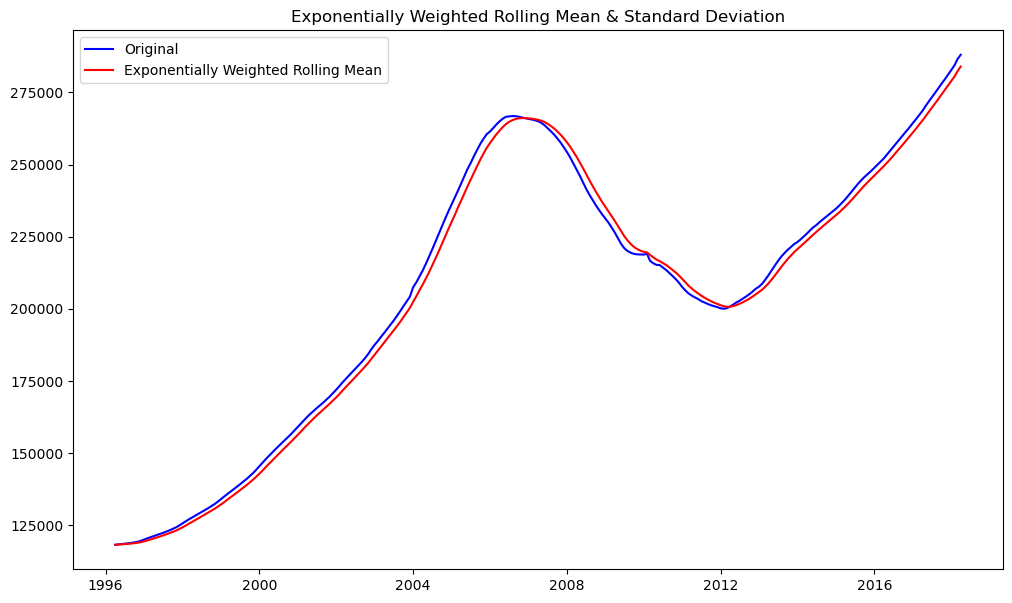

In [936]:
# Use Pandas ewm() to calculate Exponential Weighted Moving Average
exp_roll_mean = usa_mean.ewm(halflife=2).mean()

# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,7))
orig = plt.plot(usa_mean, color='blue',label='Original')
mean = plt.plot(exp_roll_mean, color='red', label='Exponentially Weighted Rolling Mean')
plt.legend(loc='best')
plt.title('Exponentially Weighted Rolling Mean & Standard Deviation')
plt.show(block=False)

In [937]:
# Subtract the moving average from the original data
data_minus_exp_roll_mean = usa_mean - exp_roll_mean
data_minus_exp_roll_mean.head(15)

Price
time                  
1996-04-01    0.000000
1996-05-01   49.672936
1996-06-01   91.910726
1996-07-01  126.500789
1996-08-01  163.427375
1996-09-01  206.698843
1996-10-01  271.273384
1996-11-01  341.112366
1996-12-01  472.209581
1997-01-01  633.746471
1997-02-01  740.221701
1997-03-01  767.508105
1997-04-01  801.708993
1997-05-01  838.312226
1997-06-01  871.634822

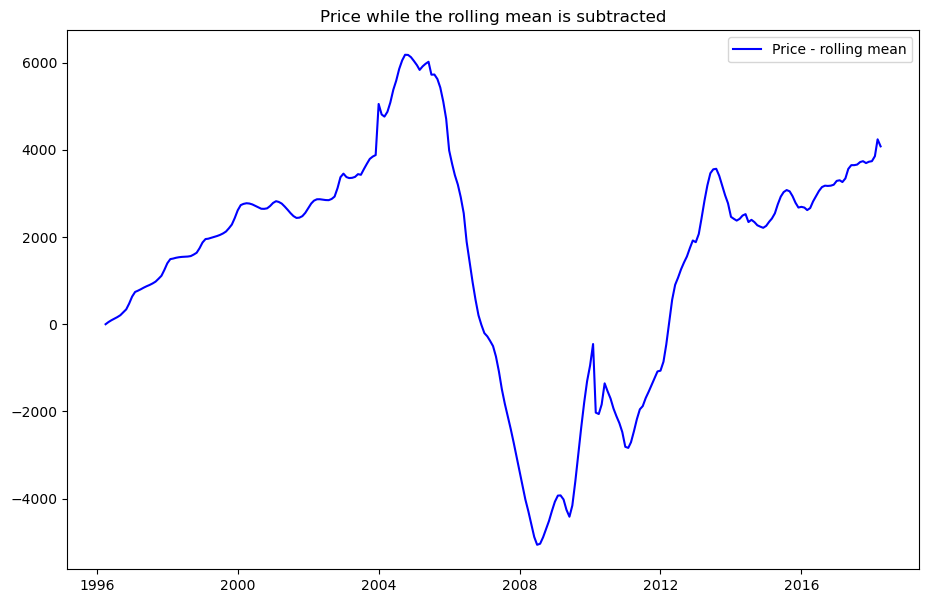

In [938]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_exp_roll_mean, color='blue',label='Price - rolling mean')
plt.legend(loc='best')
plt.title('Price while the rolling mean is subtracted')
plt.show(block=False)

In [939]:
data_diff = usa_mean.diff(periods=1)
data_diff.head(10)

Price
time                  
1996-04-01         NaN
1996-05-01  119.921076
1996-06-01  118.379129
1996-07-01  115.646010
1996-08-01  127.185034
1996-09-01  147.274189
1996-10-01  192.991815
1996-11-01  224.831920
1996-12-01  339.732534
1997-01-01  436.180941

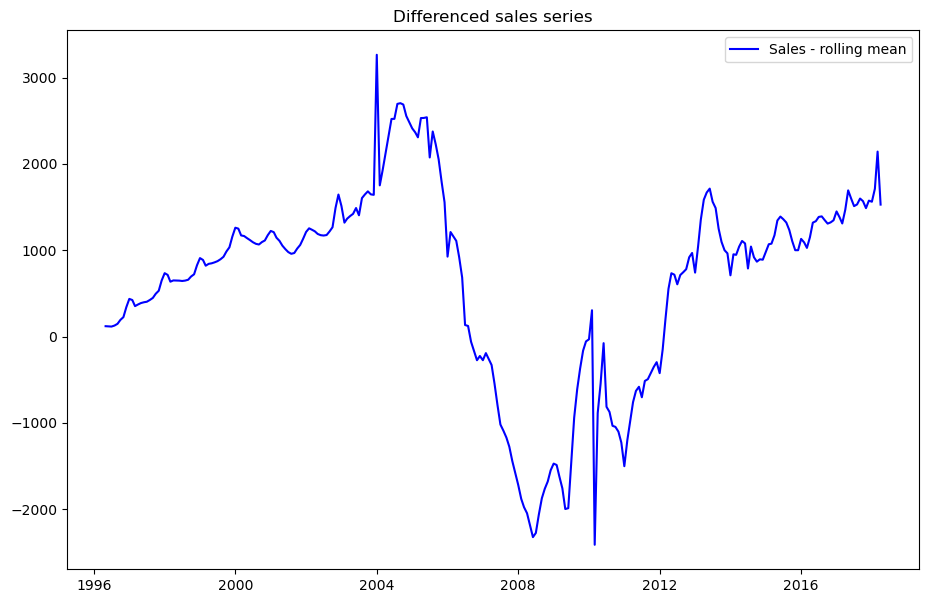

In [940]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_diff, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Differenced sales series')
plt.show(block=False)

data.plot(figsize=(18,6), color='blue', linewidth=1, fontsize=14)

In [941]:
acf(usa_mean, nlags = 5, fft = True)

array([1.        , 0.98767054, 0.97483929, 0.96160063, 0.94790879,
       0.93375436])

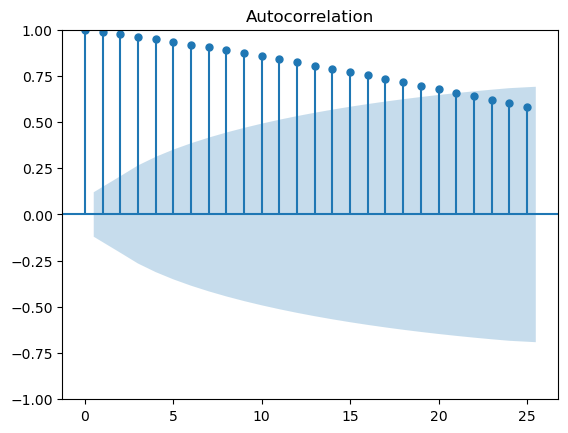

In [942]:
plot_acf(usa_mean)
plt.show()

In [943]:
pacf(usa_mean, nlags = 8)

array([ 1.        ,  0.99141172, -0.03769429, -0.03174168, -0.0343937 ,
       -0.03478834, -0.03362988, -0.03317377, -0.03143224])

/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


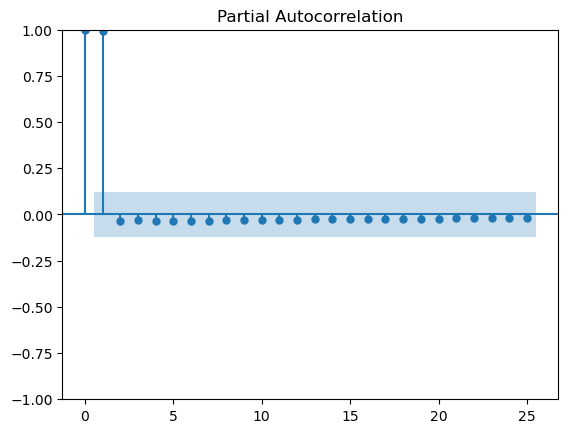

In [944]:
plot_pacf(usa_mean)
plt.show();

In [945]:
result = seasonal_decompose(usa_mean, period = 50)

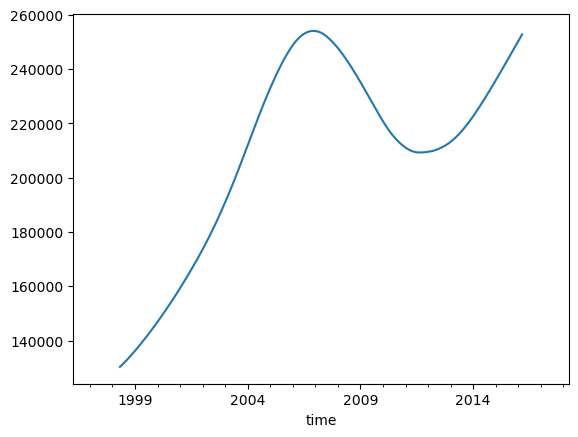

In [946]:
result.trend.plot()
plt.show()

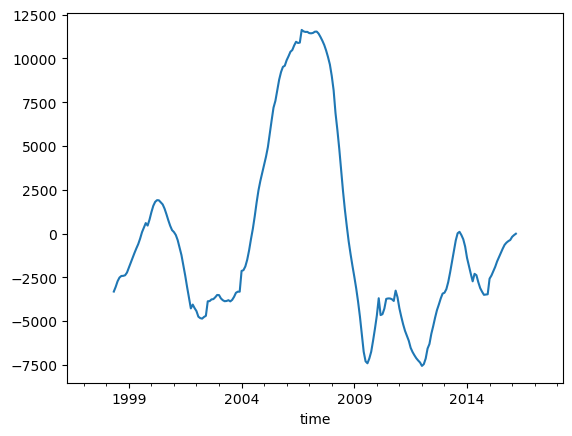

In [947]:
result.resid.plot()
plt.show()

In [948]:
adfuller(usa_mean)

(-1.8851445183777926,
 0.3390815439412539,
 2,
 262,
 {'1%': -3.455558114028747,
  '5%': -2.872635586277424,
  '10%': -2.572682677000175},
 3505.613476823798)

<Axes: xlabel='time'>

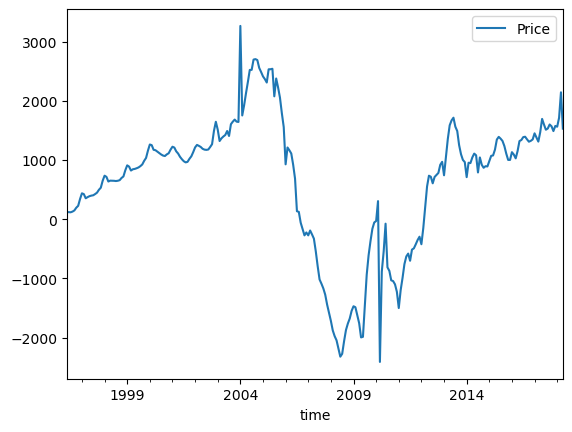

In [949]:
usa_mean_diff = usa_mean.diff().dropna()
usa_mean_diff.plot()

Slide Type
Slide
Down-sampling

- '1H': every 1 hour samples
- '2H': every 2 hours, etc
- 'T': minute frequency
- 'S' : second frequency
- 'D': daily
- 'W': weekly
- 'M': monthly

For more frequencies:

https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

NOTES

ROI by total time length
ROI each year
compare ROI by city, by zip within city
compare ROI by county
% change in price
risk factors




<Axes: xlabel='time'>

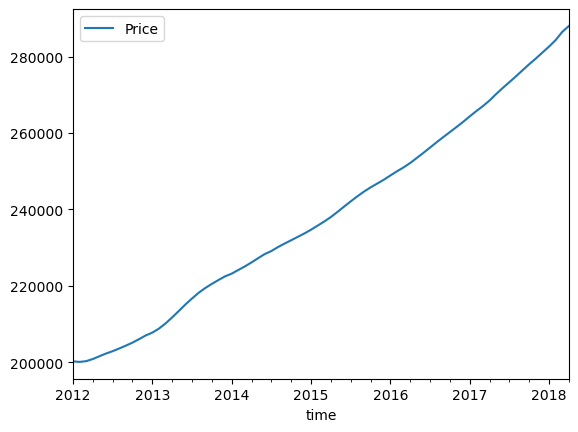

In [950]:
usa_mean.loc['2012':'2018'].plot()

In [951]:
adfuller(usa_mean_diff)

(-2.548781596834006,
 0.10405172262326762,
 13,
 250,
 {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544},
 3492.8977580070396)

In [952]:
result_usa = seasonal_decompose(usa_mean_diff, model='additive') 

In [953]:
%%capture usa_decomposition_plot
fig, ax = plt.subplots(3,1, figsize = (6,6))
result_usa.trend.plot(ax = ax[0], label = 'trend')
ax[0].legend()
result_usa.seasonal.plot(ax = ax[1], label = 'seasonal')
ax[1].legend()
result_usa.resid.plot(ax = ax[2], label = 'residual')
ax[2].legend()

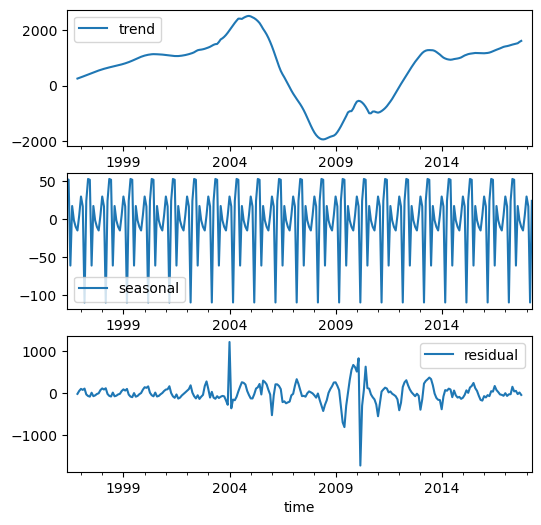

In [954]:
usa_decomposition_plot()

<Axes: xlabel='time'>

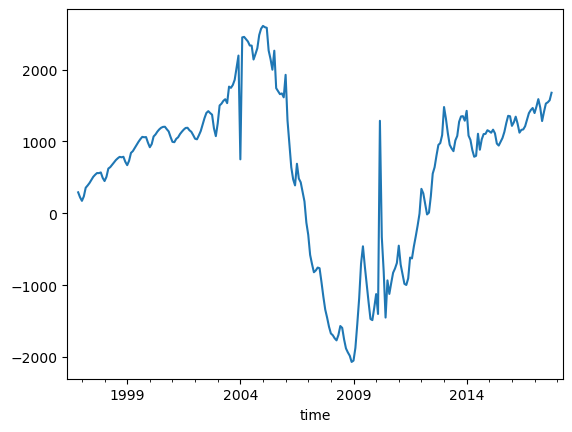

In [955]:
reconstruct = result_usa.trend-result_usa.seasonal-result_usa.resid

reconstruct.plot()

<Axes: xlabel='time'>

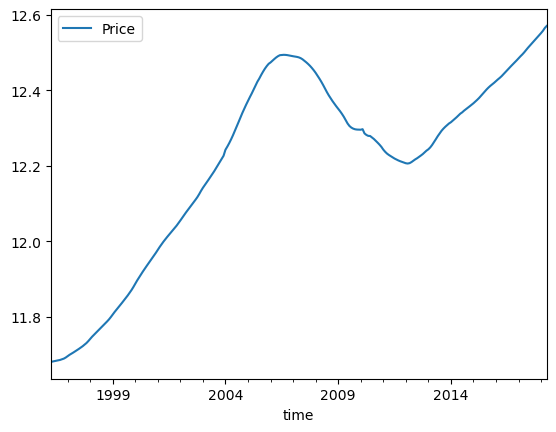

In [956]:
logged_data = np.log(usa_mean)
logged_data.plot()

<Axes: xlabel='time'>

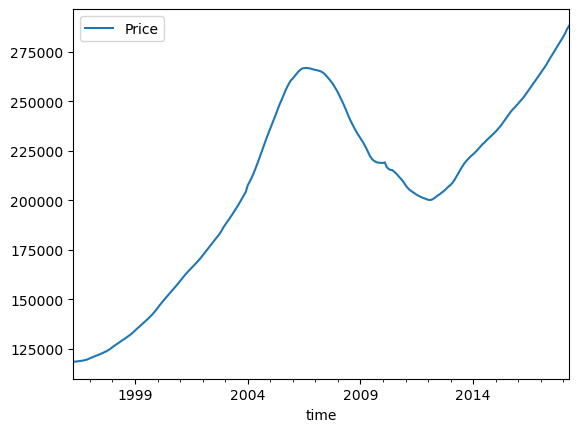

In [957]:
usa_mean.plot()

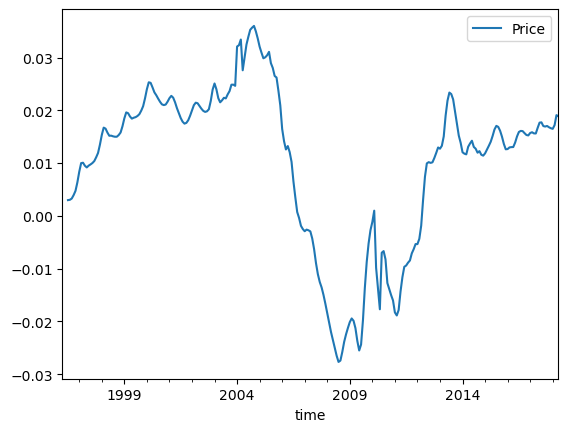

In [958]:
logged_data.diff(3).plot()
plt.show()

In [959]:
usa_rolling = usa_mean.rolling(window = 2).mean().dropna()

In [960]:
log_roll_data = usa_mean - usa_rolling 
log_roll_data.dropna(inplace = True)

adfuller(log_roll_data)

(-2.548781596834042,
 0.10405172262325951,
 13,
 250,
 {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544},
 3150.483050810425)

In [961]:
log_diff_data = logged_data.diff(3).dropna()
adfuller(log_diff_data)

(-2.250499666127554,
 0.1884298328853442,
 10,
 251,
 {'1%': -3.4566744514553016,
  '5%': -2.8731248767783426,
  '10%': -2.5729436702592023},
 -2528.2140818674793)

<Axes: xlabel='time'>

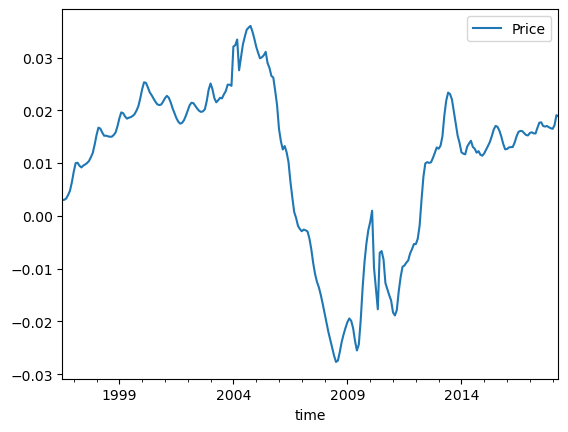

In [962]:
log_diff_data.plot()

In [963]:
plot_acf(differenced_data)
plt.show()

NameError: name 'differenced_data' is not defined

In [964]:
plot_pacf(differenced_data)
plt.show();

NameError: name 'differenced_data' is not defined

In [965]:
exp_roll_mean = np.log(usa_mean).ewm(halflife=4).mean()

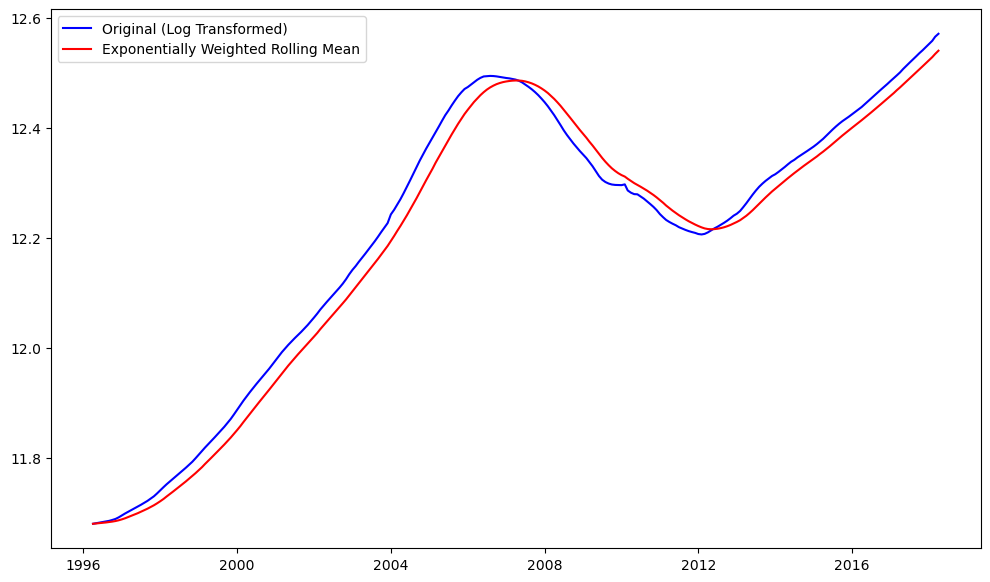

In [966]:
fig = plt.figure(figsize=(12,7))
plt.plot(np.log(usa_mean), color='blue',label='Original (Log Transformed)')
plt.plot(exp_roll_mean, color='red', label='Exponentially Weighted Rolling Mean')
plt.legend(loc='best')
plt.show(block=False)

## (Logged) - (Explonentially Weighted Mean) : np.log(usa_mean) - exp_roll_mean

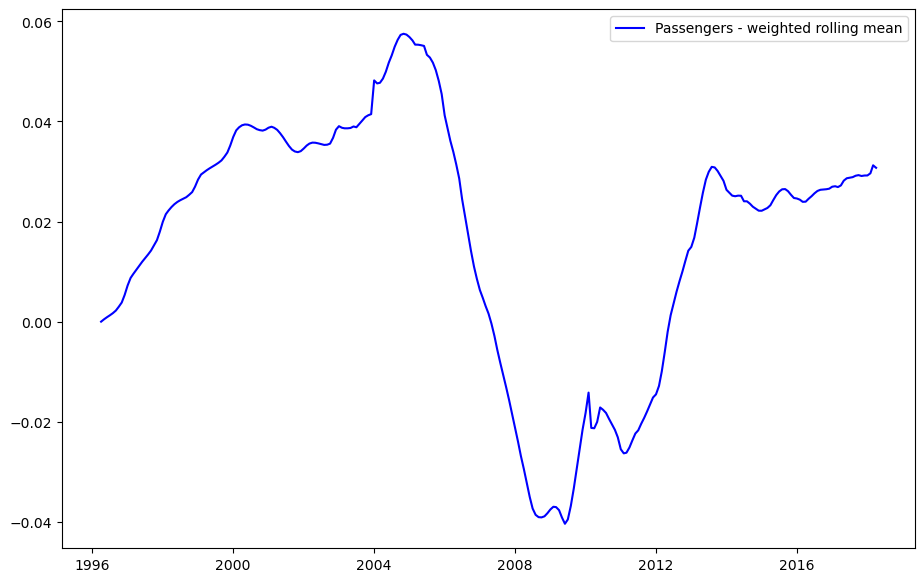

In [967]:
# Subtract the moving average from the original data and check head for Nans
data_minus_exp_roll_mean = np.log(usa_mean) - exp_roll_mean

# Plot the time series
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_exp_roll_mean, color='blue',label='Passengers - weighted rolling mean')
plt.legend(loc='best')
plt.show(block=False)

In [968]:

def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center=False).mean()
    roll_std = TS.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS)
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    plt.plot(TS, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None


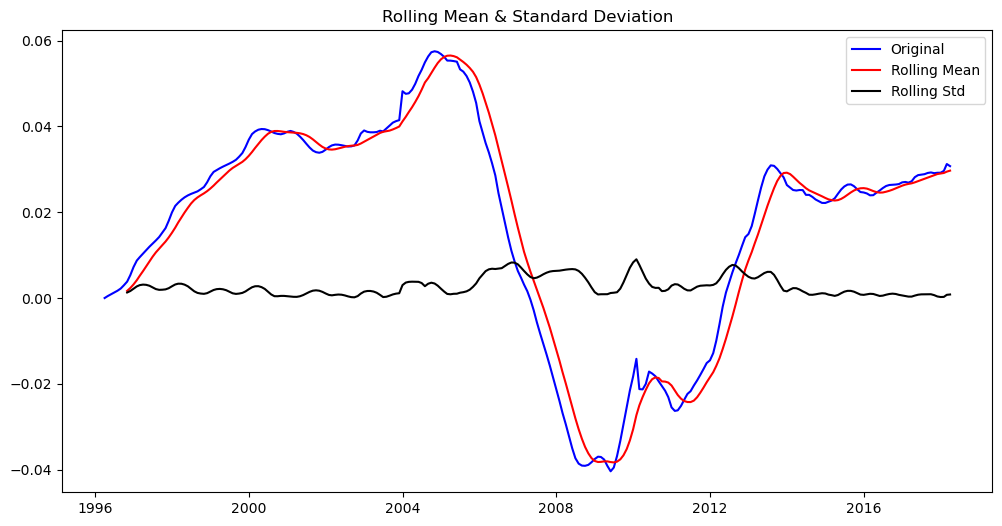

Results of Dickey-Fuller Test: 

Test Statistic                  -2.010571
p-value                          0.281958
#Lags Used                       4.000000
Number of Observations Used    260.000000
Critical Value (1%)             -3.455754
Critical Value (5%)             -2.872721
Critical Value (10%)            -2.572728
dtype: float64


In [969]:
stationarity_check(data_minus_exp_roll_mean)

In [970]:
data_diff = data_minus_exp_roll_mean.diff(periods=3)

# Drop the missing values
data_diff.dropna(inplace=True)

# Check out the first few rows
data_diff.head(15)

Price
time                
1996-07-01  0.001270
1996-08-01  0.001236
1996-09-01  0.001327
1996-10-01  0.001697
1996-11-01  0.002125
1996-12-01  0.003109
1997-01-01  0.004262
1997-02-01  0.004913
1997-03-01  0.004213
1997-04-01  0.003134
1997-05-01  0.002453
1997-06-01  0.002430
1997-07-01  0.002310
1997-08-01  0.002229
1997-09-01  0.002249

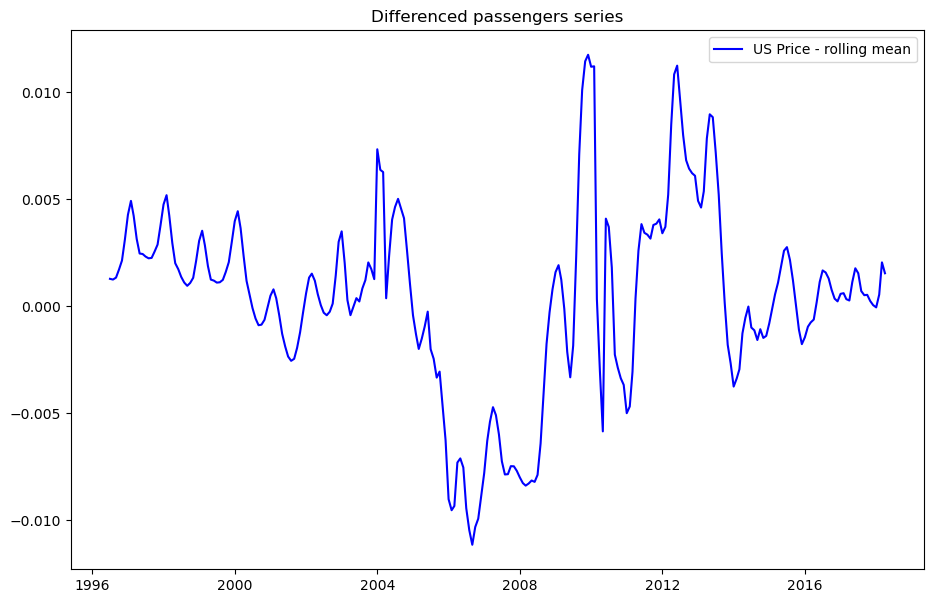

In [971]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_diff, color='blue',label='US Price - rolling mean')
plt.legend(loc='best')
plt.title('Differenced passengers series')
plt.show(block=False)

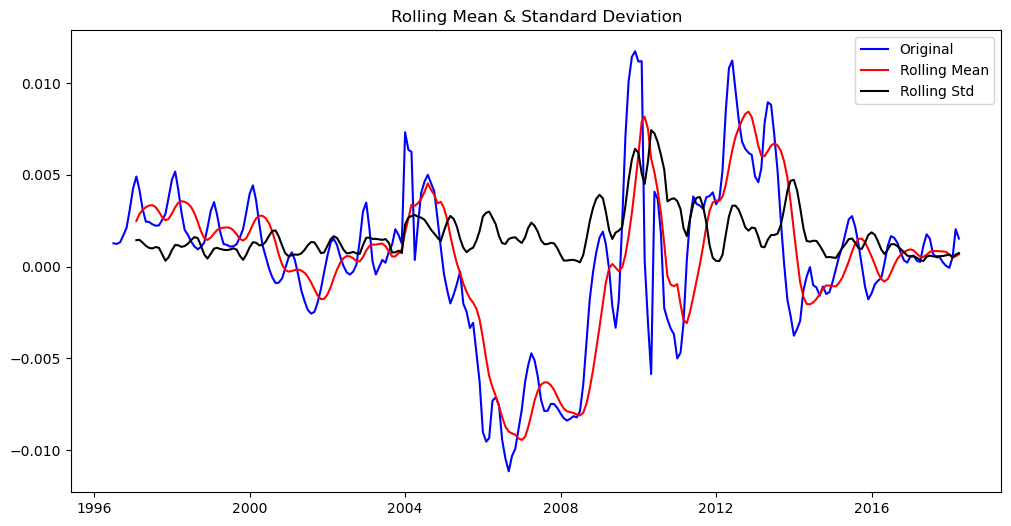

Results of Dickey-Fuller Test: 

Test Statistic                  -3.195600
p-value                          0.020241
#Lags Used                      11.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


In [972]:
stationarity_check(data_diff)


In [973]:
# Exponentially Weighted Mean
exp_roll_mean = np.log(usa_mean).ewm(halflife=2).mean()

# Logged - EWM
data_minus_exp_roll_mean = np.log(usa_mean) - exp_roll_mean

# Differencing of (Logged - EWM)
data_diff_4 = data_minus_exp_roll_mean.diff(periods=4)

# Drop the missing values
diff_log_exp_mean_4 = data_diff_4.dropna()


In [974]:
adfuller(diff_log_exp_mean_4)

(-3.2718101558760084,
 0.016186556632203038,
 13,
 247,
 {'1%': -3.457105309726321,
  '5%': -2.873313676101283,
  '10%': -2.5730443824681606},
 -2674.8794225856336)

In [975]:
# Exponentially Weighted Mean
exp_roll_mean = np.log(usa_mean).ewm(halflife=2).mean()

# Logged - EWM
data_minus_exp_roll_mean = np.log(usa_mean) - exp_roll_mean

# Differencing of (Logged - EWM)
data_diff_9 = data_minus_exp_roll_mean.diff(periods=9)

# Drop the missing values
diff_log_exp_mean_9 = data_diff_9.dropna()

In [976]:
adfuller(diff_log_exp_mean_9)

(-3.4294674558540383,
 0.009994418783171997,
 11,
 244,
 {'1%': -3.457437824930831,
  '5%': -2.873459364726563,
  '10%': -2.573122099570008},
 -2565.2800070809444)

In [977]:
def try_diffed_log_minus_ewm(TS):

    min_p = 1
    
    for i, k in itertools.product(range(1,8), range(1,13)):
        exp_roll_mean = np.log(TS).ewm(halflife = i).mean()

        # Logged - EWM
        data_minus_exp_roll_mean = np.log(TS) - exp_roll_mean

        # Differencing of (Logged - EWM)
        data_diff = data_minus_exp_roll_mean.diff(periods = k)

        # Drop the missing values
        diff_log_exp_mean = data_diff.dropna()
        
        p = adfuller(diff_log_exp_mean)[1]
        
        if p < min_p:
            min_p = p
        
        print(min_p)
        print(f'Half Life: {i} ; Diff Period : {k} \nP Value {p}\n')


In [978]:
try_diffed_log_minus_ewm(usa_mean)

0.012111360126266728
Half Life: 1 ; Diff Period : 1 
P Value 0.012111360126266728

0.012111360126266728
Half Life: 1 ; Diff Period : 2 
P Value 0.06833287164729318

0.012111360126266728
Half Life: 1 ; Diff Period : 3 
P Value 0.022826404429015925

0.012111360126266728
Half Life: 1 ; Diff Period : 4 
P Value 0.021392422564830902

0.012111360126266728
Half Life: 1 ; Diff Period : 5 
P Value 0.049473842957513815

0.012111360126266728
Half Life: 1 ; Diff Period : 6 
P Value 0.043386941433410424

0.012111360126266728
Half Life: 1 ; Diff Period : 7 
P Value 0.08490732461996209

0.012111360126266728
Half Life: 1 ; Diff Period : 8 
P Value 0.17767848189120788

0.012111360126266728
Half Life: 1 ; Diff Period : 9 
P Value 0.018587222993798454

0.012111360126266728
Half Life: 1 ; Diff Period : 10 
P Value 0.029202694169157575

0.012111360126266728
Half Life: 1 ; Diff Period : 11 
P Value 0.08257899253272988

0.012111360126266728
Half Life: 1 ; Diff Period : 12 
P Value 0.06127971345188886

0.0121

In [979]:
def best_diffed_log_minus_ewm(TS):

    min_p = 1
    
    for i, k in itertools.product(range(1,8), range(1,13)):
        exp_roll_mean = np.log(TS).ewm(halflife = i).mean()

        # Logged - EWM
        data_minus_exp_roll_mean = np.log(TS) - exp_roll_mean

        # Differencing of (Logged - EWM)
        data_diff = data_minus_exp_roll_mean.diff(periods = k)

        # Drop the missing values
        diff_log_exp_mean = data_diff.dropna()
        
        p = adfuller(diff_log_exp_mean)[1]
        
        if p < min_p:
            min_p = p
        
            print(min_p)
            print(f'Half Life: {i} ; Diff Period : {k} \nP Value {p}\n')

In [980]:
best_diffed_log_minus_ewm(usa_mean)

0.012111360126266728
Half Life: 1 ; Diff Period : 1 
P Value 0.012111360126266728

0.009994418783171997
Half Life: 2 ; Diff Period : 9 
P Value 0.009994418783171997

0.0008344262073295845
Half Life: 3 ; Diff Period : 1 
P Value 0.0008344262073295845



In [981]:
def try_diff1_log_minus_ewm(TS):

    min_p = 1
    
    for i in range(1,8):
        exp_roll_mean = np.log(TS).ewm(halflife = i).mean()

        # Logged - EWM
        data_minus_exp_roll_mean = np.log(TS) - exp_roll_mean

        # Differencing of (Logged - EWM)
        data_diff = data_minus_exp_roll_mean.diff

        # Drop the missing values
        diff_log_exp_mean = data_diff.dropna()
        
        p = adfuller(diff_log_exp_mean)[1]
        
        if p < min_p:
            min_p = p
        
        print(min_p)
        print(f'Half Life: {i} ; Diff \nP Value {p}\n')

### Made Stationary With:


In [982]:
exp_roll_mean = np.log(usa_mean).ewm(halflife = 3).mean()

# Logged - EWM
data_minus_exp_roll_mean = np.log(usa_mean) - exp_roll_mean

logewm_log_min_mean_diff = data_minus_exp_roll_mean.diff().dropna()

In [983]:
logewm_log_min_mean_diff

Price
time                
1996-05-01  0.000448
1996-06-01  0.000402
1996-07-01  0.000351
1996-08-01  0.000387
1996-09-01  0.000461
...              ...
2017-12-01  0.000054
2018-01-01 -0.000018
2018-02-01  0.000380
2018-03-01  0.001468
2018-04-01 -0.000570

[264 rows x 1 columns]

In [984]:
adfuller(logewm_log_min_mean_diff)

(-4.138971956074198,
 0.0008344262073295845,
 3,
 260,
 {'1%': -3.4557539868570775,
  '5%': -2.8727214497041422,
  '10%': -2.572728476331361},
 -2691.234629393834)

## Modeling

In [985]:
logewm_log_min_mean_diff

Price
time                
1996-05-01  0.000448
1996-06-01  0.000402
1996-07-01  0.000351
1996-08-01  0.000387
1996-09-01  0.000461
...              ...
2017-12-01  0.000054
2018-01-01 -0.000018
2018-02-01  0.000380
2018-03-01  0.001468
2018-04-01 -0.000570

[264 rows x 1 columns]

In [986]:
(2018 - 1995)*.2

4.6000000000000005

In [987]:
split = '2014'

train_arma11 = logewm_log_min_mean_diff[: '2013']
test_arma11 = logewm_log_min_mean_diff['2014':]
print(train_arma11.shape, test_arma11.shape)

(212, 1) (52, 1)


In [988]:
train_arma11

Price
time                
1996-05-01  0.000448
1996-06-01  0.000402
1996-07-01  0.000351
1996-08-01  0.000387
1996-09-01  0.000461
...              ...
2013-08-01  0.000442
2013-09-01 -0.000551
2013-10-01 -0.001013
2013-11-01 -0.001169
2013-12-01 -0.001074

[212 rows x 1 columns]

In [989]:
model = ARIMA(train_arma11, order = (1, 0, 1))
results = model.fit();

/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [990]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  212
Model:                 ARIMA(1, 0, 1)   Log Likelihood                1144.734
Date:                Thu, 13 Jul 2023   AIC                          -2281.469
Time:                        17:09:14   BIC                          -2268.042
Sample:                    05-01-1996   HQIC                         -2276.042
                         - 12-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.689e-05      0.000      0.258      0.796      -0.001       0.001
ar.L1          0.8338      0.061     13.740      0.000       0.715       0.953
ma.L1         -0.3226      0.057     -5.627      0.000      -0.435      -0.210
sigma2      1.181e-06    4.9e-08     24.101      0.000    1.08e-06    1.28e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              9605.13
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):              20.99   Skew:                            -2.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        35.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [991]:
dict(zip(results.param_names, results.params))

{'const': 9.689485946386519e-05,
 'ar.L1': 0.8338177404963758,
 'ma.L1': -0.32257417934507054,
 'sigma2': 1.1809440900951375e-06}

In [992]:
n_len = train_arma11.shape[0]


insamp_pred = results.predict(0, n_len)

#get first 5 values in-sample
insamp_pred[0:5]

1996-05-01    0.000097
1996-06-01    0.000329
1996-07-01    0.000329
1996-08-01    0.000302
1996-09-01    0.000311
Freq: MS, Name: predicted_mean, dtype: float64

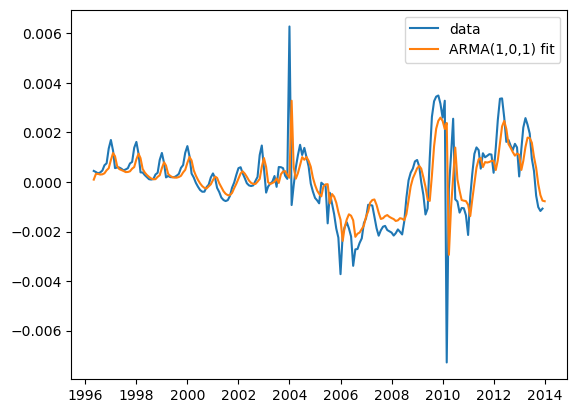

In [993]:
fig, ax = plt.subplots()
ax.plot(train_arma11, label = 'data')
ax.plot(insamp_pred, label = 'ARMA(1,0,1) fit')
ax.legend()

In [994]:
test_arma11.shape

(52, 1)

In [995]:
test_arma11.index

DatetimeIndex(['2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='time', freq=None)

In [996]:
forecast = results.get_forecast(52) # returns an object
predmean = forecast.predicted_mean # the mean
pred_conf = forecast.conf_int() # this gets the 95% confidence interval

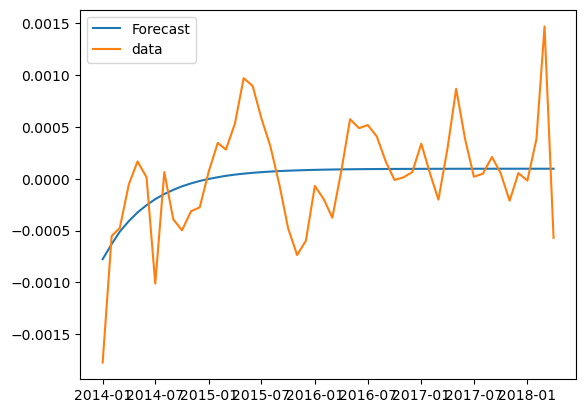

In [997]:
fig, ax = plt.subplots()
ax.plot(predmean, label='Forecast')
ax.plot(test_arma11[0:52], label = 'data')
ax.legend()
plt.show()

In [998]:
plt.plot(results.forecast(0,52), label = 'forecast')
plt.plot(test_arma11[0:52], label = 'data')
plt.axvspan(0,3, alpha = 0.5)
plt.title('Out of sample Forecast')
plt.legend();

TypeError: MLEResults.forecast() takes from 1 to 2 positional arguments but 3 were given

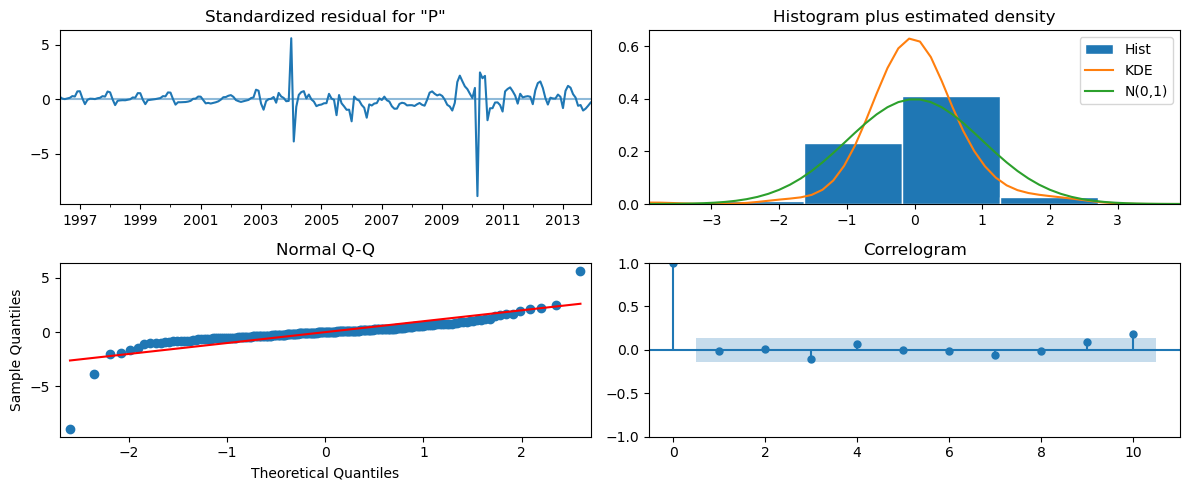

In [999]:
results.plot_diagnostics(figsize = (12,5))
plt.tight_layout()
plt.show()

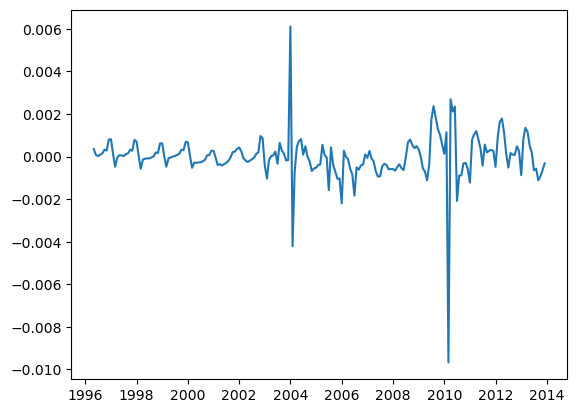

In [1000]:
residuals_arma11 = results.resid
plt.plot(residuals_arma11);

In [1001]:
modl = pm.auto_arima(train_arma11, start_p=1, start_q=4,
                     max_p=4, max_q=4, d= 0, trace=True, stepwise=True, suppress_warnings=True,
                     error_action='ignore')

Performing stepwise search to minimize aic
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=-2278.954, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-2154.339, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-2272.398, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-2218.385, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2155.418, Time=0.01 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=-2263.169, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-2280.981, Time=0.08 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-2255.775, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-2279.281, Time=0.06 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-2279.513, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-2255.902, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-2277.664, Time=0.04 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=-2276.121, Time=0.13 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-2282.910, Time=0.03 sec
 ARIMA(0,0,3)(0,0,0

In [1002]:
train_arma11

Price
time                
1996-05-01  0.000448
1996-06-01  0.000402
1996-07-01  0.000351
1996-08-01  0.000387
1996-09-01  0.000461
...              ...
2013-08-01  0.000442
2013-09-01 -0.000551
2013-10-01 -0.001013
2013-11-01 -0.001169
2013-12-01 -0.001074

[212 rows x 1 columns]

In [1003]:
model_2 = ARIMA(train_arma11, order = (0, 0, 0))
results_2 = model_2.fit();

/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [1004]:
results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  212
Model:                          ARIMA   Log Likelihood                1079.168
Date:                Thu, 13 Jul 2023   AIC                          -2154.335
Time:                        17:09:18   BIC                          -2147.622
Sample:                    05-01-1996   HQIC                         -2151.622
                         - 12-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.346e-05      0.000      0.913      0.361      -0.000       0.000
sigma2       2.21e-06   1.31e-07     16.820      0.000    1.95e-06    2.47e-06
===================================================================================
Ljung-Box (L1) (Q):                  93.00   Jarque-Bera (JB):               101.05
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               9.59   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

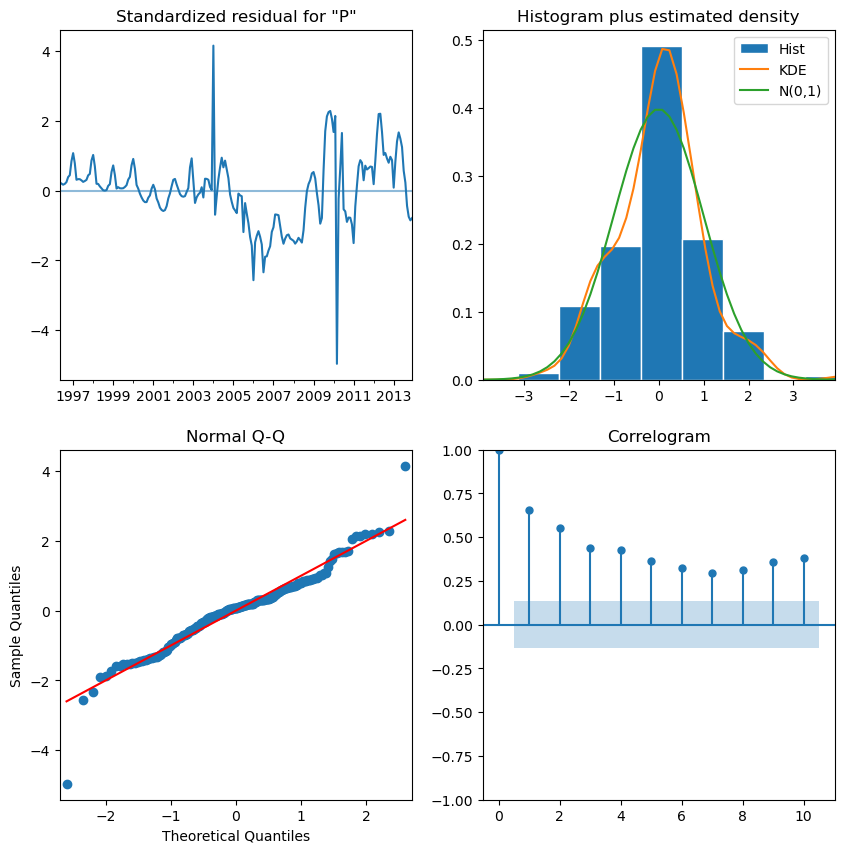

In [1005]:
results_2.plot_diagnostics(figsize = (10,10))
plt.show()

In [1006]:
forecast.results

AttributeError: 'PredictionResults' object has no attribute 'results'

In [1007]:
predmean

2014-01-01   -0.000775
2014-02-01   -0.000630
2014-03-01   -0.000509
2014-04-01   -0.000409
2014-05-01   -0.000325
2014-06-01   -0.000255
2014-07-01   -0.000196
2014-08-01   -0.000148
2014-09-01   -0.000107
2014-10-01   -0.000073
2014-11-01   -0.000045
2014-12-01   -0.000021
2015-01-01   -0.000002
2015-02-01    0.000015
2015-03-01    0.000028
2015-04-01    0.000040
2015-05-01    0.000049
2015-06-01    0.000057
2015-07-01    0.000064
2015-08-01    0.000069
2015-09-01    0.000074
2015-10-01    0.000078
2015-11-01    0.000081
2015-12-01    0.000084
2016-01-01    0.000086
2016-02-01    0.000088
2016-03-01    0.000089
2016-04-01    0.000090
2016-05-01    0.000092
2016-06-01    0.000092
2016-07-01    0.000093
2016-08-01    0.000094
2016-09-01    0.000094
2016-10-01    0.000095
2016-11-01    0.000095
2016-12-01    0.000095
2017-01-01    0.000096
2017-02-01    0.000096
2017-03-01    0.000096
2017-04-01    0.000096
2017-05-01    0.000096
2017-06-01    0.000096
2017-07-01    0.000096
2017-08-01 

In [1008]:
results_2.forecast(52)

2014-01-01    0.000093
2014-02-01    0.000093
2014-03-01    0.000093
2014-04-01    0.000093
2014-05-01    0.000093
2014-06-01    0.000093
2014-07-01    0.000093
2014-08-01    0.000093
2014-09-01    0.000093
2014-10-01    0.000093
2014-11-01    0.000093
2014-12-01    0.000093
2015-01-01    0.000093
2015-02-01    0.000093
2015-03-01    0.000093
2015-04-01    0.000093
2015-05-01    0.000093
2015-06-01    0.000093
2015-07-01    0.000093
2015-08-01    0.000093
2015-09-01    0.000093
2015-10-01    0.000093
2015-11-01    0.000093
2015-12-01    0.000093
2016-01-01    0.000093
2016-02-01    0.000093
2016-03-01    0.000093
2016-04-01    0.000093
2016-05-01    0.000093
2016-06-01    0.000093
2016-07-01    0.000093
2016-08-01    0.000093
2016-09-01    0.000093
2016-10-01    0.000093
2016-11-01    0.000093
2016-12-01    0.000093
2017-01-01    0.000093
2017-02-01    0.000093
2017-03-01    0.000093
2017-04-01    0.000093
2017-05-01    0.000093
2017-06-01    0.000093
2017-07-01    0.000093
2017-08-01 

In [1009]:
forecast = results_2.get_forecast(52) # returns an object
predmean = forecast.predicted_mean # the mean
pred_conf = forecast.conf_int() # this gets the 95% confidence interval

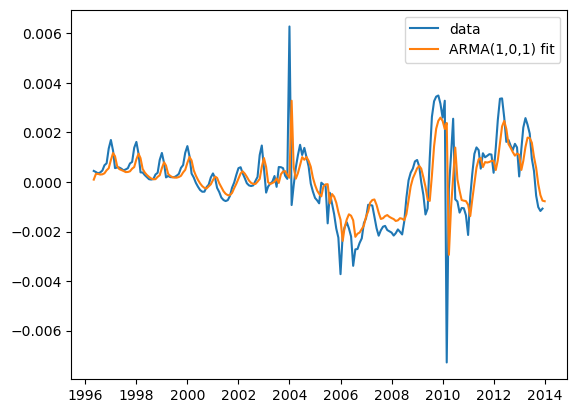

In [1010]:
fig, ax = plt.subplots()
ax.plot(train_arma11, label = 'data')
ax.plot(insamp_pred, label = 'ARMA(1,0,1) fit')
ax.legend();

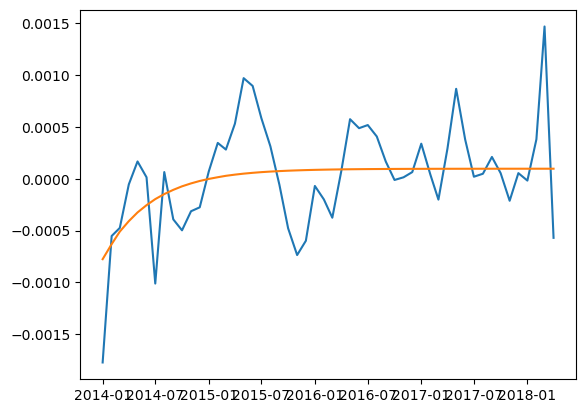

In [1011]:
plt.plot(test_arma11)
plt.plot(results.forecast(52));

In [1012]:
forecast = results_2.get_forecast(52) # returns an object
predmean = forecast.predicted_mean # the mean
pred_conf = forecast.conf_int() # this gets the 95% confidence interval

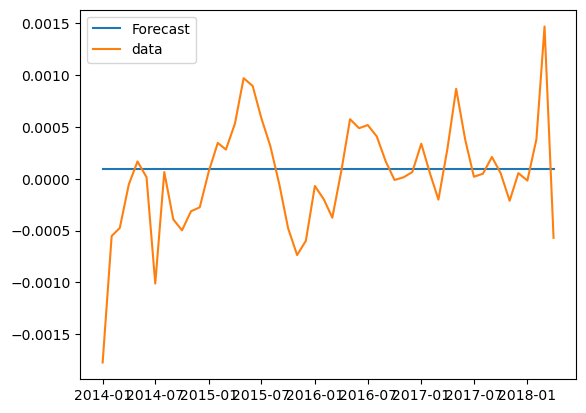

In [1013]:
fig, ax = plt.subplots()
ax.plot(predmean, label='Forecast')
ax.plot(test_arma11[0:52], label = 'data')
ax.legend()
plt.show()

In [1014]:
chicago_price = chicago['Price']

In [1015]:
exp_roll_mean_chi = np.log(chicago_price).ewm(halflife = 3).mean()

        # Logged - EWM
data_minus_exp_roll_mean_chi = np.log(chicago_price) - exp_roll_mean

logewm_log_min_mean_diff_chi = data_minus_exp_roll_mean.diff().dropna()

In [1016]:
adfuller(logewm_log_min_mean_diff_chi)

(-4.138971956074198,
 0.0008344262073295845,
 3,
 260,
 {'1%': -3.4557539868570775,
  '5%': -2.8727214497041422,
  '10%': -2.572728476331361},
 -2691.234629393834)

In [1017]:
exp_roll_mean = np.log(usa_mean).ewm(halflife = 4).mean()

        # Logged - EWM
data_minus_exp_roll_mean = np.log(usa_mean) - exp_roll_mean

<Axes: xlabel='time'>

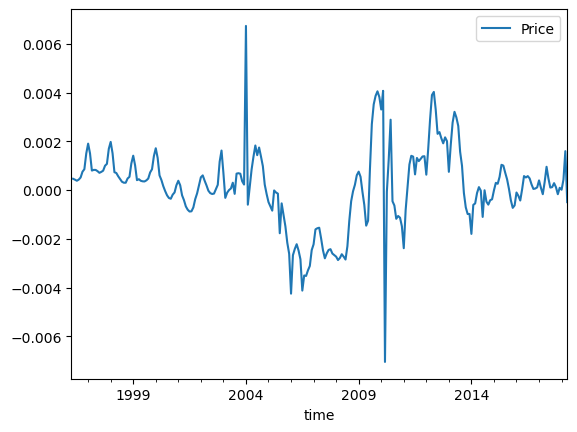

In [1018]:
data_minus_exp_roll_mean.diff().plot()

In [1019]:
adfuller(data_minus_exp_roll_mean.diff().dropna())

(-3.5627418091877012,
 0.006514600549512873,
 3,
 260,
 {'1%': -3.4557539868570775,
  '5%': -2.8727214497041422,
  '10%': -2.572728476331361},
 -2662.990153860212)

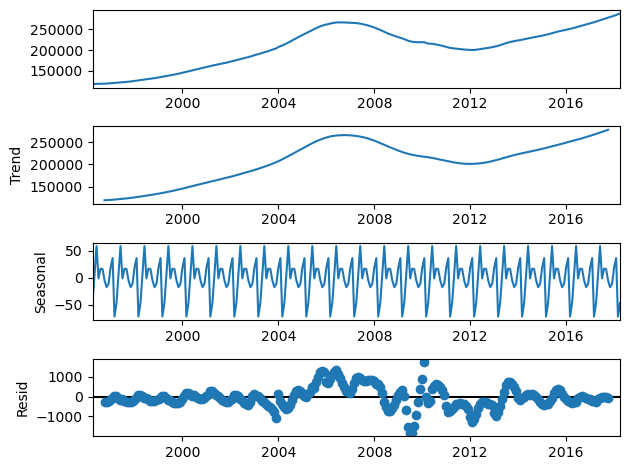

In [1020]:
#fig, ax = plt.subplots(figsize = (12,6))
result = seasonal_decompose(usa_mean, model='additive')
result.plot()
plt.show()

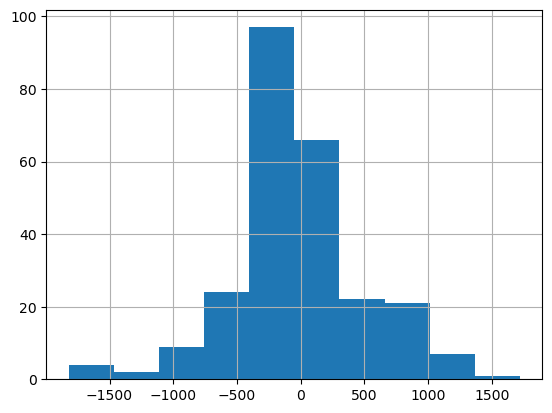

In [1021]:
result = seasonal_decompose(usa_mean, model='additive')

result.resid.hist();

In [1022]:
resid = result.resid.dropna()

In [1023]:
normalized_resid=(resid-resid.mean())/resid.std()

<Axes: >

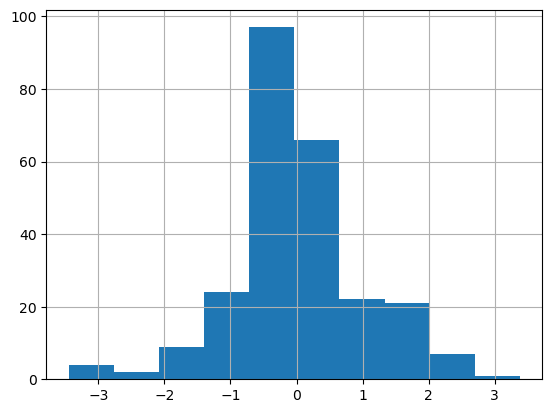

In [1024]:
normalized_resid.hist()

In [1025]:
df_chi_price = chicago['Price']

In [1026]:
#fig, ax = plt.subplots(figsize = (12,6))
result_chi = seasonal_decompose(df_chi_price, model='additive')
result_chi.plot()
plt.show()

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [1027]:
result_chi = seasonal_decompose(df_chi_price, model='additive')

result.resid.hist();

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [1028]:
model = ARIMA(train_arma11, order = (1, 0, 1))


/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [1029]:
log_roll_mean = np.log(usa_mean).rolling(window=7).mean()

In [1030]:
data_minus_roll_mean = np.log(usa_mean) - log_roll_mean

<Axes: xlabel='time'>

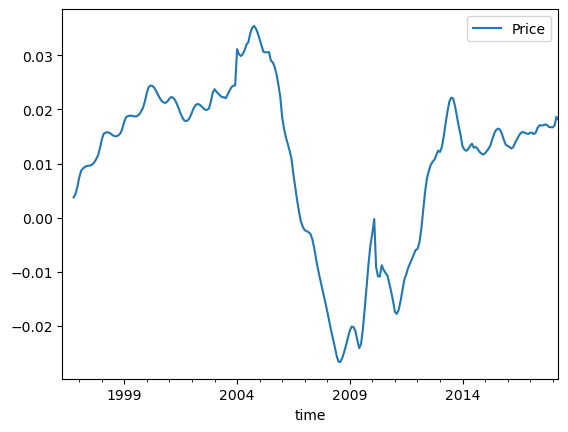

In [1031]:
data_minus_roll_mean.plot()

In [1032]:
data_minus_roll_mean

Price
time                
1996-04-01       NaN
1996-05-01       NaN
1996-06-01       NaN
1996-07-01       NaN
1996-08-01       NaN
...              ...
2017-12-01  0.016732
2018-01-01  0.016690
2018-02-01  0.017074
2018-03-01  0.018653
2018-04-01  0.018114

[265 rows x 1 columns]

In [1033]:
adfuller(data_minus_roll_mean.dropna())

(-2.4276092585814757,
 0.1340950295751921,
 10,
 248,
 {'1%': -3.4569962781990573,
  '5%': -2.8732659015936024,
  '10%': -2.573018897632674},
 -2600.6817701290115)

<Axes: xlabel='time'>

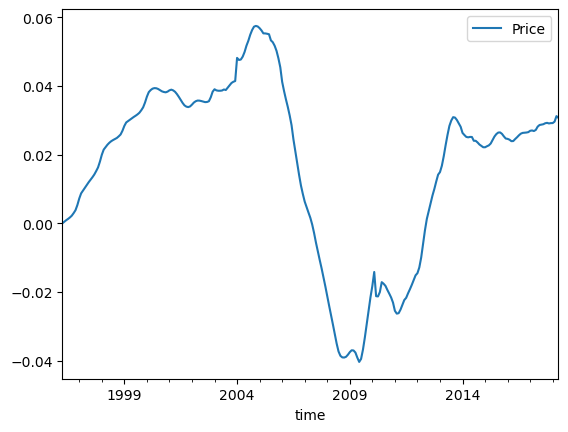

In [1034]:
data_minus_exp_roll_mean.plot()

In [ ]:
diff_log_exp_mean.plot();

In [ ]:
usa_mean['20']

In [ ]:
n_test = '2013'
train_arma11 = usa_mean.loc[:,n_test]
test_arma11 = usa_mean.loc[n_test,:]

In [ ]:
model = ARIMA(train_arma11, order = (1, 1, 1))
results = model.fit()

In [ ]:
results.summary()

In [ ]:
n_test = '2013'
train_arma11_diff = log_diff_data.loc[:,n_test]
test_arma11_diff = log_diff_data.loc[n_test,:];

In [ ]:
model = ARIMA(train_arma11, order = (1, 1, 1))
results = model.fit();

In [ ]:
modl = pm.auto_arima(train_arma11, start_p=1, start_q=1,
                     max_p=5, max_q=5, d= 1, trace=True, stepwise=True, suppress_warnings=True,
                     error_action='ignore')

In [ ]:
chicago_zips = df_melted[df_melted['City'] == 'Chicago']

In [ ]:
chicago_zips.reset_index(inplace = True)

In [ ]:
chicago = chicago_zips.groupby(['Date', 'City']).mean()

In [ ]:
chicago = chicago.reset_index()


In [ ]:
chicago.set_index('Date', inplace = True)

In [ ]:
chicago_price = pd.DataFrame(chicago['Price'])

In [ ]:
chicago_price.plot();

In [ ]:
result_chicago = seasonal_decompose(chicago_price, model='multiplicative') # assume multiplicative model

In [ ]:
fig, ax = plt.subplots(3,1, figsize = (8,10))
result_chicago.trend.plot(ax = ax[0], label = 'trend')
ax[0].legend()
result_chicago.seasonal.plot(ax = ax[1], label = 'seasonal')
ax[1].legend()
result_chicago.resid.plot(ax = ax[2], label = 'residual')
ax[2].legend();

In [ ]:
chicago_zips

In [ ]:
df_chicago['RegionName']

# Step 5: ARIMA Modeling

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
cook = df_melted[df_melted['CountyName'] =='Cook']

In [ ]:
price = cook['Price']

In [ ]:
price.plot(kind='line', figsize=(15,10));

In [ ]:
df_melted.index

In [ ]:
usa_mean.head()

In [ ]:
split_date = '2014-01-01'
usamean_train = usa_mean.loc[usa_mean.index <= split_date].copy()
usamean_test = usa_mean.loc[usa_mean.index > split_date].copy()

In [ ]:
usamean_train

In [ ]:
plt.plot(usamean_train)
plt.plot(usamean_test);

In [ ]:
_ = usamean_test \
    .rename(columns={'value': 'TEST SET'}) \
    .join(usamean_train.rename(columns={'value': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='USA Mean Price', style='.')

In [ ]:
def date_features(df):
    """
    Data features for time series analysis
    """
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear

    return df

In [ ]:
X_train, y_train = create_features(usamean_train, label='House Price')
X_test, y_test = create_features(usamean_test, label='House Price')


In [1372]:
X_train

DatetimeIndex(['2008-02-02', '2008-02-09', '2008-02-16', '2008-02-23',
               '2008-03-01', '2008-03-08', '2008-03-15', '2008-03-22',
               '2008-03-29', '2008-04-05',
               ...
               '2018-10-27', '2018-11-03', '2018-11-10', '2018-11-17',
               '2018-11-24', '2018-12-01', '2018-12-08', '2018-12-15',
               '2018-12-22', '2018-12-29'],
              dtype='datetime64[ns]', name='time', length=570, freq=None)

In [335]:
X_train

year  quarter  month  dayofyear
time                                       
1996-04-01  1996        2      4         92
1996-05-01  1996        2      5        122
1996-06-01  1996        2      6        153
1996-07-01  1996        3      7        183
1996-08-01  1996        3      8        214
...          ...      ...    ...        ...
2014-08-01  2014        3      8        213
2014-09-01  2014        3      9        244
2014-10-01  2014        4     10        274
2014-11-01  2014        4     11        305
2014-12-01  2014        4     12        335

[225 rows x 4 columns]

## XGBoost Regressor

In [420]:
usa_mean

Price  quarter  month  year  dayofyear
time                                                      
1996-04-01  118299.123063        2      4  1996         92
1996-05-01  118419.044139        2      5  1996        122
1996-06-01  118537.423268        2      6  1996        153
1996-07-01  118653.069278        3      7  1996        183
1996-08-01  118780.254312        3      8  1996        214
...                   ...      ...    ...   ...        ...
2017-12-01  281095.320247        4     12  2017        335
2018-01-01  282657.060382        1      1  2018          1
2018-02-01  284368.688447        1      2  2018         32
2018-03-01  286511.376757        1      3  2018         60
2018-04-01  288039.944305        2      4  2018         91

[265 rows x 5 columns]

In [421]:
train = usa_mean.loc[usa_mean.index < '2015-01-01']
test = usa_mean.loc[usa_mean.index >= '2015-01-01']

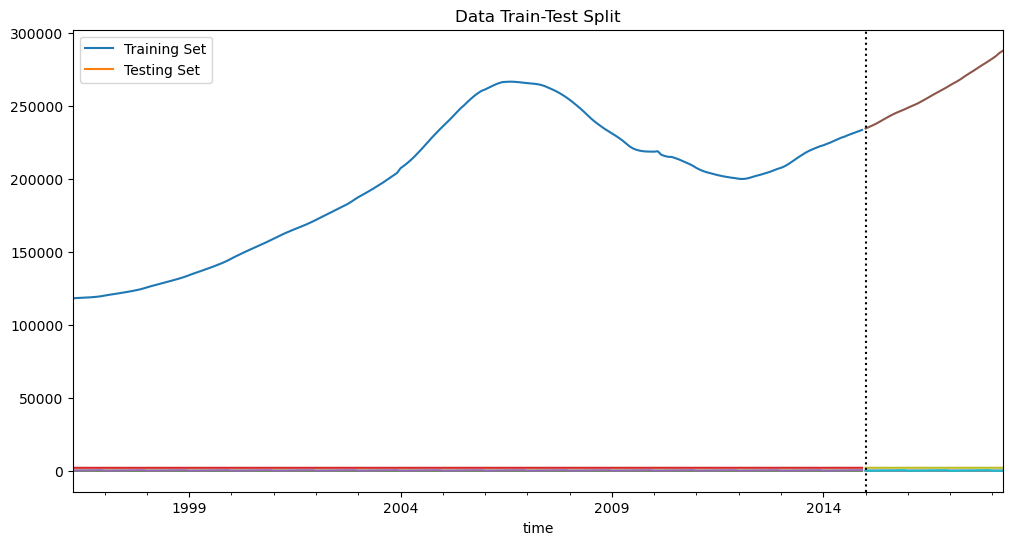

In [422]:
fig,ax = plt.subplots(figsize = (12,6))

train.plot(ax = ax, label = 'Training Set', title = 'Data Train-Test Split')
test.plot(ax = ax, label = 'Testing Set')
ax.axvline('2015-01-01', color = 'black', ls = ':')
ax.legend(['Training Set', 'Testing Set'])
plt.show();

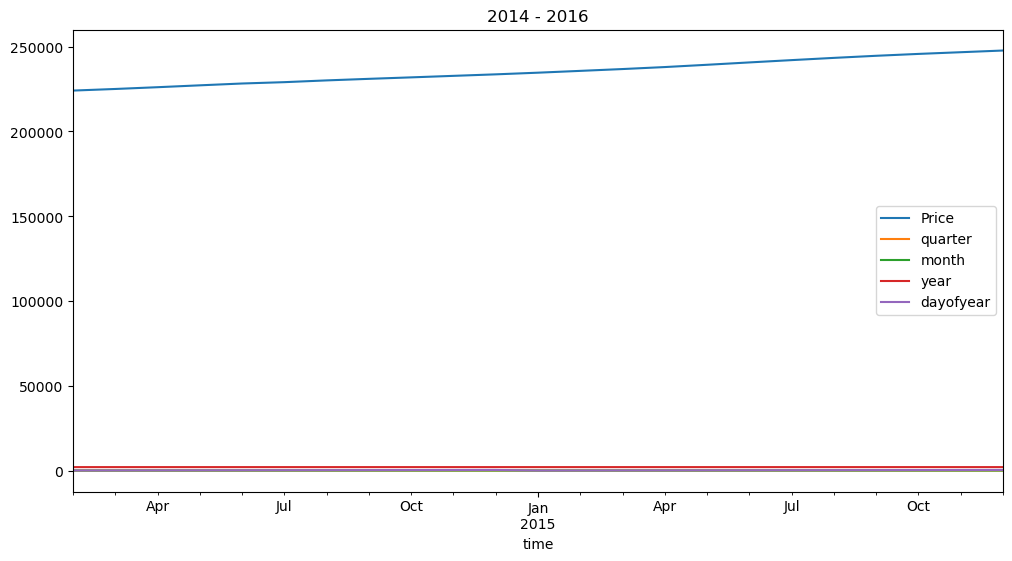

In [423]:
usa_mean.loc[(usa_mean.index > '2014') & (usa_mean.index < '2016')].plot(figsize = (12,6), title = '2014 - 2016')
plt.show();

In [1391]:
usa_mean

Price
time                     
1996-04-01  118299.123063
1996-05-01  118419.044139
1996-06-01  118537.423268
1996-07-01  118653.069278
1996-08-01  118780.254312
...                   ...
2017-12-01  281095.320247
2018-01-01  282657.060382
2018-02-01  284368.688447
2018-03-01  286511.376757
2018-04-01  288039.944305

[265 rows x 1 columns]

In [425]:
def date_features(df):
    """
    Data features for time series analysis
    """
    df = df.copy()
    df['year'] = df.index.year
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear

    return df

In [1392]:
usa_mean_features = date_features(usa_mean)

KeyError: 'time'

In [427]:
usa_mean_features

Price  quarter  month  year  dayofyear
time                                                      
1996-04-01  118299.123063        2      4  1996         92
1996-05-01  118419.044139        2      5  1996        122
1996-06-01  118537.423268        2      6  1996        153
1996-07-01  118653.069278        3      7  1996        183
1996-08-01  118780.254312        3      8  1996        214
...                   ...      ...    ...   ...        ...
2017-12-01  281095.320247        4     12  2017        335
2018-01-01  282657.060382        1      1  2018          1
2018-02-01  284368.688447        1      2  2018         32
2018-03-01  286511.376757        1      3  2018         60
2018-04-01  288039.944305        2      4  2018         91

[265 rows x 5 columns]

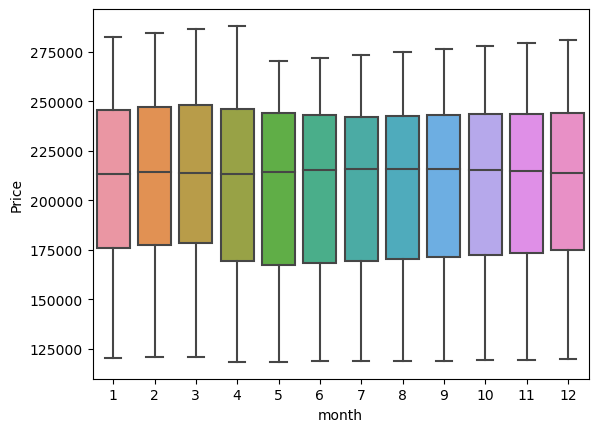

In [415]:
sns.boxplot(data = usa_mean_features, x = 'month', y = 'Price');

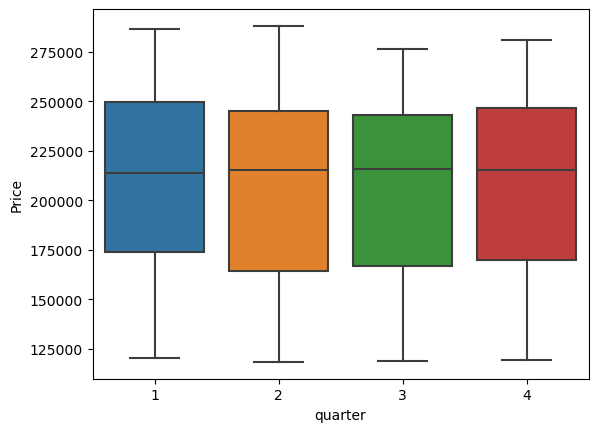

In [416]:
sns.boxplot(data = usa_mean_features, x = 'quarter', y = 'Price');

Don't see much a any seasonal change in house pricing

XBG MODEL #1

In [428]:
train

Price  quarter  month  year  dayofyear
time                                                      
1996-04-01  118299.123063        2      4  1996         92
1996-05-01  118419.044139        2      5  1996        122
1996-06-01  118537.423268        2      6  1996        153
1996-07-01  118653.069278        3      7  1996        183
1996-08-01  118780.254312        3      8  1996        214
...                   ...      ...    ...   ...        ...
2014-08-01  230141.744210        3      8  2014        213
2014-09-01  231060.035319        3      9  2014        244
2014-10-01  231927.514773        4     10  2014        274
2014-11-01  232822.135434        4     11  2014        305
2014-12-01  233712.307274        4     12  2014        335

[225 rows x 5 columns]

In [433]:
train = date_features(train)
test = date_features(test)

In [431]:
features =  ['year', 'quarter', 'month', 'dayofyear']
target = ['Price']

In [435]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [436]:
xbg_model = xgb.XGBRegressor(n_estimartors = 1000, early_stopping_rounds = 50) #lerning_rate = 0.01

xbg_model.fit(X_train, y_train, 
              eval_set = [(x_train, y_train), (X_test, y_test)],
              verbose = True) #verbose = 100

[13:06:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035139432/work/src/learner.cc:767: 
Parameters: { "n_estimartors" } are not used.

[0]	validation_0-rmse:142974.97531	validation_1-rmse:192424.59731
[1]	validation_0-rmse:101161.72895	validation_1-rmse:149098.89413
[2]	validation_0-rmse:71673.92854	validation_1-rmse:118673.72435
[3]	validation_0-rmse:50936.96517	validation_1-rmse:96868.74306
[4]	validation_0-rmse:36354.85697	validation_1-rmse:80364.45459
[5]	validation_0-rmse:26150.94893	validation_1-rmse:69710.43225
[6]	validation_0-rmse:18797.90508	validation_1-rmse:59737.72072
[7]	validation_0-rmse:13692.03462	validation_1-rmse:52599.52958
[8]	validation_0-rmse:9968.12722	validation_1-rmse:47493.97852
[9]	validation_0-rmse:7335.79633	validation_1-rmse:43842.09365
[10]	validation_0-rmse:5431.76782	validation_1-rmse:41516.73370
[11]	validation_0-rmse:4073.35539	validation_1-rmse:39750.17676
[12]	validation_0-rmse:3094.78999	validation_1-rmse:38485.94042
[13]	vali

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimartors=1000, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [224]:
feat_import = pd.DataFrame(xbg_model.feature_importances_,
             index = xbg_model.feature_names_in_,
            columns = ['importance'])

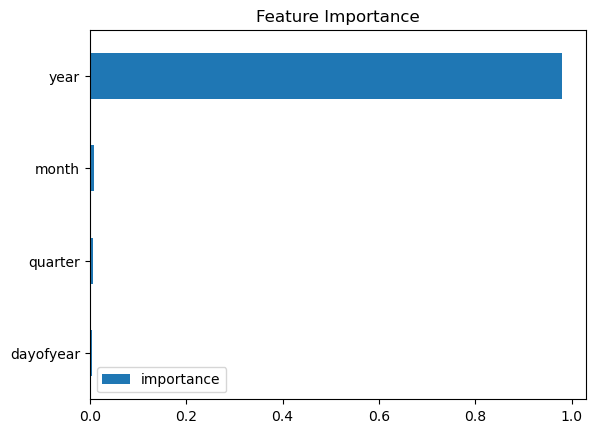

In [196]:
feat_import.sort_values('importance').plot(kind = 'barh', title = 'Feature Importance');

In [228]:
test.head()

Price  year  quarter  month  dayofyear     prediction  \
time                                                                        
2015-01-01  234691.190654  2015        1      1          1  223166.312500   
2015-02-01  235760.279834  2015        1      2         32  224180.875000   
2015-03-01  236836.426000  2015        1      3         60  225000.796875   
2015-04-01  238009.760239  2015        2      4         91  226174.000000   
2015-05-01  239354.207702  2015        2      5        121  227264.703125   

                   error  
time                      
2015-01-01  11524.878154  
2015-02-01  11579.404834  
2015-03-01  11835.629125  
2015-04-01  11835.760239  
2015-05-01  12089.504577

In [445]:
test['prediction'] = xbg_model.predict(X_test)

In [202]:
usa_mean_features = usa_mean_features.merge(test[['prediction']] , how = 'left', left_index = True, right_index = True)

In [204]:
usa_mean_features

Price  quarter  month  year  dayofyear     prediction
time                                                                     
1996-04-01  118299.123063        2      4  1996         92            NaN
1996-05-01  118419.044139        2      5  1996        122            NaN
1996-06-01  118537.423268        2      6  1996        153            NaN
1996-07-01  118653.069278        3      7  1996        183            NaN
1996-08-01  118780.254312        3      8  1996        214            NaN
...                   ...      ...    ...   ...        ...            ...
2017-12-01  281095.320247        4     12  2017        335  233643.906250
2018-01-01  282657.060382        1      1  2018          1  223166.312500
2018-02-01  284368.688447        1      2  2018         32  224180.875000
2018-03-01  286511.376757        1      3  2018         60  225000.796875
2018-04-01  288039.944305        2      4  2018         91  226174.000000

[265 rows x 6 columns]

KeyError: 'prediction'

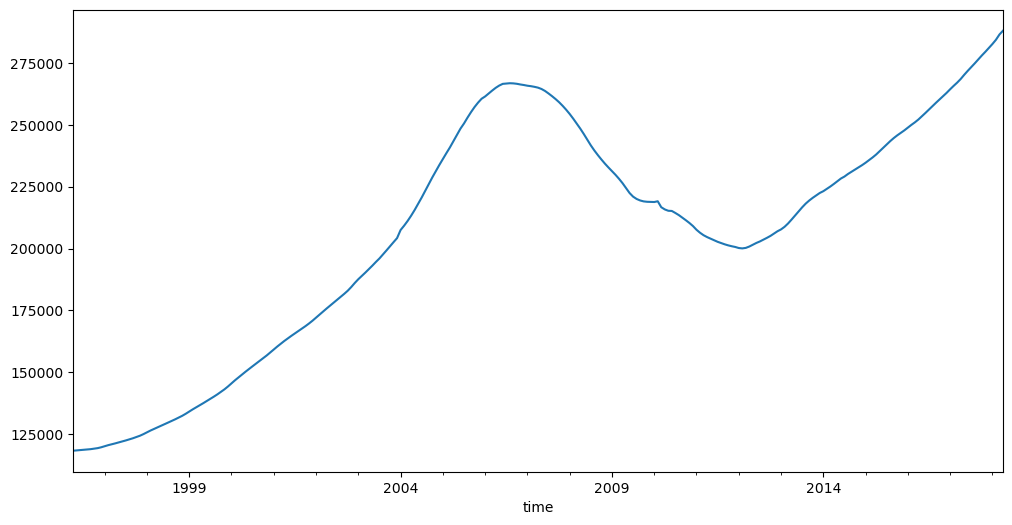

In [446]:
fig,ax = plt.subplots(figsize = (12,6))

usa_mean_features['Price'].plot(ax = ax)
usa_mean_features['prediction'].plot(ax = ax)
ax.axvline('2015-01-01', color = 'black', ls = ':')
plt.show();

In [212]:
rmse_score = np.sqrt(mean_squared_error(test['Price'], test['prediction']))
print(f'First XGB Score on Test set: {rmse_score:0.2f}')

First XGB Score on Test set: 34951.64


In [216]:
test['error'] = np.abs(test['Price'] - test['prediction'])

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1256/3254342177.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['error'] = np.abs(test['Price'] - test['prediction'])


In [217]:
test

Price  year  quarter  month  dayofyear     prediction  \
time                                                                        
2015-01-01  234691.190654  2015        1      1          1  223166.312500   
2015-02-01  235760.279834  2015        1      2         32  224180.875000   
2015-03-01  236836.426000  2015        1      3         60  225000.796875   
2015-04-01  238009.760239  2015        2      4         91  226174.000000   
2015-05-01  239354.207702  2015        2      5        121  227264.703125   
2015-06-01  240744.121443  2015        2      6        152  228303.656250   
2015-07-01  242103.525097  2015        3      7        182  229180.234375   
2015-08-01  243424.444746  2015        3      8        213  230093.875000   
2015-09-01  244658.269374  2015        3      9        244  231095.390625   
2015-10-01  245764.565646  2015        4     10        274  231935.406250   
2015-11-01  246765.041092  2015        4     11        305  232831.859375   
2015-12-01  247765.170142  2015        4     12        335  233643.906250   
2016-01-01  248896.366230  2016        1      1          1  223166.312500   
2016-02-01  249987.312368  2016        1      2         32  224180.875000   
2016-03-01  251014.310942  2016        1      3         61  225000.796875   
2016-04-01  252164.273586  2016        2      4         92  226161.296875   
2016-05-01  253483.637846  2016        2      5        122  227148.500000   
2016-06-01  254820.084222  2016        2      6        153  228322.078125   
2016-07-01  256205.780072  2016        3      7        183  229199.703125   
2016-08-01  257597.914827  2016        3      8        214  230082.890625   
2016-09-01  258946.023229  2016        3      9        245  231141.437500   
2016-10-01  260254.316376  2016        4     10        275  232131.375000   
2016-11-01  261576.900088  2016        4     11        306  232972.828125   
2016-12-01  262923.792705  2016        4     12        336  233152.015625   
2017-01-01  264373.259526  2017        1      1          1  223166.312500   
2017-02-01  265755.097467  2017        1      2         32  224180.875000   
2017-03-01  267065.115805  2017        1      3         60  225000.796875   
2017-04-01  268533.505400  2017        2      4         91  226174.000000   
2017-05-01  270226.842355  2017        2      5        121  227264.703125   
2017-06-01  271824.716430  2017        2      6        152  228303.656250   
2017-07-01  273335.393602  2017        3      7        182  229180.234375   
2017-08-01  274865.774638  2017        3      8        213  230093.875000   
2017-09-01  276464.619982  2017        3      9        244  231095.390625   
2017-10-01  278033.186171  2017        4     10        274  231935.406250   
2017-11-01  279520.858521  2017        4     11        305  232831.859375   
2017-12-01  281095.320247  2017        4     12        335  233643.906250   
2018-01-01  282657.060382  2018        1      1          1  223166.312500   
2018-02-01  284368.688447  2018        1      2         32  224180.875000   
2018-03-01  286511.376757  2018        1      3         60  225000.796875   
2018-04-01  288039.944305  2018        2      4         91  226174.000000   

                   error  
time                      
2015-01-01  11524.878154  
2015-02-01  11579.404834  
2015-03-01  11835.629125  
2015-04-01  11835.760239  
2015-05-01  12089.504577  
2015-06-01  12440.465193  
2015-07-01  12923.290722  
2015-08-01  13330.569746  
2015-09-01  13562.878749  
2015-10-01  13829.159396  
2015-11-01  13933.181717  
2015-12-01  14121.263892  
2016-01-01  25730.053730  
2016-02-01  25806.437368  
2016-03-01  26013.514067  
2016-04-01  26002.976711  
2016-05-01  26335.137846  
2016-06-01  26498.006097  
2016-07-01  27006.076947  
2016-08-01  27515.024202  
2016-09-01  27804.585729  
2016-10-01  28122.941376  
2016-11-01  28604.071963  
2016-12-01  29771.777080  
2017-01-01  41206.947026  
2017-02-01  41574.222467  
2017-03-01  42064.318930  
20

XBG Model #2

In [252]:
train_2 = train
test_2 = test

In [249]:
X_train_2 = train[features]
y_train_2 = train[target]

X_test_2 = test[features]
y_test_2 = test[target]

In [269]:
xbg_model_2 = xgb.XGBRegressor(n_estimartors = 1000, early_stopping_rounds = 50, learning_rate = 0.1)

xbg_model_2.fit(X_train, y_train, 
              eval_set = [(X_train_2, y_train_2), (X_test_2, y_test_2)],
              verbose = True) #verbose = 100

[11:15:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035139432/work/src/learner.cc:767: 
Parameters: { "n_estimartors" } are not used.

[0]	validation_0-rmse:182582.31754	validation_1-rmse:237382.25886
[1]	validation_0-rmse:164721.82895	validation_1-rmse:217129.66275
[2]	validation_0-rmse:148643.50679	validation_1-rmse:200229.90383
[3]	validation_0-rmse:134157.26664	validation_1-rmse:185004.38969
[4]	validation_0-rmse:121101.51148	validation_1-rmse:171288.21249
[5]	validation_0-rmse:109306.46105	validation_1-rmse:158932.68170
[6]	validation_0-rmse:98699.24719	validation_1-rmse:148003.63645
[7]	validation_0-rmse:89088.95310	validation_1-rmse:137996.13657
[8]	validation_0-rmse:80431.72499	validation_1-rmse:128983.65877
[9]	validation_0-rmse:72666.46183	validation_1-rmse:120170.40594
[10]	validation_0-rmse:65635.33211	validation_1-rmse:112777.43650
[11]	validation_0-rmse:59319.07530	validation_1-rmse:106427.62042
[12]	validation_0-rmse:53630.82880	validation_1-rmse:100

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimartors=1000, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [277]:
train_2['prediction'] = xbg_model_2.predict(X_train_2)

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1256/2620336206.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_2['prediction'] = xbg_model_2.predict(X_train_2)


In [270]:
test_2['prediction'] = xbg_model_2.predict(X_test_2)

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1256/4270824535.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_2['prediction'] = xbg_model_2.predict(X_test_2)


In [256]:
usa_mean_features = usa_mean_features.merge(test_2[['prediction']] , how = 'left', left_index = True, right_index = True)

In [257]:
usa_mean_features

Price  quarter  month  year  dayofyear  prediction_x  \
time                                                                       
1996-04-01  118299.123063        2      4  1996         92           NaN   
1996-05-01  118419.044139        2      5  1996        122           NaN   
1996-06-01  118537.423268        2      6  1996        153           NaN   
1996-07-01  118653.069278        3      7  1996        183           NaN   
1996-08-01  118780.254312        3      8  1996        214           NaN   
...                   ...      ...    ...   ...        ...           ...   
2017-12-01  281095.320247        4     12  2017        335   136763.1875   
2018-01-01  282657.060382        1      1  2018          1   136763.1875   
2018-02-01  284368.688447        1      2  2018         32   136763.1875   
2018-03-01  286511.376757        1      3  2018         60   136763.1875   
2018-04-01  288039.944305        2      4  2018         91   136763.1875   

            prediction_y  
time                      
1996-04-01           NaN  
1996-05-01           NaN  
1996-06-01           NaN  
1996-07-01           NaN  
1996-08-01           NaN  
...                  ...  
2017-12-01   136763.1875  
2018-01-01   136763.1875  
2018-02-01   136763.1875  
2018-03-01   136763.1875  
2018-04-01   136763.1875  

[265 rows x 7 columns]

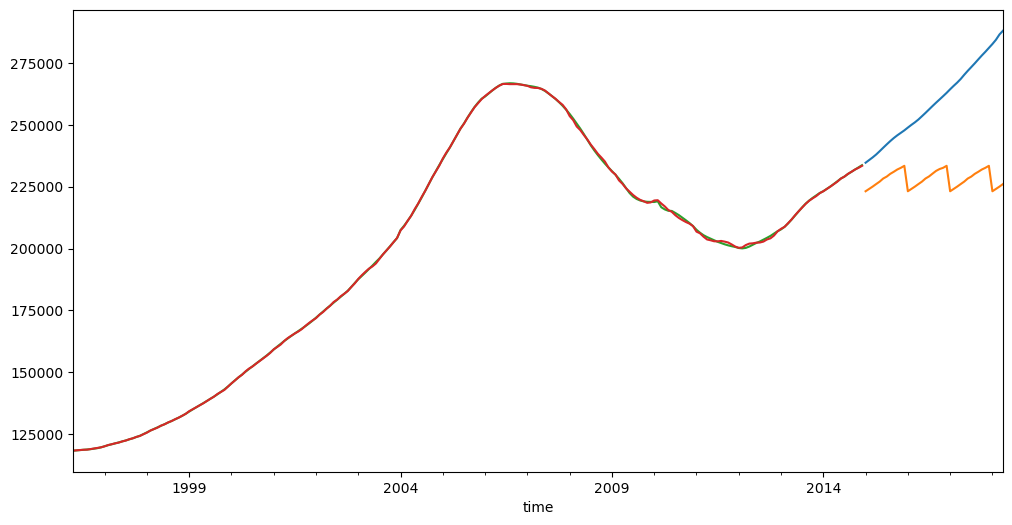

In [282]:
fig,ax = plt.subplots(figsize = (12,6))

test_2['Price'].plot()
test_2['prediction'].plot()
train_2['Price'].plot()
train_2['prediction'].plot()
plt.show();

XGB Model #3

In [310]:
train_3 = train
test_3 = test

In [311]:
X_train_3 = train[features]
y_train_3 = train[target]

X_test_3 = test[features]
y_test_3 = test[target]

In [312]:
xbg_model_3 = xgb.XGBRegressor(n_estimartors = 1000, early_stopping_rounds = 50, learning_rate = .4)

xbg_model_3.fit(X_train_3, y_train_3, 
              eval_set = [(X_train_3, y_train_3), (X_test_3, y_test_3)],
              verbose = True) #verbose = 100

[11:23:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035139432/work/src/learner.cc:767: 
Parameters: { "n_estimartors" } are not used.

[0]	validation_0-rmse:123239.94727	validation_1-rmse:169969.56716
[1]	validation_0-rmse:75367.95254	validation_1-rmse:121138.40251
[2]	validation_0-rmse:46332.68446	validation_1-rmse:91722.79643
[3]	validation_0-rmse:28838.78539	validation_1-rmse:73725.51762
[4]	validation_0-rmse:18139.39270	validation_1-rmse:60776.05805
[5]	validation_0-rmse:11538.34373	validation_1-rmse:50884.02659
[6]	validation_0-rmse:7495.74558	validation_1-rmse:44740.25121
[7]	validation_0-rmse:5026.57710	validation_1-rmse:41537.67454
[8]	validation_0-rmse:3478.53159	validation_1-rmse:39183.00903
[9]	validation_0-rmse:2513.10912	validation_1-rmse:37701.24183
[10]	validation_0-rmse:1895.72260	validation_1-rmse:36780.86794
[11]	validation_0-rmse:1498.37001	validation_1-rmse:36285.13496
[12]	validation_0-rmse:1284.20693	validation_1-rmse:35832.83073
[13]	validati

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.4, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimartors=1000, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [313]:
train_3['prediction'] = xbg_model_3.predict(X_train_3)

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1256/1972770825.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_3['prediction'] = xbg_model_3.predict(X_train_3)


In [314]:
test_3['prediction'] = xbg_model_3.predict(X_test_3)

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1256/949620656.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_3['prediction'] = xbg_model_3.predict(X_test_3)


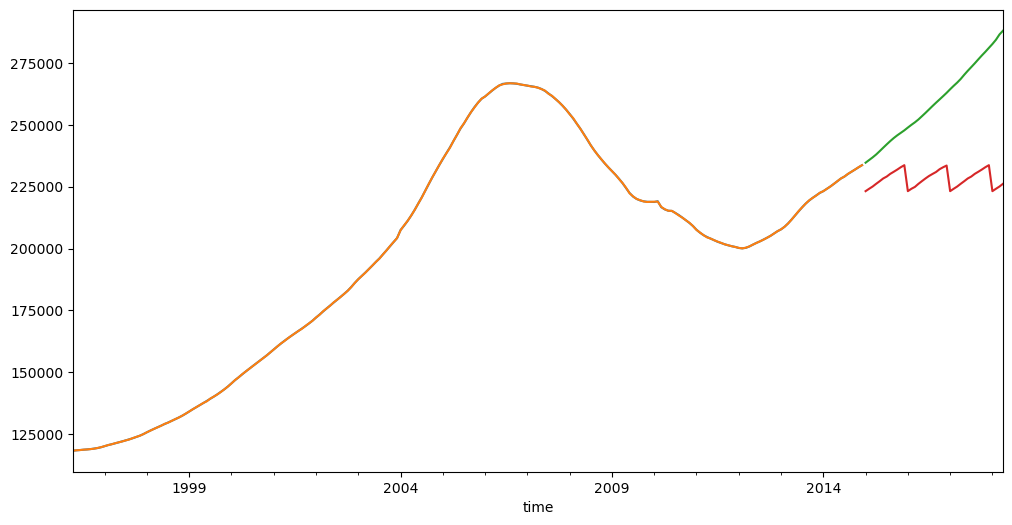

In [320]:
fig,ax = plt.subplots(figsize = (12,6))

train_3['Price'].plot(ax = ax)
train_3['prediction'].plot(ax = ax)

test_3['Price'].plot(ax = ax)
test_3['prediction'].plot(ax = ax)

plt.show();

In [321]:
train_3

Price  quarter  month  year  dayofyear     prediction
time                                                                     
1996-04-01  118299.123063        2      4  1996         92  118268.093750
1996-05-01  118419.044139        2      5  1996        122  118443.906250
1996-06-01  118537.423268        2      6  1996        153  118533.304688
1996-07-01  118653.069278        3      7  1996        183  118697.531250
1996-08-01  118780.254312        3      8  1996        214  118769.554688
...                   ...      ...    ...   ...        ...            ...
2014-08-01  230141.744210        3      8  2014        213  230182.546875
2014-09-01  231060.035319        3      9  2014        244  231033.203125
2014-10-01  231927.514773        4     10  2014        274  231918.656250
2014-11-01  232822.135434        4     11  2014        305  232870.531250
2014-12-01  233712.307274        4     12  2014        335  233692.640625

[225 rows x 6 columns]

Change Model to Only Use More Recent Years

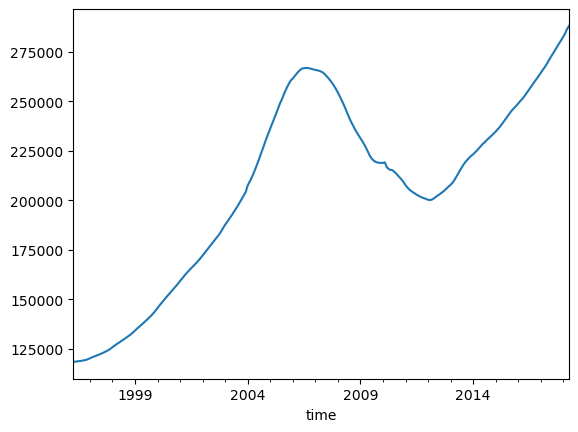

In [357]:
usa_mean['Price'].plot();

In [388]:
us_after_crash = usa_mean.loc['2009':]

In [389]:
us_after_crash.shape

(112, 5)

In [390]:
train_4 = us_after_crash.loc[us_after_crash.index < '2016-01-01']
test_4 = us_after_crash.loc[us_after_crash.index >= '2016-01-01']

In [391]:
train_4.shape

(84, 5)

In [392]:
test_4.shape

(28, 5)

In [393]:
train_with_features_4 = date_features(train_4)
test_with_features_4 = date_features(test_4)

In [396]:
train_with_features_4

Price  quarter  month  year  dayofyear
time                                                      
2009-01-01  231308.672892        1      1  2009          1
2009-02-01  229820.522071        1      2  2009         32
2009-03-01  228199.285512        1      3  2009         60
2009-04-01  226440.435767        2      4  2009         91
2009-05-01  224442.204301        2      5  2009        121
...                   ...      ...    ...   ...        ...
2015-08-01  243424.444746        3      8  2015        213
2015-09-01  244658.269374        3      9  2015        244
2015-10-01  245764.565646        4     10  2015        274
2015-11-01  246765.041092        4     11  2015        305
2015-12-01  247765.170142        4     12  2015        335

[84 rows x 5 columns]

In [399]:
X_train_4 = train_with_features_4[features]
y_train_4 = train_with_features_4[target]

X_test_4 = test_with_features_4[features]
y_test_4 = test_with_features_4[target]

In [400]:
xbg_model_4 = xgb.XGBRegressor(n_estimartors = 1000, early_stopping_rounds = 50, learning_rate = .4)

xbg_model_4.fit(X_train_4, y_train_4, 
              eval_set = [(X_train_4, y_train_4), (X_test_4, y_test_4)],
              verbose = True) #verbose = 100

[11:42:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035139432/work/src/learner.cc:767: 
Parameters: { "n_estimartors" } are not used.

[0]	validation_0-rmse:132777.56207	validation_1-rmse:181182.68738
[1]	validation_0-rmse:80985.63754	validation_1-rmse:129114.36348
[2]	validation_0-rmse:49865.78556	validation_1-rmse:92326.31897
[3]	validation_0-rmse:31135.60833	validation_1-rmse:69778.20418
[4]	validation_0-rmse:19605.70622	validation_1-rmse:54214.99946
[5]	validation_0-rmse:12554.13881	validation_1-rmse:44504.50096
[6]	validation_0-rmse:8224.98874	validation_1-rmse:38456.11675
[7]	validation_0-rmse:5511.97807	validation_1-rmse:35188.11718
[8]	validation_0-rmse:3747.81501	validation_1-rmse:33075.73343
[9]	validation_0-rmse:2656.79461	validation_1-rmse:31746.58731
[10]	validation_0-rmse:1866.91144	validation_1-rmse:30903.69658
[11]	validation_0-rmse:1397.02206	validation_1-rmse:30346.50018
[12]	validation_0-rmse:1059.09316	validation_1-rmse:29985.98648
[13]	validati

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.4, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimartors=1000, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [401]:
y_train_4

Price
time                     
2009-01-01  231308.672892
2009-02-01  229820.522071
2009-03-01  228199.285512
2009-04-01  226440.435767
2009-05-01  224442.204301
...                   ...
2015-08-01  243424.444746
2015-09-01  244658.269374
2015-10-01  245764.565646
2015-11-01  246765.041092
2015-12-01  247765.170142

[84 rows x 1 columns]

In [402]:
train_4['prediction'] = xbg_model_4.predict(X_train_4)
test_4['prediction'] = xbg_model_4.predict(X_test_4)

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1256/2394090962.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_4['prediction'] = xbg_model_4.predict(X_train_4)
/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1256/2394090962.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_4['prediction'] = xbg_model_4.predict(X_test_4)


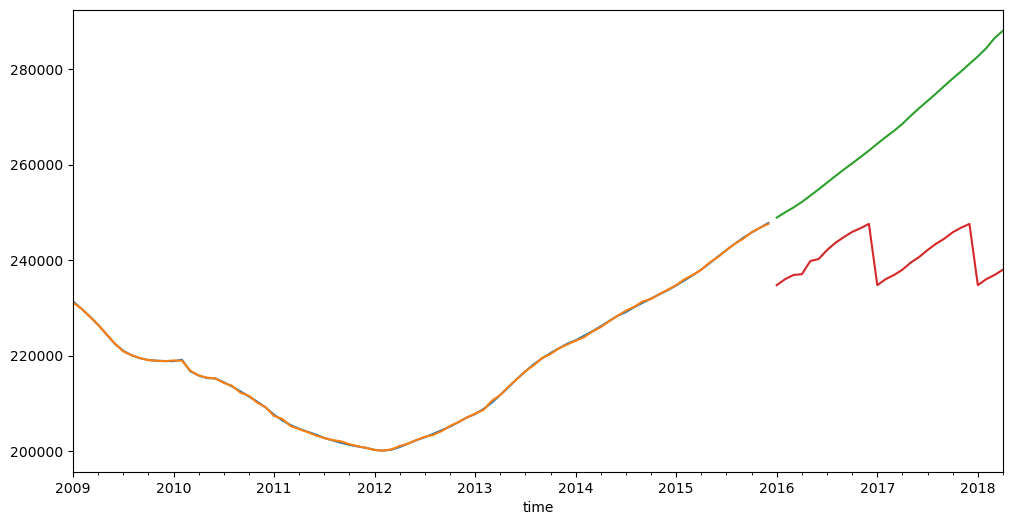

In [403]:
fig,ax = plt.subplots(figsize = (12,6))

train_4['Price'].plot(ax = ax)
train_4['prediction'].plot(ax = ax)

test_4['Price'].plot(ax = ax)
test_4['prediction'].plot(ax = ax)

plt.show();